# Project LELEC

## Recode features and Data set

In [1]:
import statistics
import numpy as np
import scipy.stats
import statsmodels.api as sm
from scipy.stats import shapiro
import pandas as pd
import jupyterthemes as jt
import researchpy as rp
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from collections import defaultdict
from matplotlib.cm import ScalarMappable
from scipy.stats import linregress
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import GammaRegressor
from sklearn._loss.glm_distribution import (
    TweedieDistribution,
    NormalDistribution, PoissonDistribution,
    GammaDistribution, InverseGaussianDistribution,
)
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from numpy import arange
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from yellowbrick.regressor import cooks_distance
sns.set(style="ticks", context="talk")
plt.style.use('dark_background')


X1 = pd.read_csv('X1.csv')
Y1 = pd.read_csv('Y1.csv', header=None, names=['revenue'])
data = X1.assign(Revenue = Y1.values)
del data['is_adult']
data = data.replace(r'\N', np.nan).dropna().reset_index(drop=True)
data.runtime = data.runtime.astype(int)
data["genres"]= data["genres"].str.split(",")
data.runtime = data.runtime.astype(int)
data["Time"] = (data.release_year+1) - data.production_year
data

Unnamed: 0                       title  \
0           2502           Letters to Juliet   
1           1800        International Velvet   
2           2675                   8 Seconds   
3           3674             Penitentiary II   
4            365         The Boondock Saints   
...          ...                         ...   
3270        2787            Stiff Upper Lips   
3271        2319                  Twenty Two   
3272        1856                   Girlfight   
3273        1531  This Film Is Not Yet Rated   
3274        2919  MVP: Most Valuable Primate   

                                                img_url  \
0     https://m.media-amazon.com/images/M/MV5BMjg0OT...   
1     https://m.media-amazon.com/images/M/MV5BOGVkYj...   
2     https://m.media-amazon.com/images/M/MV5BYjY4Nz...   
3     https://m.media-amazon.com/images/M/MV5BNjQyZW...   
4     https://m.media-amazon.com/images/M/MV5BNTliMT...   
...                                                 ...   
3270  https://m.media-amazon.com/images/M/MV5BNGRiMz...   
3271  https://m.media-amazon.com/images/M/MV5BMjMyMz...   
3272  https://m.media-amazon.com/images/M/MV5BMTMzMz...   
3273  https://m.media-amazon.com/images/M/MV5BMTk0ND...   
3274  https://m.media-amazon.com/images/M/MV5BMjMzOD...   

                                            description  ratings   n_votes  \
0     Letters to Juliet: Directed by Gary Winick. Wi...      6.5   92937.0   
1     International Velvet: Directed by Bryan Forbes...      5.9    1345.0   
2     8 Seconds: Directed by John G. Avildsen. With ...      6.6    4851.0   
3     Penitentiary II: Directed by Jamaa Fanaka. Wit...      4.1     549.0   
4     The Boondock Saints: Directed by Troy Duffy. W...      7.8  228296.0   
...                                                 ...      ...       ...   
3270  Stiff Upper Lips: Directed by Gary Sinyor. Wit...      6.3     973.0   
3271  Twenty Two: Directed by Jack Smight. With Barb...      8.0    2190.0   
3272  Girlfight: Directed by Lawrence Trilling. With...      7.6      34.0   
3273  This Film Is Not Yet Rated: Directed by Kirby ...      7.5   27379.0   
3274  MVP: Most Valuable Primate: Directed by Robert...      4.1    2296.0   

      production_year  runtime                      genres  release_year  \
0                2010      105  [Adventure, Comedy, Drama]        2010.0   
1                1978      127      [Drama, Family, Sport]        1978.0   
2                1994      105   [Biography, Drama, Sport]        1994.0   
3                1982      108       [Crime, Drama, Sport]        1982.0   
4                1999      108   [Action, Crime, Thriller]        2000.0   
...               ...      ...                         ...           ...   
3270             1997       94                    [Comedy]        1999.0   
3271             1961       25    [Drama, Fantasy, Horror]        2017.0   
3272             2001       44            [Drama, Romance]        2000.0   
3273             2006       98               [Documentary]        2006.0   
3274             2000       93     [Comedy, Family, Sport]        2000.0   

      studio                                     img_embeddings  \
0       Sum.  [0.25030804, 2.4058464, 1.0431569, 0.030648155...   
1        MGM  [0.18073043, 0.24735461, 0.63652813, 0.2496522...   
2         NL  [0.025015268, 0.9105338, 0.3878257, 0.3421247,...   
3        MGM  [0.19079691, 1.9068279, 0.29114372, 0.19527505...   
4     Indic.  [0.41613612, 1.580189, 0.99092495, 0.55354017,...   
...      ...                                                ...   
3270    Cow.  [0.19991912, 1.3718543, 1.1531808, 0.052152418...   
3271      CL  [0.38660493, 0.81947947, 1.9521054, 0.23831718...   
3272    SGem  [0.15014637, 2.0139444, 1.0844889, 0.17270318,...   
3273     IFC  [0.25391683, 3.8994913, 0.23327282, 0.17322594...   
3274  Equin.  [0.3297945, 1.6534383, 0.968067, 0.37325135, 0...   

                                        text_embeddings       Rev

In [2]:
def compute_rmse(predict, target):
    if len(target.shape) == 2:
        target = target.squeeze()
    if len(predict.shape) == 2:
        predict = predict.squeeze()
    diff = target - predict
    if len(diff.shape) == 1:
        diff = np.expand_dims(diff, axis=-1)
    rmse = np.sqrt(diff.T@diff / diff.shape[0])
    return float(rmse)

## Description statistics

In [3]:
data.describe().round(1)

Unnamed: 0  ratings    n_votes  production_year  runtime  release_year  \
count      3275.0   3275.0     3275.0           3275.0   3275.0        3275.0   
mean       4560.4      6.4    25253.5           1997.1     92.3        2001.1   
std        2637.4      1.1    89124.2             11.7     32.6           9.2   
min           1.0      1.1        5.0           1916.0      2.0        1941.0   
25%        2276.0      5.7      276.0           1992.0     85.0        1995.5   
50%        4607.0      6.5     1832.0           2000.0     95.0        2003.0   
75%        6834.0      7.1    11046.0           2005.0    106.0        2007.0   
max        9158.0      9.4  2332286.0           2019.0    566.0        2018.0   

           Revenue    Time  
count       3275.0  3275.0  
mean    24425924.3     4.9  
std     60670855.2    10.5  
min          130.4     0.0  
25%        40742.9     1.0  
50%       480666.7     1.0  
75%     19316872.7     2.0  
max    810246717.3    96.0

## Plots

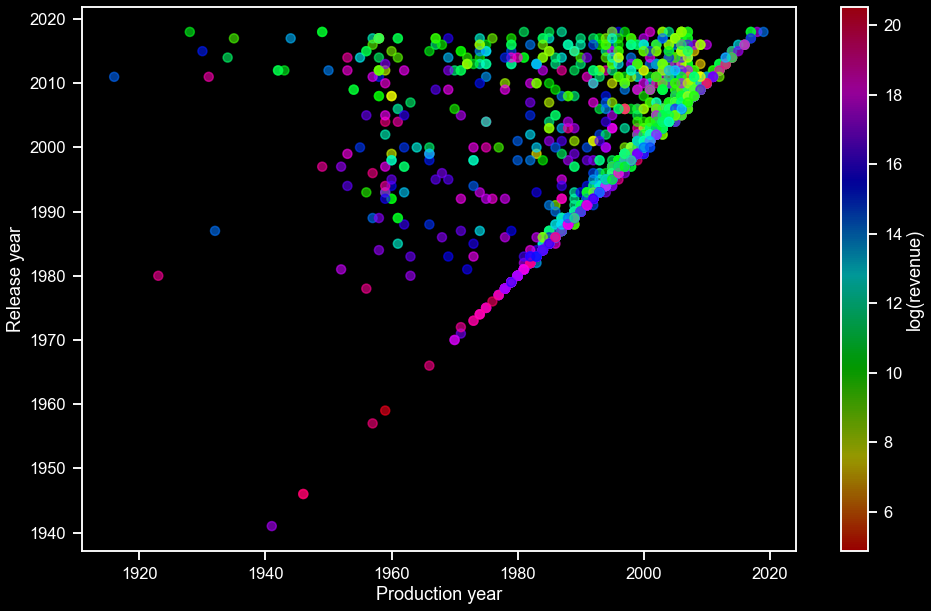

In [4]:
plt.figure(figsize=(16, 10))
Revenuel = np.log(data.Revenue)

plt.scatter(data.production_year,data.release_year, c = Revenuel, cmap='hsv', alpha = 0.6)
plt.colorbar(label = "log(revenue)")
plt.xlabel('Production year')
plt.ylabel('Release year')
plt.show()

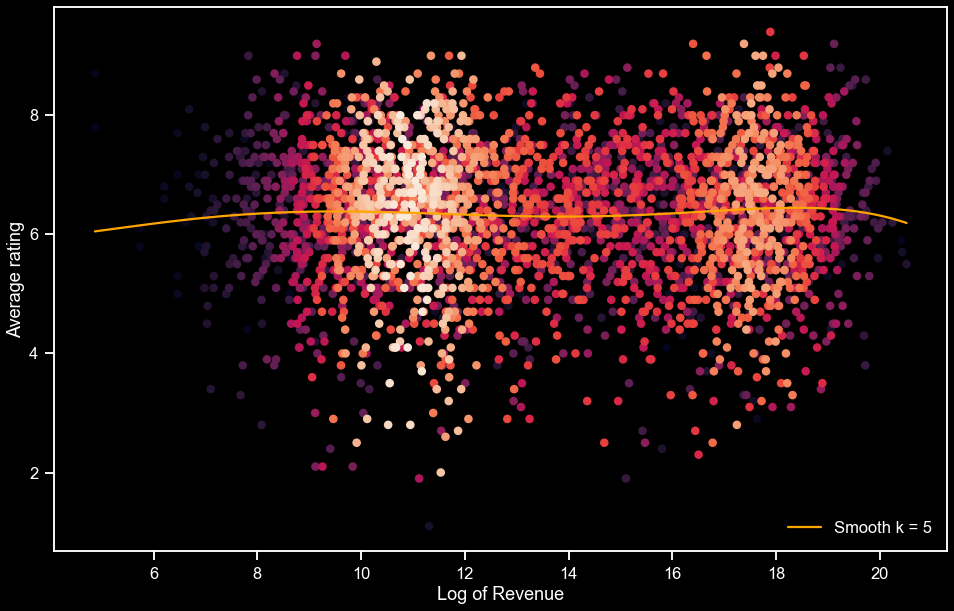

In [5]:
Revenuel = np.log(data.Revenue)

xy = np.vstack([data.ratings,Revenuel])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
data.ratings, Revenuel, z = data.ratings[idx], Revenuel[idx], z[idx]

sort_indexes  = sorted(range(len(Revenuel)), key=lambda k: Revenuel[k])
sorted_Revenuel = sorted(Revenuel)
    
coeff = np.polyfit(sorted_Revenuel, data.ratings, 5)
x = np.linspace(sorted_Revenuel[0], sorted_Revenuel[-1], num = 100)
Polynomial = np.polyval(coeff, x)

fig, ax = plt.subplots(figsize=(16, 10))
ax.scatter(Revenuel, data.ratings, c=z, s=50)
plt.plot(x, Polynomial, '-', label = 'Smooth k = 5', color='orange') 
plt.xlabel('Log of Revenue')
plt.legend(loc='lower right')
plt.ylabel('Average rating')
plt.show()

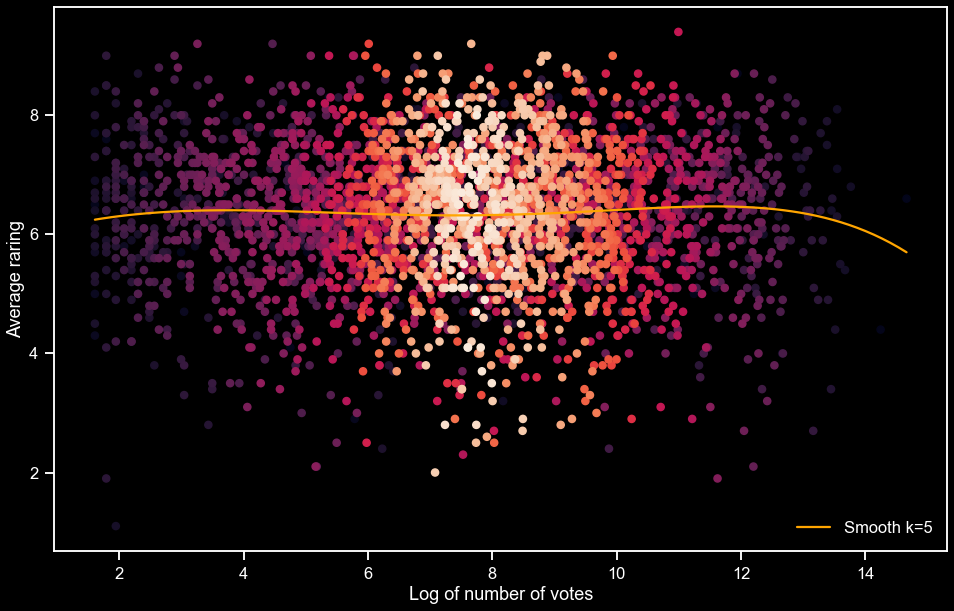

In [6]:
n_votesl = np.log(data.n_votes)

xy = np.vstack([data.ratings,n_votesl])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
data.ratings, n_votesl, z = data.ratings[idx], n_votesl[idx], z[idx]

sort_indexes  = sorted(range(len(n_votesl)), key=lambda k: n_votesl[k])
sorted_n_votesl = sorted(n_votesl)
    
coeff = np.polyfit(sorted_n_votesl, data.ratings, 5)
x = np.linspace(sorted_n_votesl[0], sorted_n_votesl[-1], num = 100)
Polynomial = np.polyval(coeff, x)


fig, ax = plt.subplots(figsize=(16, 10))
ax.scatter(n_votesl, data.ratings, c=z, s=50)
plt.plot(x, Polynomial, '-', label = 'Smooth k=5', color='orange') 
plt.xlabel('Log of number of votes')
plt.legend(loc='lower right')
plt.ylabel('Average raring')
plt.show()

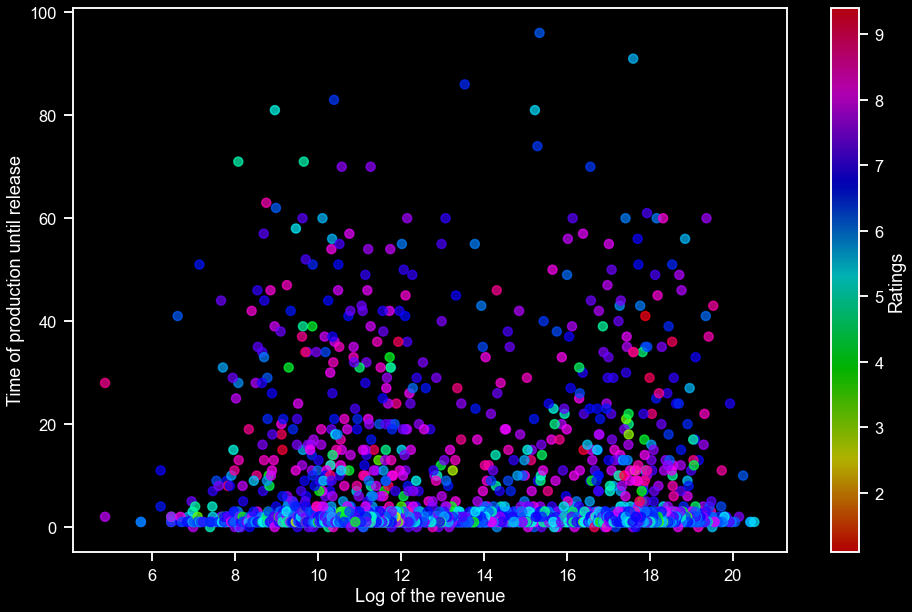

In [7]:
plt.figure(figsize=(16, 10))

plt.scatter(Revenuel,data.Time, c = data.ratings, cmap='hsv', alpha = 0.7)
plt.colorbar(label = "Ratings")
plt.xlabel('Log of the revenue')
plt.ylabel('Time of production until release')
plt.show()

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


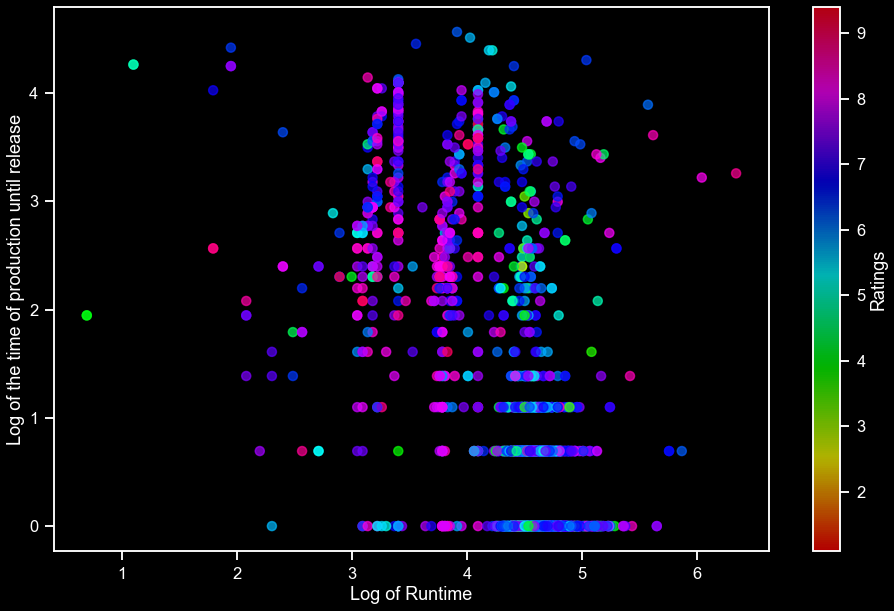

In [8]:
plt.figure(figsize=(16, 10))

runtimel = np.log(data.runtime)
timel = np.log(data.Time)

plt.scatter(runtimel,timel, c = data.ratings, cmap='hsv', alpha = 0.7)
plt.colorbar(label = "Ratings")
plt.xlabel('Log of Runtime')
plt.ylabel('Log of the time of production until release')
plt.show()

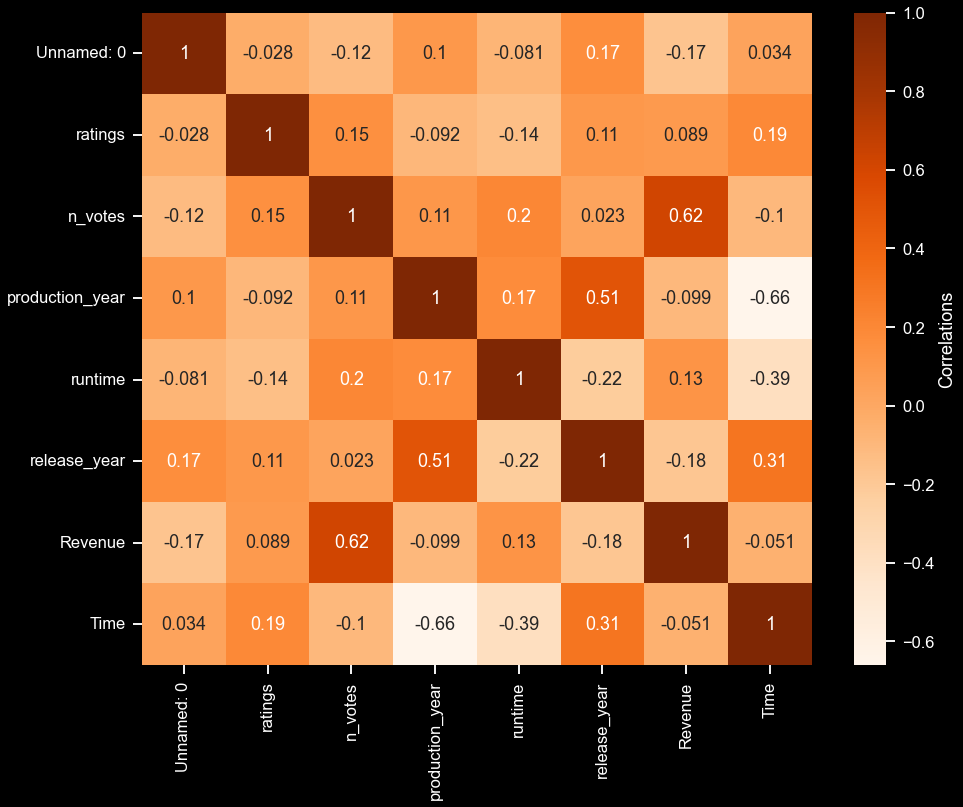

In [9]:
corr_matrix = data.corr()
plt.figure(figsize=(15, 12))


heat_map = sns.heatmap(corr_matrix, annot=True, cmap = "Oranges", cbar_kws={'label': 'Correlations'})
plt.show()

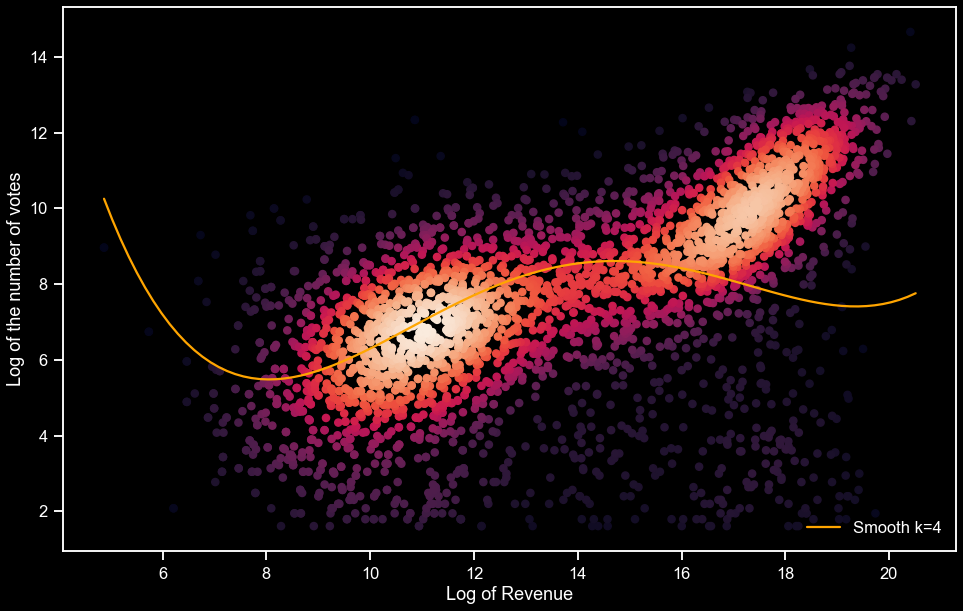

In [10]:
sns.set(style="ticks", context="talk")
plt.style.use('dark_background')

Revenuel = np.log(data.Revenue)
nvotesl = np.log(data.n_votes)

xy = np.vstack([nvotesl,Revenuel])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
nvotesl, Revenuel, z = nvotesl[idx], Revenuel[idx], z[idx]

sort_indexes  = sorted(range(len(Revenuel)), key=lambda k: Revenuel[k])
sorted_Revenuel = sorted(Revenuel)
    
coeff = np.polyfit(sorted_Revenuel, nvotesl, 4)
x = np.linspace(sorted_Revenuel[0], sorted_Revenuel[-1], num = 100)
Polynomial = np.polyval(coeff, x)

fig, ax = plt.subplots(figsize=(16, 10))
ax.scatter(Revenuel, nvotesl, c=z, s=50)
plt.plot(x, Polynomial, '-', label = 'Smooth k=4', color='orange') 
plt.xlabel('Log of Revenue')
plt.legend(loc='lower right')
plt.ylabel('Log of the number of votes')
plt.show()

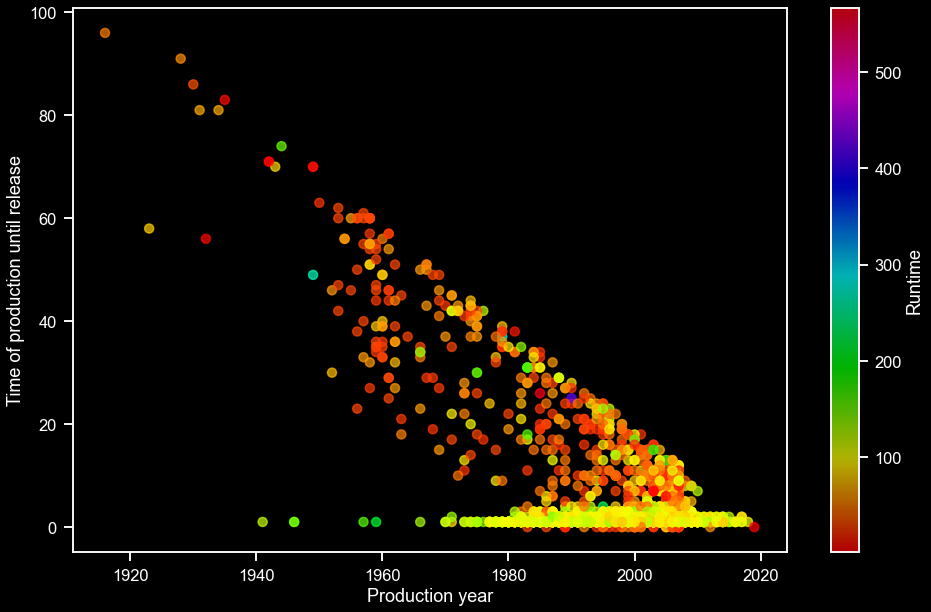

In [11]:
sns.set(style="ticks", context="talk")
plt.style.use('dark_background')

plt.figure(figsize=(16, 10))

plt.scatter(data.production_year,data.Time, c = data.runtime, cmap='hsv', alpha = 0.7)
plt.colorbar(label = "Runtime")

plt.xlabel('Production year')
plt.ylabel('Time of production until release')
plt.show()

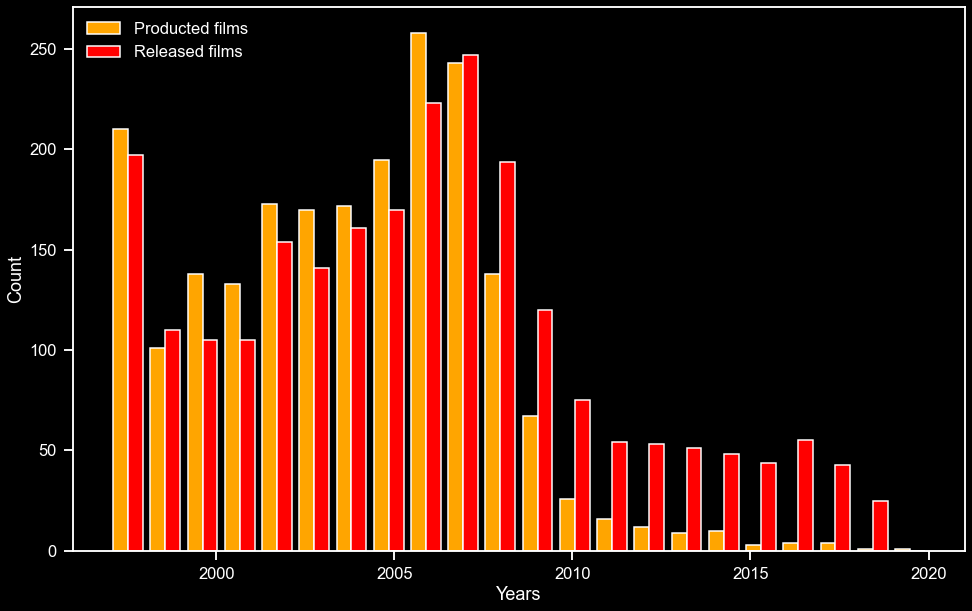

In [12]:
sns.set(style="ticks", context="talk")
plt.style.use('dark_background')
bins = np.linspace(1997, 2020, 23)
plt.figure(figsize=(16, 10))
plt.hist([data.production_year,data.release_year],bins,color=['Orange', 'Red'],
         label=["Producted films","Released films"])
plt.legend(loc='upper left')
plt.xlabel('Years')
plt.ylabel('Count')
plt.show()

<AxesSubplot:xlabel='Revenue', ylabel='Density'>

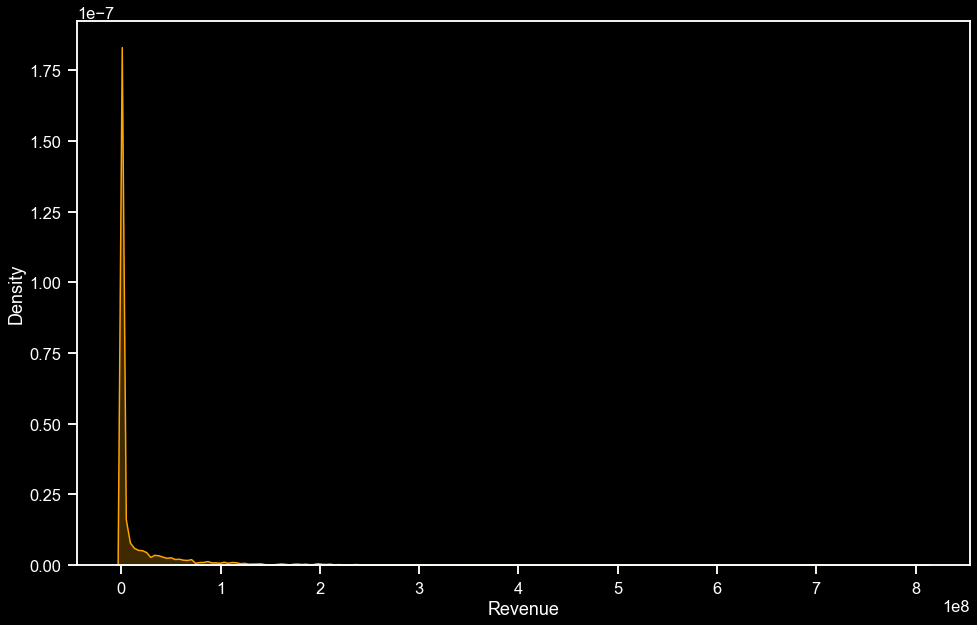

In [13]:
plt.figure(figsize=(16, 10))

sns.kdeplot(data.Revenue, bw_adjust=0.1, color = 'Orange', fill = True)

<AxesSubplot:xlabel='Revenue', ylabel='Density'>

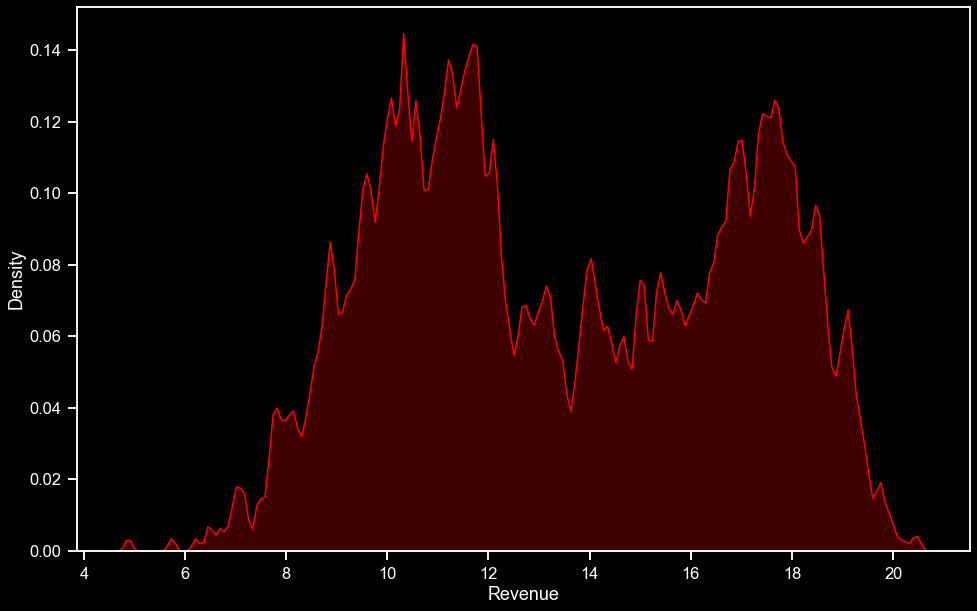

In [14]:
plt.figure(figsize=(16, 10))

sns.kdeplot(Revenuel, bw_adjust=0.1, color = 'Red', fill = True)


In [15]:
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]
get_best_distribution(data.Revenue)

p value for norm = 0.0
p value for exponweib = 1.2926907589072969e-46


/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:1726: RuntimeWarning: invalid value encountered in add
  logp = (np.log(a) + np.log(c) + sc.xlogy(a - 1.0, exm1c) +


p value for weibull_max = 0.0
p value for weibull_min = 7.044581026032249e-91
p value for pareto = 1.4154784716439814e-264
p value for genextreme = 0.0
Best fitting distribution: exponweib
Best p value: 1.2926907589072969e-46
Parameters for the best fit: (1.2897926606881498, 0.28097111252977686, 130.38694638694633, 1951798.5216929084)


/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


('exponweib',
 1.2926907589072969e-46,
 (1.2897926606881498,
  0.28097111252977686,
  130.38694638694633,
  1951798.5216929084))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


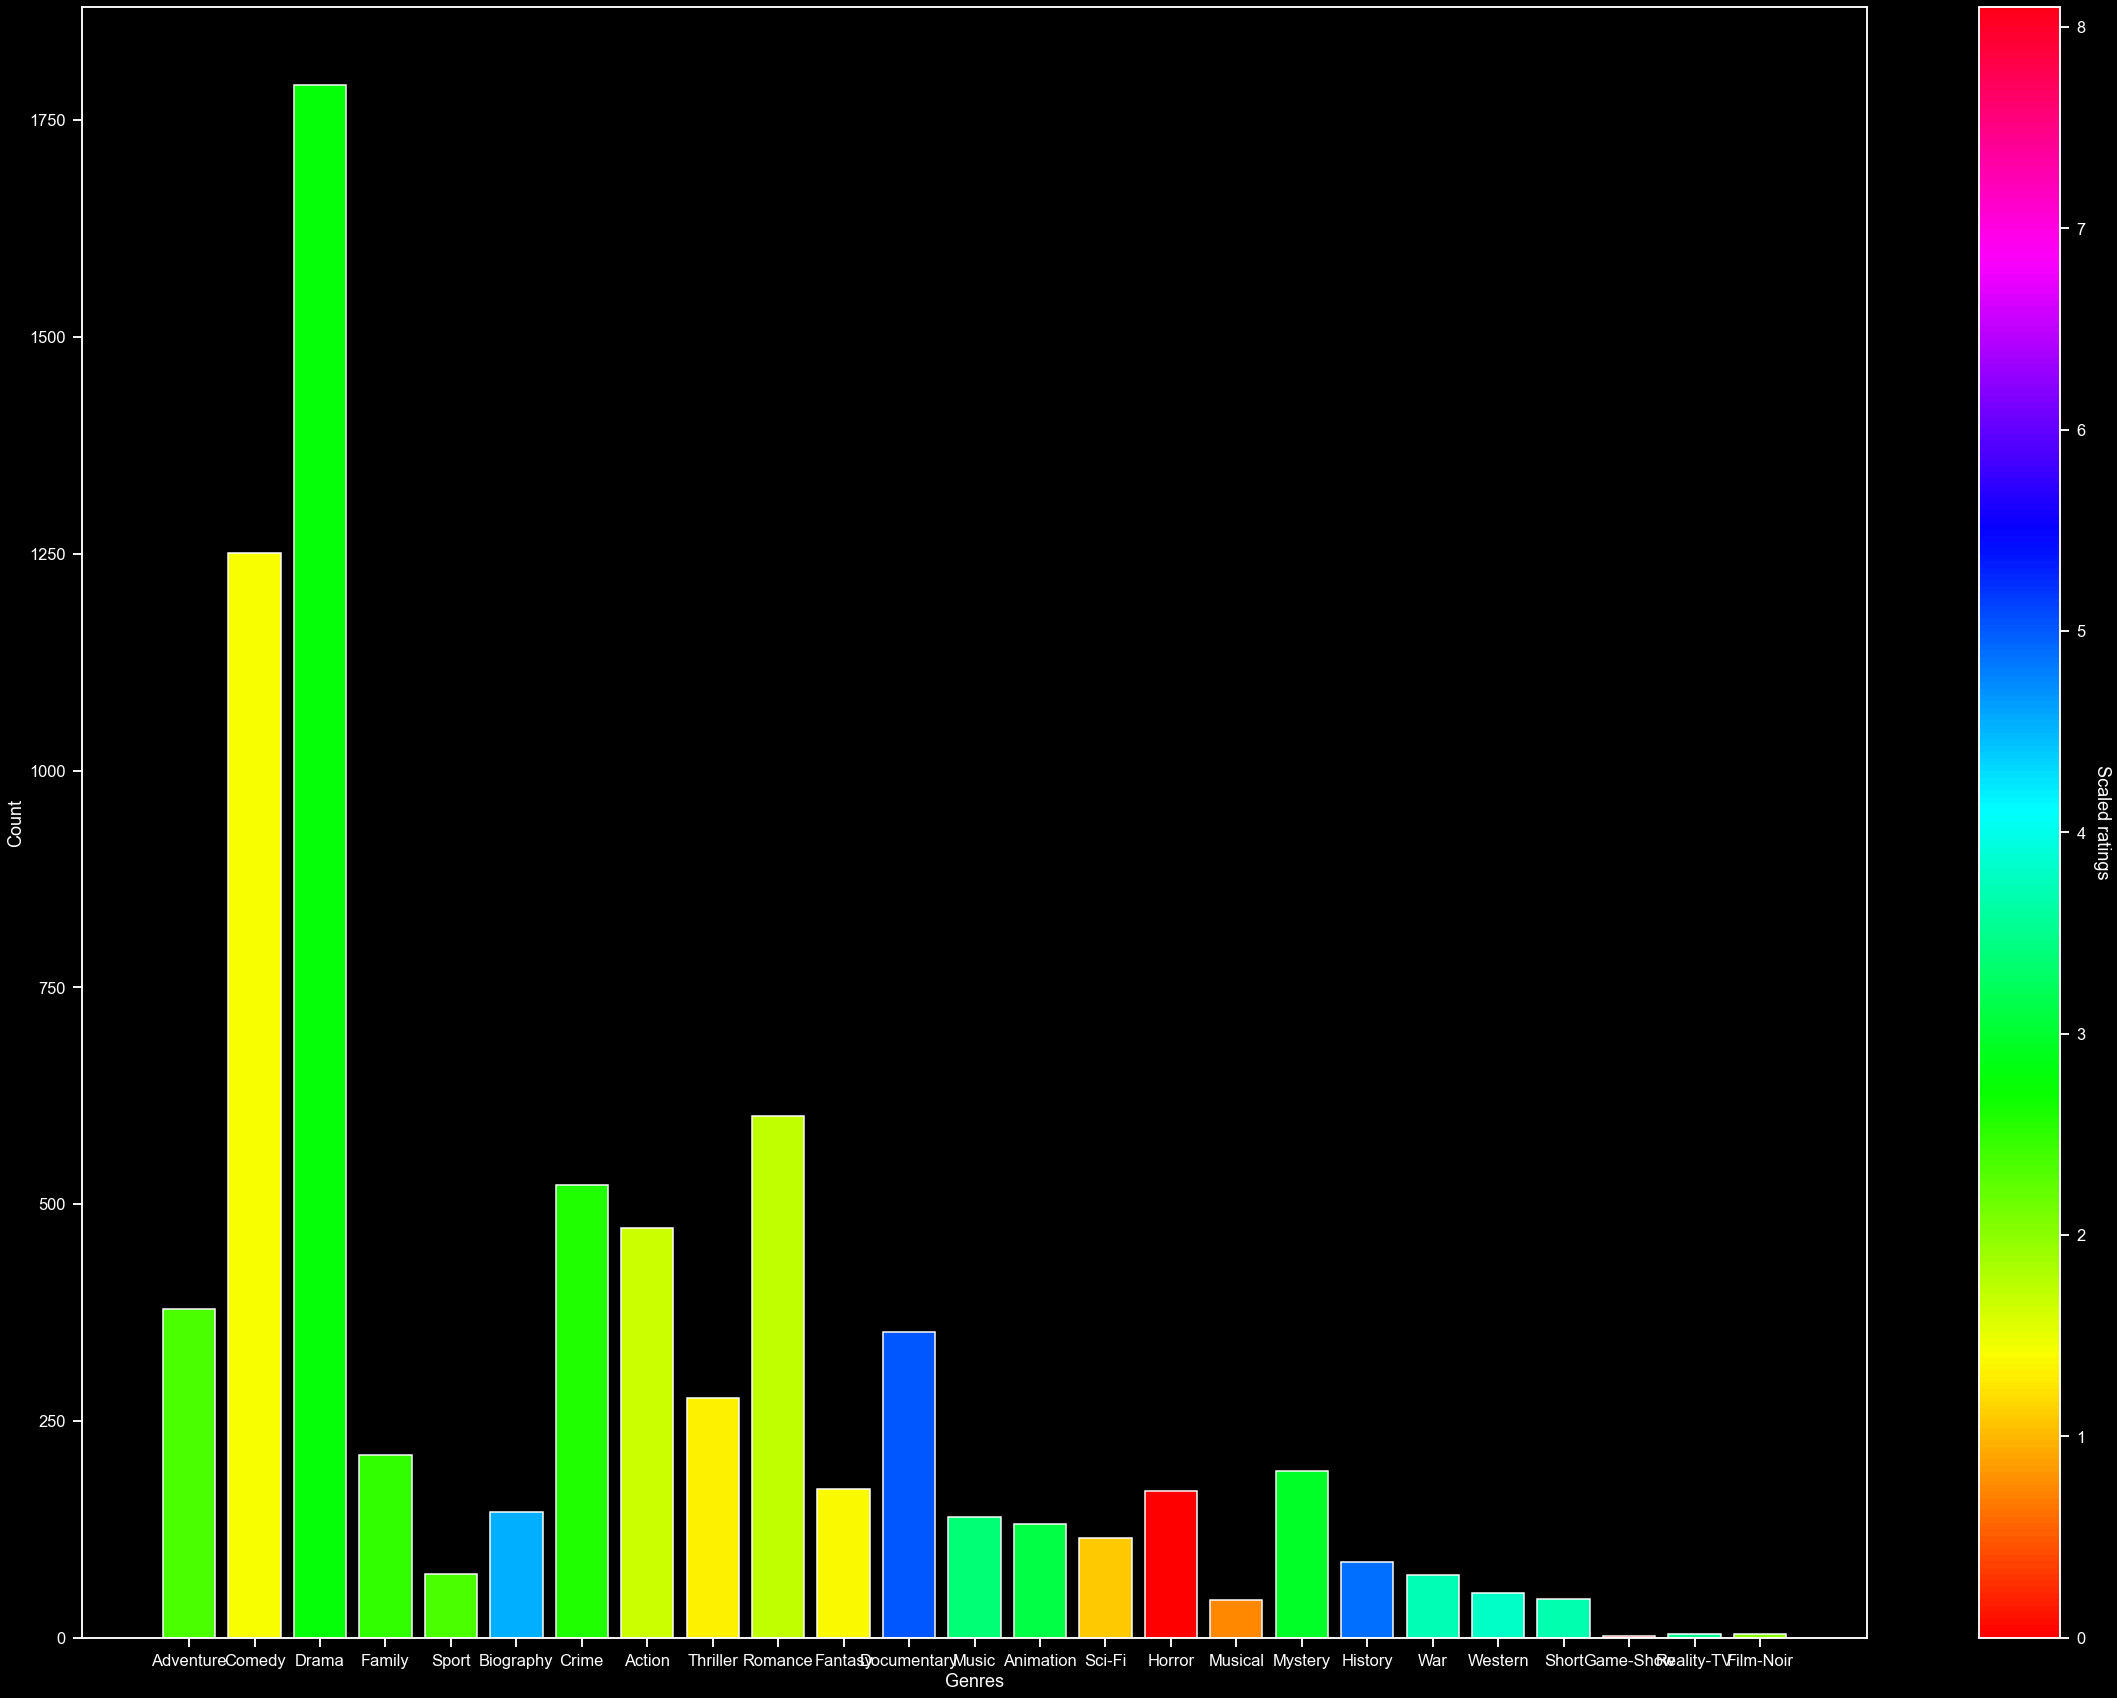

In [16]:
plt.figure(figsize=(40, 30))
genrescount = defaultdict(dict)

rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
my_cmap = plt.get_cmap("hsv")


for i in range(len(data)):
    for j in data.genres[i]:
        if j in genrescount:
            genrescount[j]['count'] += 1
            genrescount[j]['rating'] += data.ratings[i]
        else:
            genrescount[j]['count'] = 1
            genrescount[j]['rating'] = data.ratings[i]
for i in genrescount:
    genrescount[i]['rating'] = genrescount[i]['rating']/genrescount[i]['count']

genres = []
count = []
ratings = []

for key in genrescount.keys():
    genres.append(key)
    count.append(genrescount[key]['count'])
    ratings.append(genrescount[key]['rating'])

sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,max(ratings)))
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('Scaled ratings', rotation=270,labelpad=25)

plt.bar(genres, count, color = my_cmap(rescale(ratings)))
plt.legend(loc='upper left')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.show()

## Recode dummy for genre

In [17]:
genrescount.keys()
for i in genrescount.keys():
    data[i] = 0
for i in range(len(data)):
    for j in data.genres[i]:
        data.loc[i,j] = 1

In [18]:
DATAMLP = data.copy(deep=True)

In [19]:
datalinear = data.copy(deep = True)
del datalinear['title']
del datalinear['img_url']
del datalinear['description']
del datalinear['img_embeddings']
del datalinear['text_embeddings']


In [20]:
datalinear

Unnamed: 0  ratings   n_votes  production_year  runtime  \
0           2502      6.5   92937.0             2010      105   
1           1800      5.9    1345.0             1978      127   
2           2675      6.6    4851.0             1994      105   
3           3674      4.1     549.0             1982      108   
4            365      7.8  228296.0             1999      108   
...          ...      ...       ...              ...      ...   
3270        2787      6.3     973.0             1997       94   
3271        2319      8.0    2190.0             1961       25   
3272        1856      7.6      34.0             2001       44   
3273        1531      7.5   27379.0             2006       98   
3274        2919      4.1    2296.0             2000       93   

                          genres  release_year  studio       Revenue  Time  \
0     [Adventure, Comedy, Drama]        2010.0    Sum.  7.158530e+07   1.0   
1         [Drama, Family, Sport]        1978.0     MGM  3.164907e+07   1.0   
2      [Biography, Drama, Sport]        1994.0      NL  3.898197e+07   1.0   
3          [Crime, Drama, Sport]        1982.0     MGM  9.697023e+06   1.0   
4      [Action, Crime, Thriller]        2000.0  Indic.  5.209444e+04   2.0   
...                          ...           ...     ...           ...   ...   
3270                    [Comedy]        1999.0    Cow.  1.280834e+05   3.0   
3271    [Drama, Fantasy, Horror]        2017.0      CL  5.620866e+04  57.0   
3272            [Drama, Romance]        2000.0    SGem  2.677043e+06   0.0   
3273               [Documentary]        2006.0     IFC  4.480911e+05   1.0   
3274     [Comedy, Family, Sport]        2000.0  Equin.  2.134906e+06   1.0   

      ...  Horror  Musical  Mystery  History  War  Western  Short  Game-Show  \
0     ...       0        0        0        0    0        0      0          0   
1     ...       0        0        0        0    0        0      0          0   
2     ...       0        0        0        0    0        0      0          0   
3     ...       0        0        0        0    0        0      0          0   
4     ...       0        0        0        0    0        0      0          0   
...   ...     ...      ...      ...      ...  ...      ...    ...        ...   
3270  ...       0        0        0        0    0        0      0          0   
3271  ...       1        0        0        0    0        0      0          0   
3272  ...       0        0        0        0    0        0      0          0   
3273  ...       0        0        0        0    0        0      0          0   
3274  ...       0        0        0        0    0        0      0          0   

      Reality-TV  Film-Noir  
0              0          0  
1              0          0  
2              0          0  
3              0          0  
4              0          0  
...          ...        ...  
3270           0          0  
3271           0          0  
3272           0          0  
3273           0          0  
3274           0          0  

[3275 rows x 35 columns]

## Check if we can recode studios levels

In [21]:
group = []
groups = datalinear.groupby('studio').apply(len)
for i in groups.keys().values:
    if groups.get(i) == 1:
         group.append(i)
dataindependent = datalinear.replace(group, "Independent")
group = []
groups = datalinear.groupby('studio').apply(len)
for i in groups.keys().values:
    if groups.get(i) <= 40:
         group.append(i)
dataindependent = dataindependent.replace(group, "Small")
group = []
groups = datalinear.groupby('studio').apply(len)
for i in groups.keys().values:
    if groups.get(i) <= 100:
         group.append(i)
dataindependent = dataindependent.replace(group, "Middle")
group = []
groups = datalinear.groupby('studio').apply(len)
for i in groups.keys().values:
    if groups.get(i) <= 170:
         group.append(i)
dataindependent = dataindependent.replace(group, "Leader")
print(dataindependent.groupby('studio').apply(len))



studio
Independent     180
Leader          768
Middle          562
Small          1765
dtype: int64


## Dummy variables for studio

In [22]:
studio =  dataindependent['studio'].unique()
for i in studio:
    dataindependent[i] = 0
for i in range(len(dataindependent)):
        dataindependent.loc[i,dataindependent.studio[i]] = 1

In [23]:
dataindependent

Unnamed: 0  ratings   n_votes  production_year  runtime  \
0           2502      6.5   92937.0             2010      105   
1           1800      5.9    1345.0             1978      127   
2           2675      6.6    4851.0             1994      105   
3           3674      4.1     549.0             1982      108   
4            365      7.8  228296.0             1999      108   
...          ...      ...       ...              ...      ...   
3270        2787      6.3     973.0             1997       94   
3271        2319      8.0    2190.0             1961       25   
3272        1856      7.6      34.0             2001       44   
3273        1531      7.5   27379.0             2006       98   
3274        2919      4.1    2296.0             2000       93   

                          genres  release_year       studio       Revenue  \
0     [Adventure, Comedy, Drama]        2010.0        Small  7.158530e+07   
1         [Drama, Family, Sport]        1978.0       Middle  3.164907e+07   
2      [Biography, Drama, Sport]        1994.0       Middle  3.898197e+07   
3          [Crime, Drama, Sport]        1982.0       Middle  9.697023e+06   
4      [Action, Crime, Thriller]        2000.0        Small  5.209444e+04   
...                          ...           ...          ...           ...   
3270                    [Comedy]        1999.0        Small  1.280834e+05   
3271    [Drama, Fantasy, Horror]        2017.0        Small  5.620866e+04   
3272            [Drama, Romance]        2000.0        Small  2.677043e+06   
3273               [Documentary]        2006.0       Middle  4.480911e+05   
3274     [Comedy, Family, Sport]        2000.0  Independent  2.134906e+06   

      Time  ...  War  Western  Short  Game-Show  Reality-TV  Film-Noir  Small  \
0      1.0  ...    0        0      0          0           0          0      1   
1      1.0  ...    0        0      0          0           0          0      0   
2      1.0  ...    0        0      0          0           0          0      0   
3      1.0  ...    0        0      0          0           0          0      0   
4      2.0  ...    0        0      0          0           0          0      1   
...    ...  ...  ...      ...    ...        ...         ...        ...    ...   
3270   3.0  ...    0        0      0          0           0          0      1   
3271  57.0  ...    0        0      0          0           0          0      1   
3272   0.0  ...    0        0      0          0           0          0      1   
3273   1.0  ...    0        0      0          0           0          0      0   
3274   1.0  ...    0        0      0          0           0          0      0   

      Middle  Leader  Independent  
0          0       0            0  
1          1       0            0  
2          1       0            0  
3          1       0            0  
4          0       0            0  
...      ...     ...          ...  
3270       0       0            0  
3271       0       0            0  
3272       0       0            0  
3273       1       0            0  
3274       0       0            1  

[3275 rows x 39 columns]

<Figure size 2880x2160 with 0 Axes>

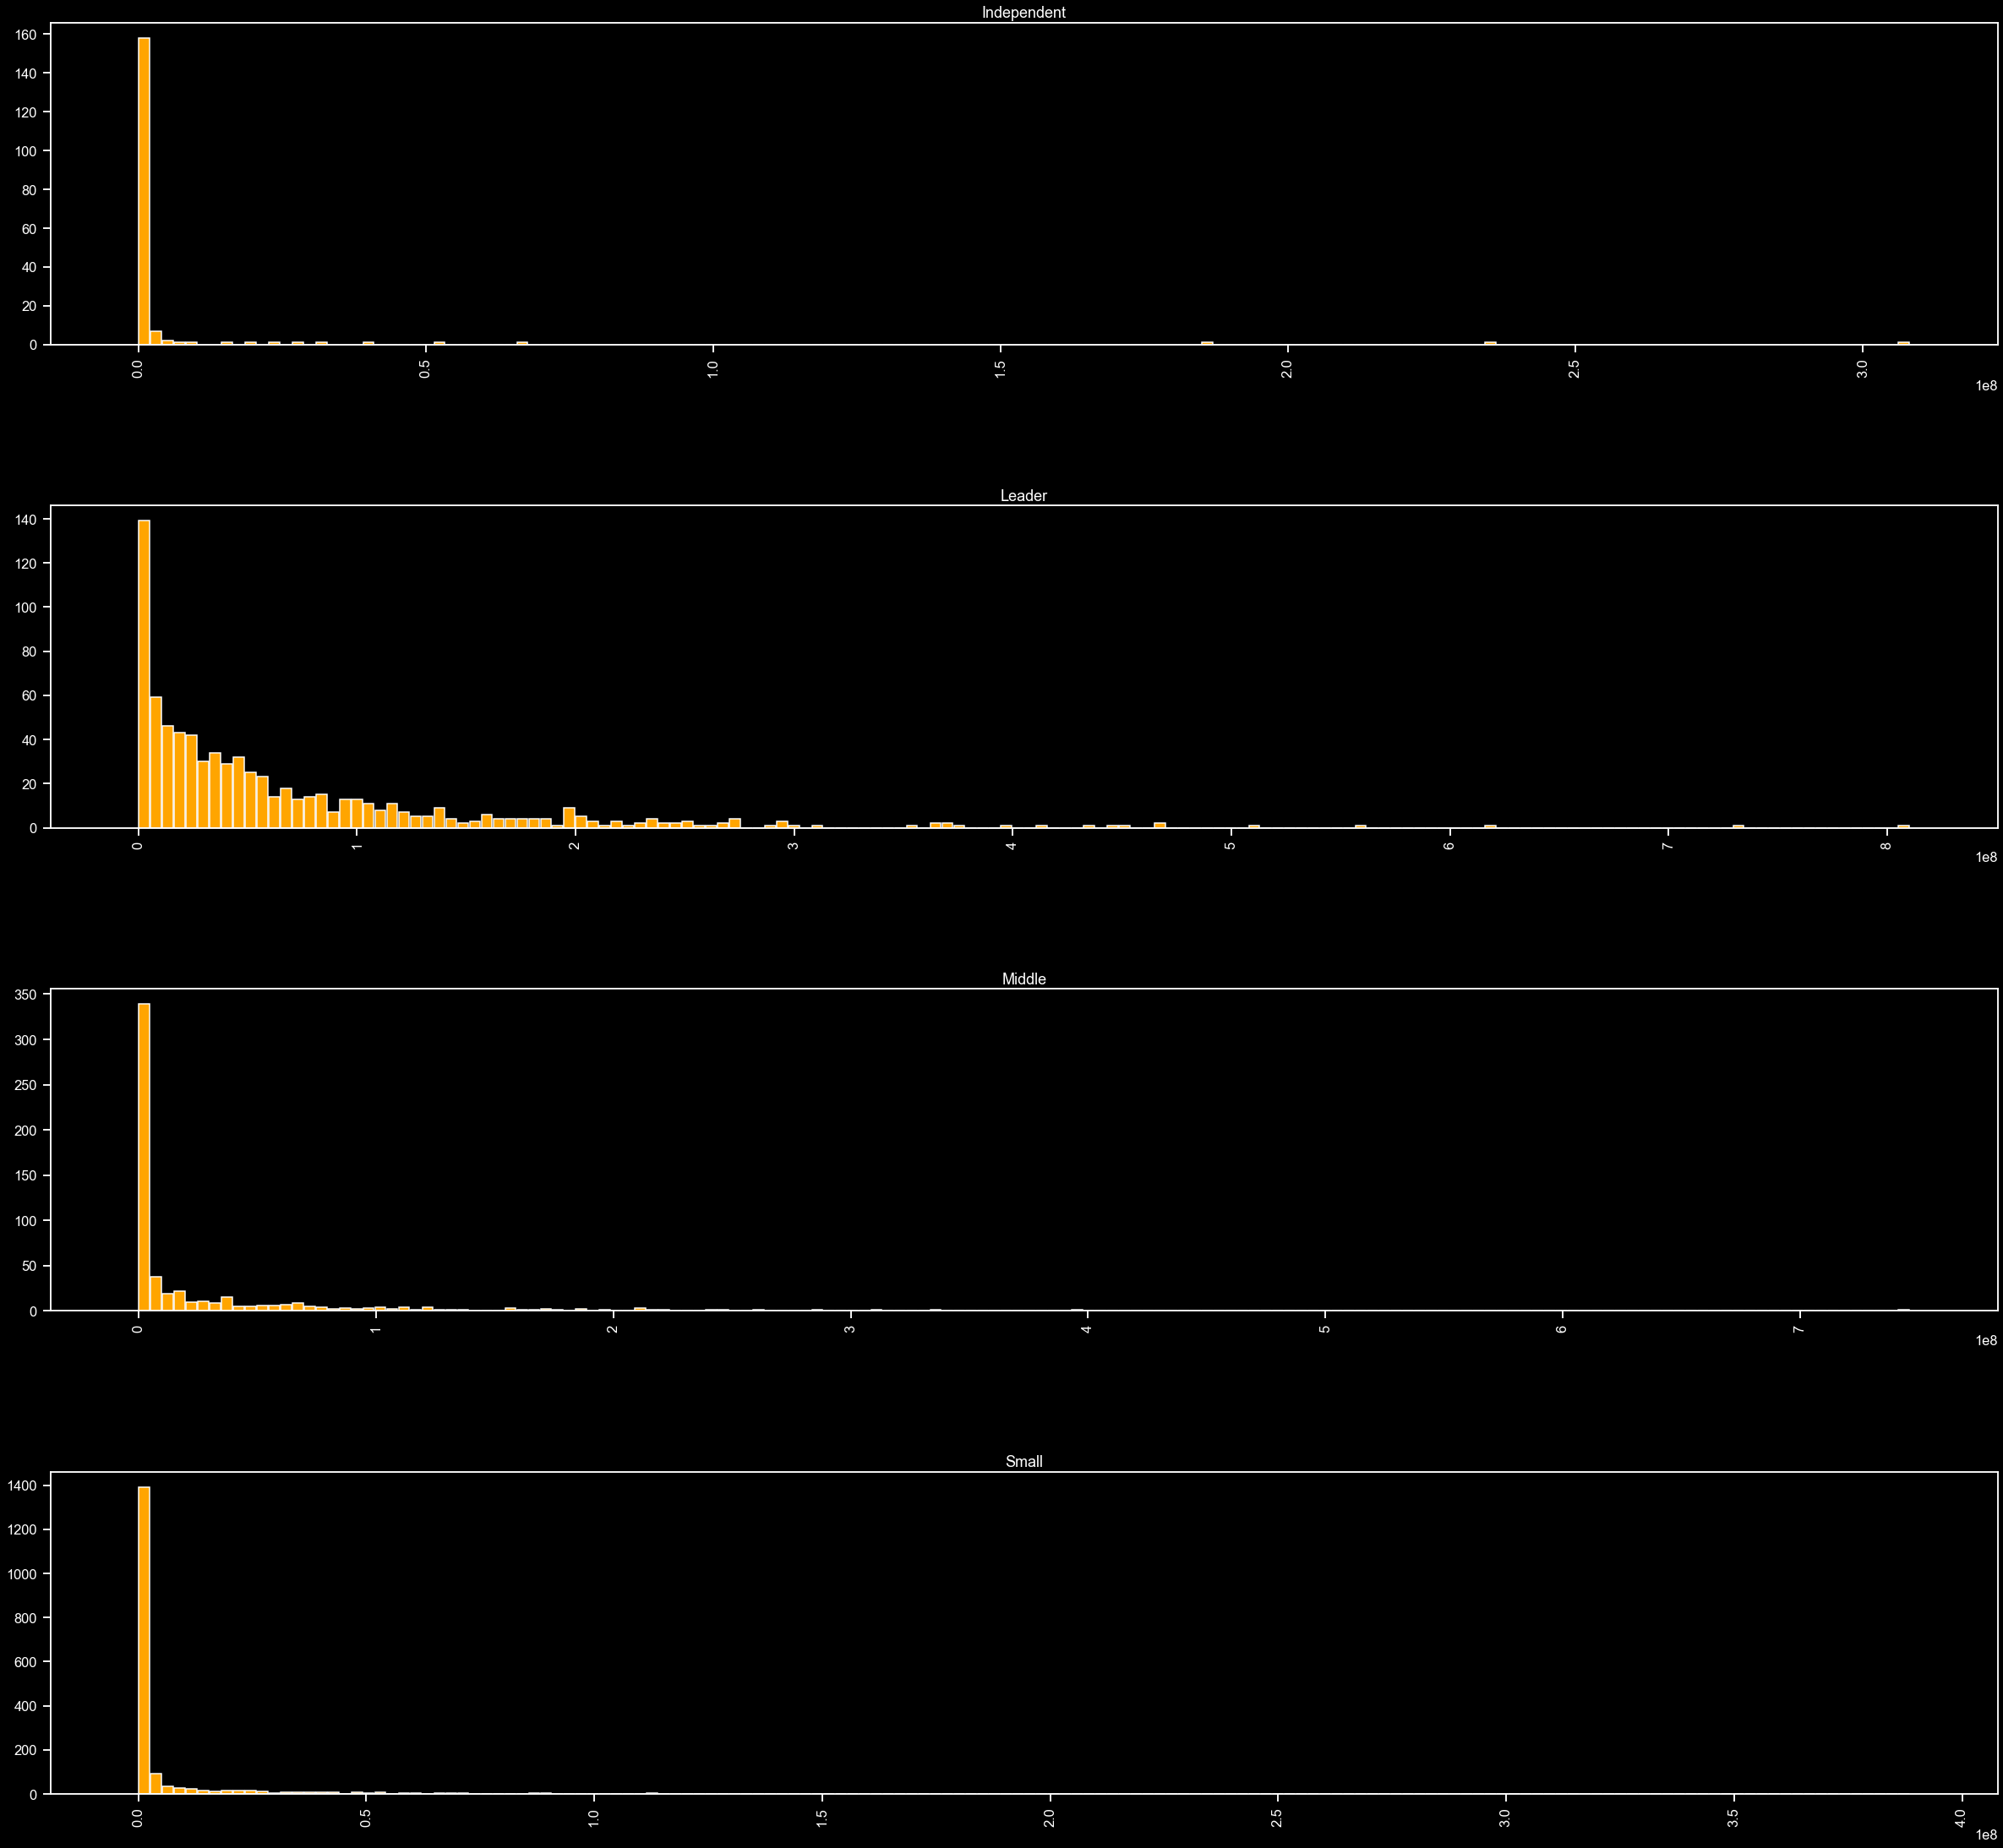

In [24]:
plt.figure(figsize=(40, 30))

dataindependent.hist(column = 'Revenue', by = 'studio', 
                     figsize=(40, 60), bins=150, color = 'Orange',
                    rwidth = 0.9, layout = (6,1), grid=False)
plt.show()

In [25]:
import researchpy as rp
import scipy.stats as stats
rp.summary_cont(dataindependent.groupby(["studio"])["Revenue"])

N          Mean            SD            SE     95% Conf.  \
studio                                                                      
Independent   180  6.049412e+06  3.262841e+07  2.431978e+06  1.250377e+06   
Leader        768  6.742339e+07  9.210534e+07  3.323565e+06  6.089903e+07   
Middle        562  2.494063e+07  5.887106e+07  2.483326e+06  2.006288e+07   
Small        1765  7.426747e+06  2.836195e+07  6.750931e+05  6.102681e+06   

                 Interval  
studio                     
Independent  1.084845e+07  
Leader       7.394776e+07  
Middle       2.981838e+07  
Small        8.750814e+06

Text(0, 0.5, 'Revenue')

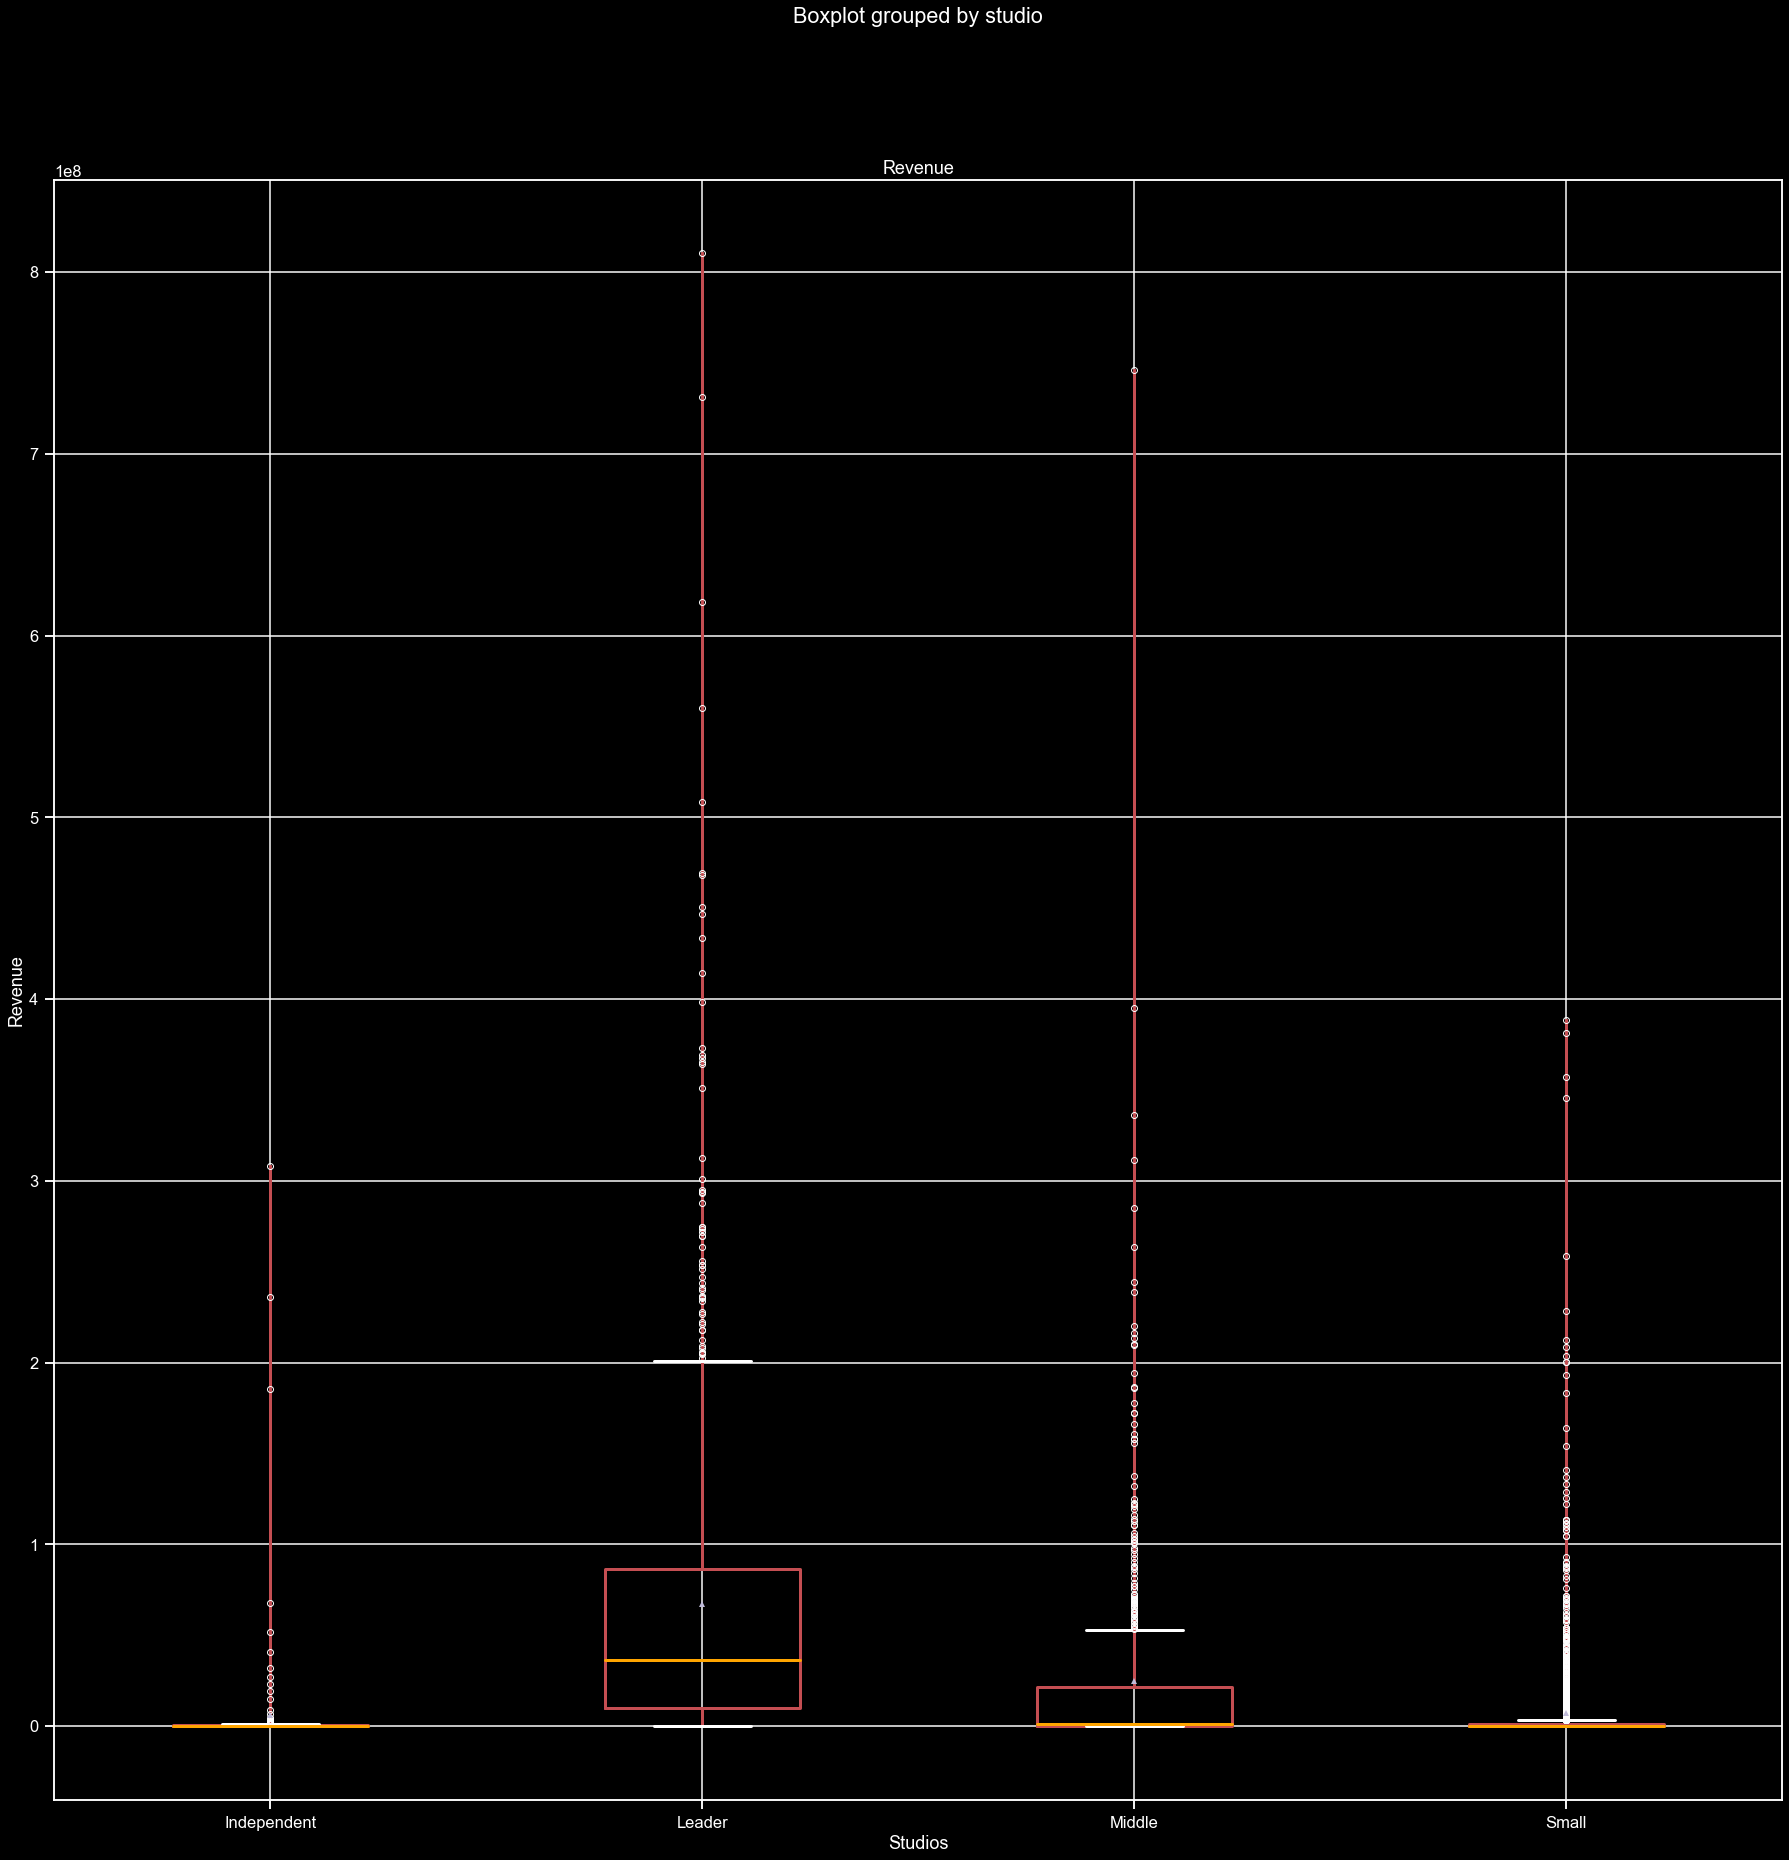

In [26]:
boxplot = dataindependent.boxplot(["Revenue"], by = ["studio"],
                                  boxprops=dict(linestyle='-', linewidth=3, color="r"),
                                  flierprops=dict(linestyle='-', linewidth=3,color="r"),
                                  medianprops=dict(linestyle='-', linewidth=3,color="orange"),
                                  whiskerprops=dict(linestyle='-', linewidth=3,color="r"),
                                  capprops=dict(linestyle='-', linewidth=3),
                     figsize = (30, 30),
                     showmeans = True,
                     notch = False)

boxplot.set_xlabel("Studios")
boxplot.set_ylabel("Revenue")

## Linear model, Ridge,Lasso, Elasticnet

In [27]:
del dataindependent['genres']
datamixed = dataindependent.copy(deep=True)
del dataindependent['studio']

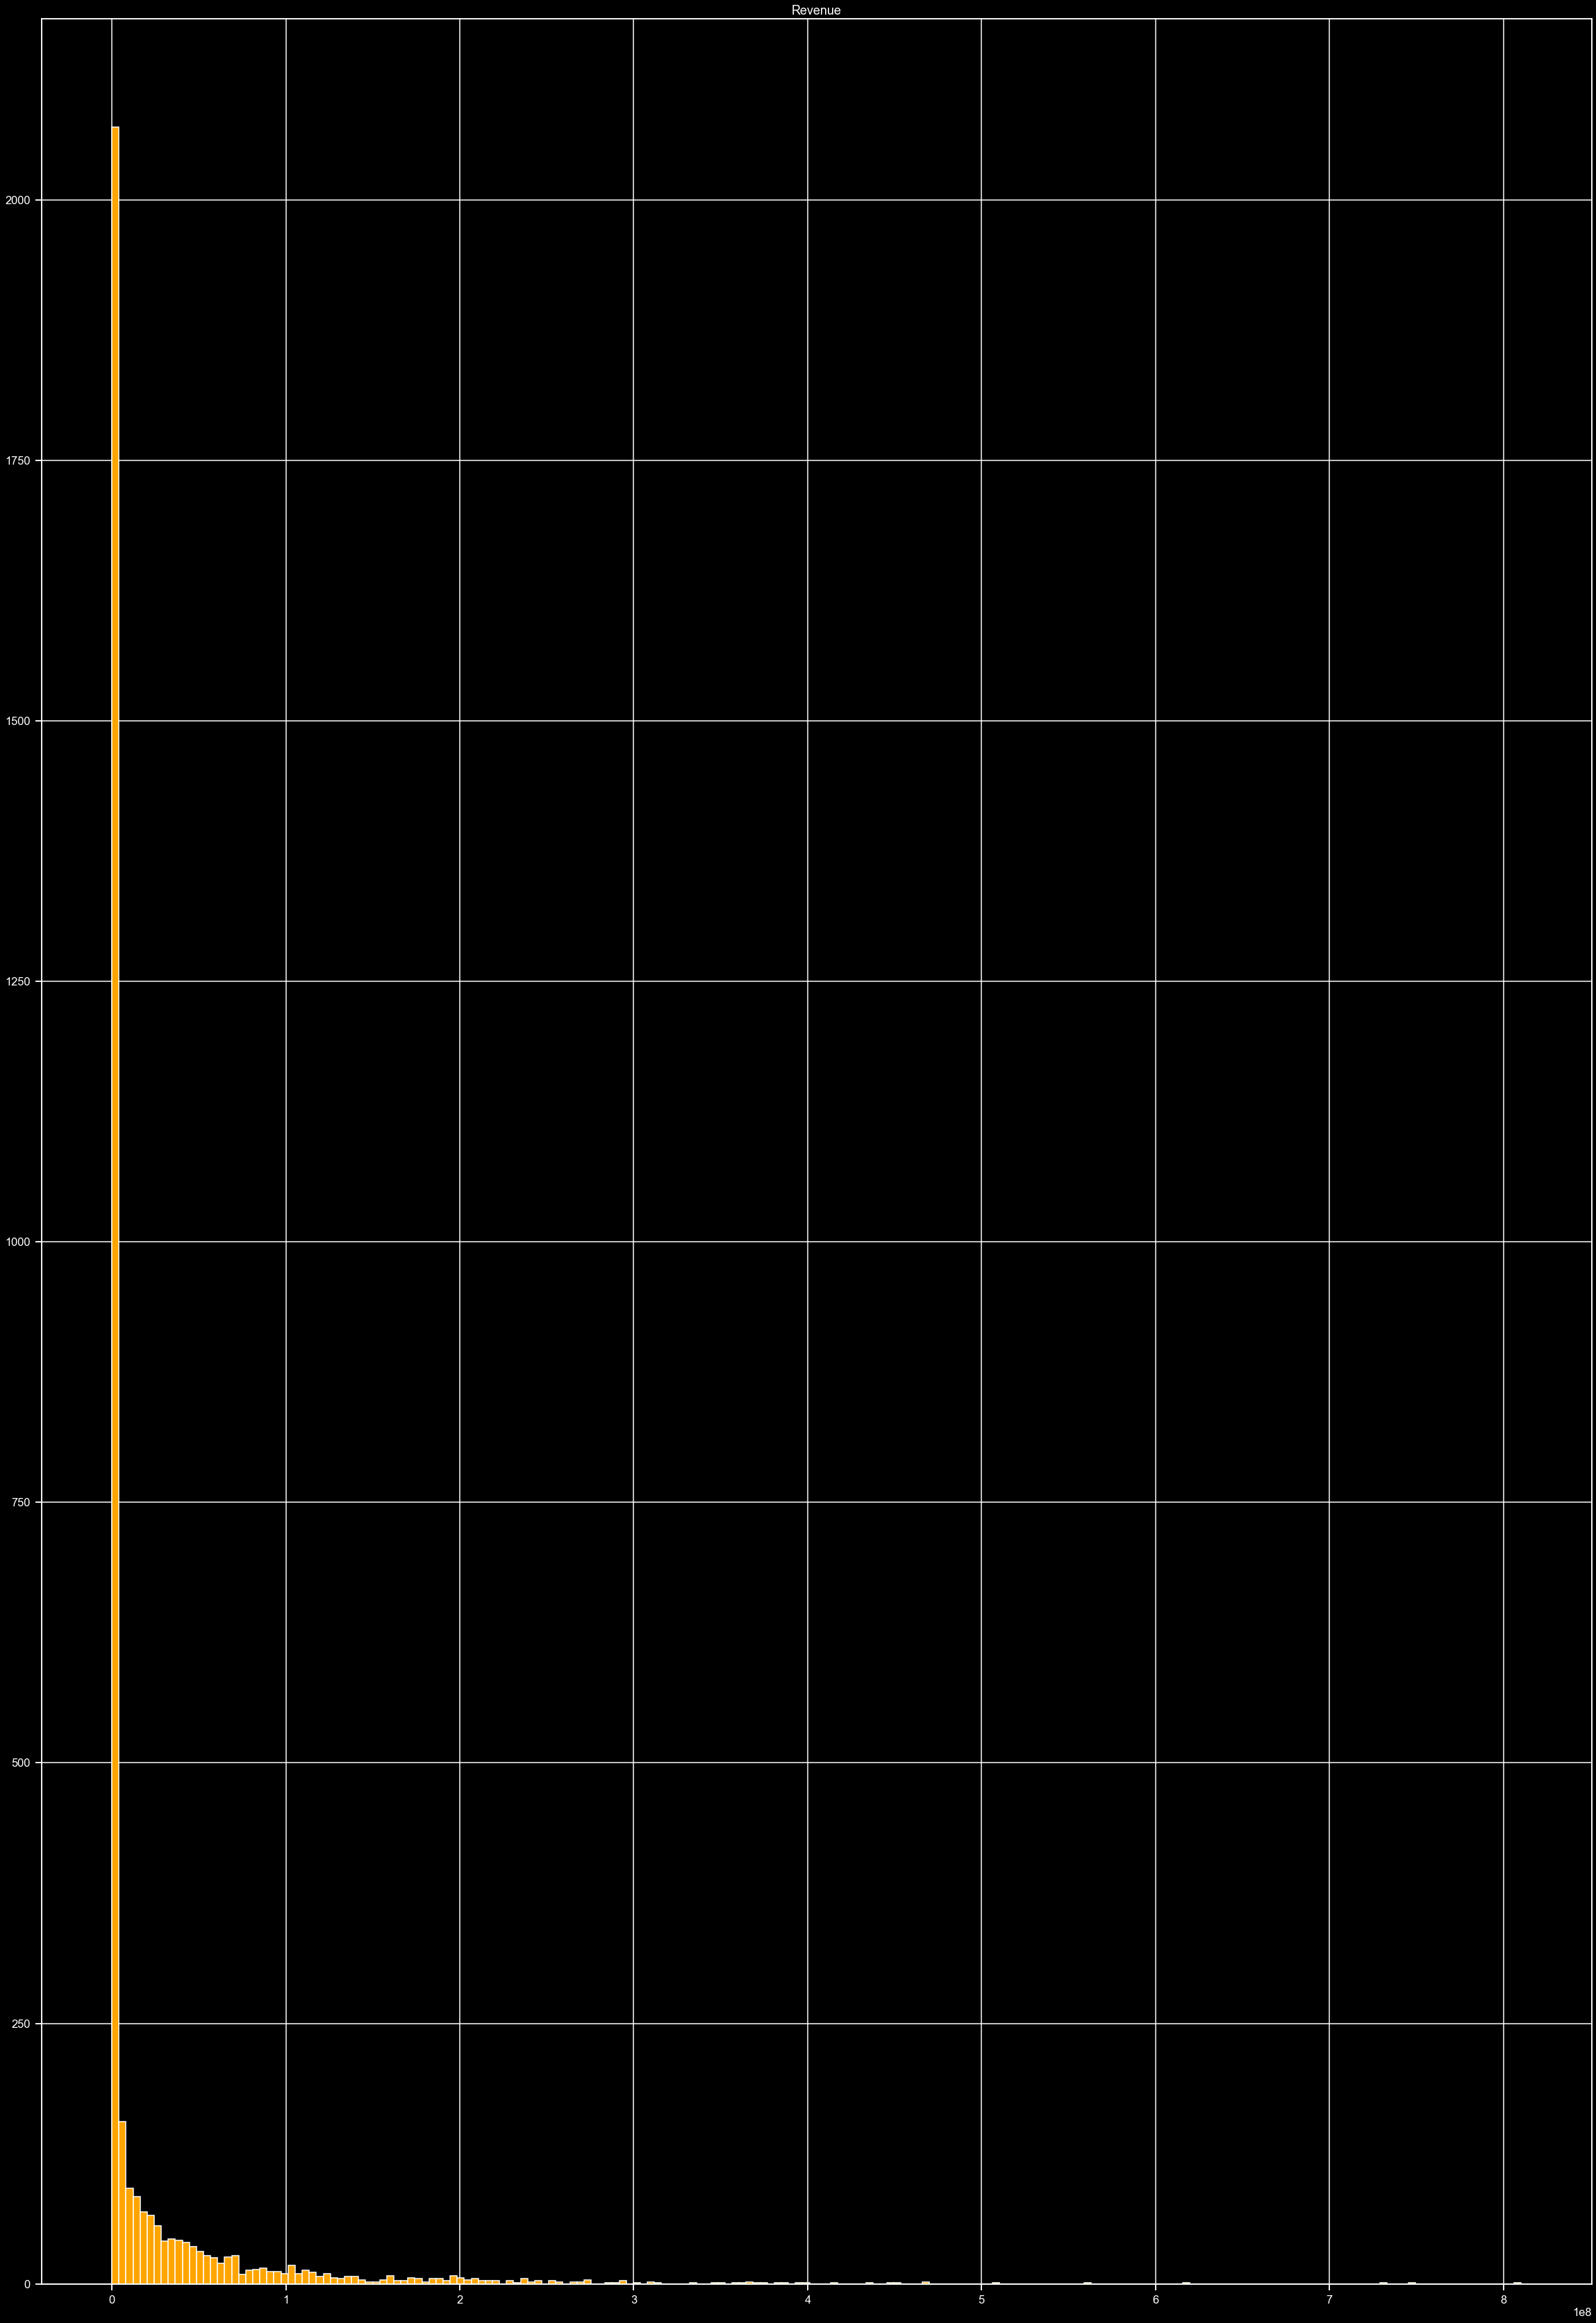

In [28]:
dataindependent.hist(column = 'Revenue', 
                     figsize=(40, 60), bins=200, color = 'Orange')
plt.show()

### Train and Test sets

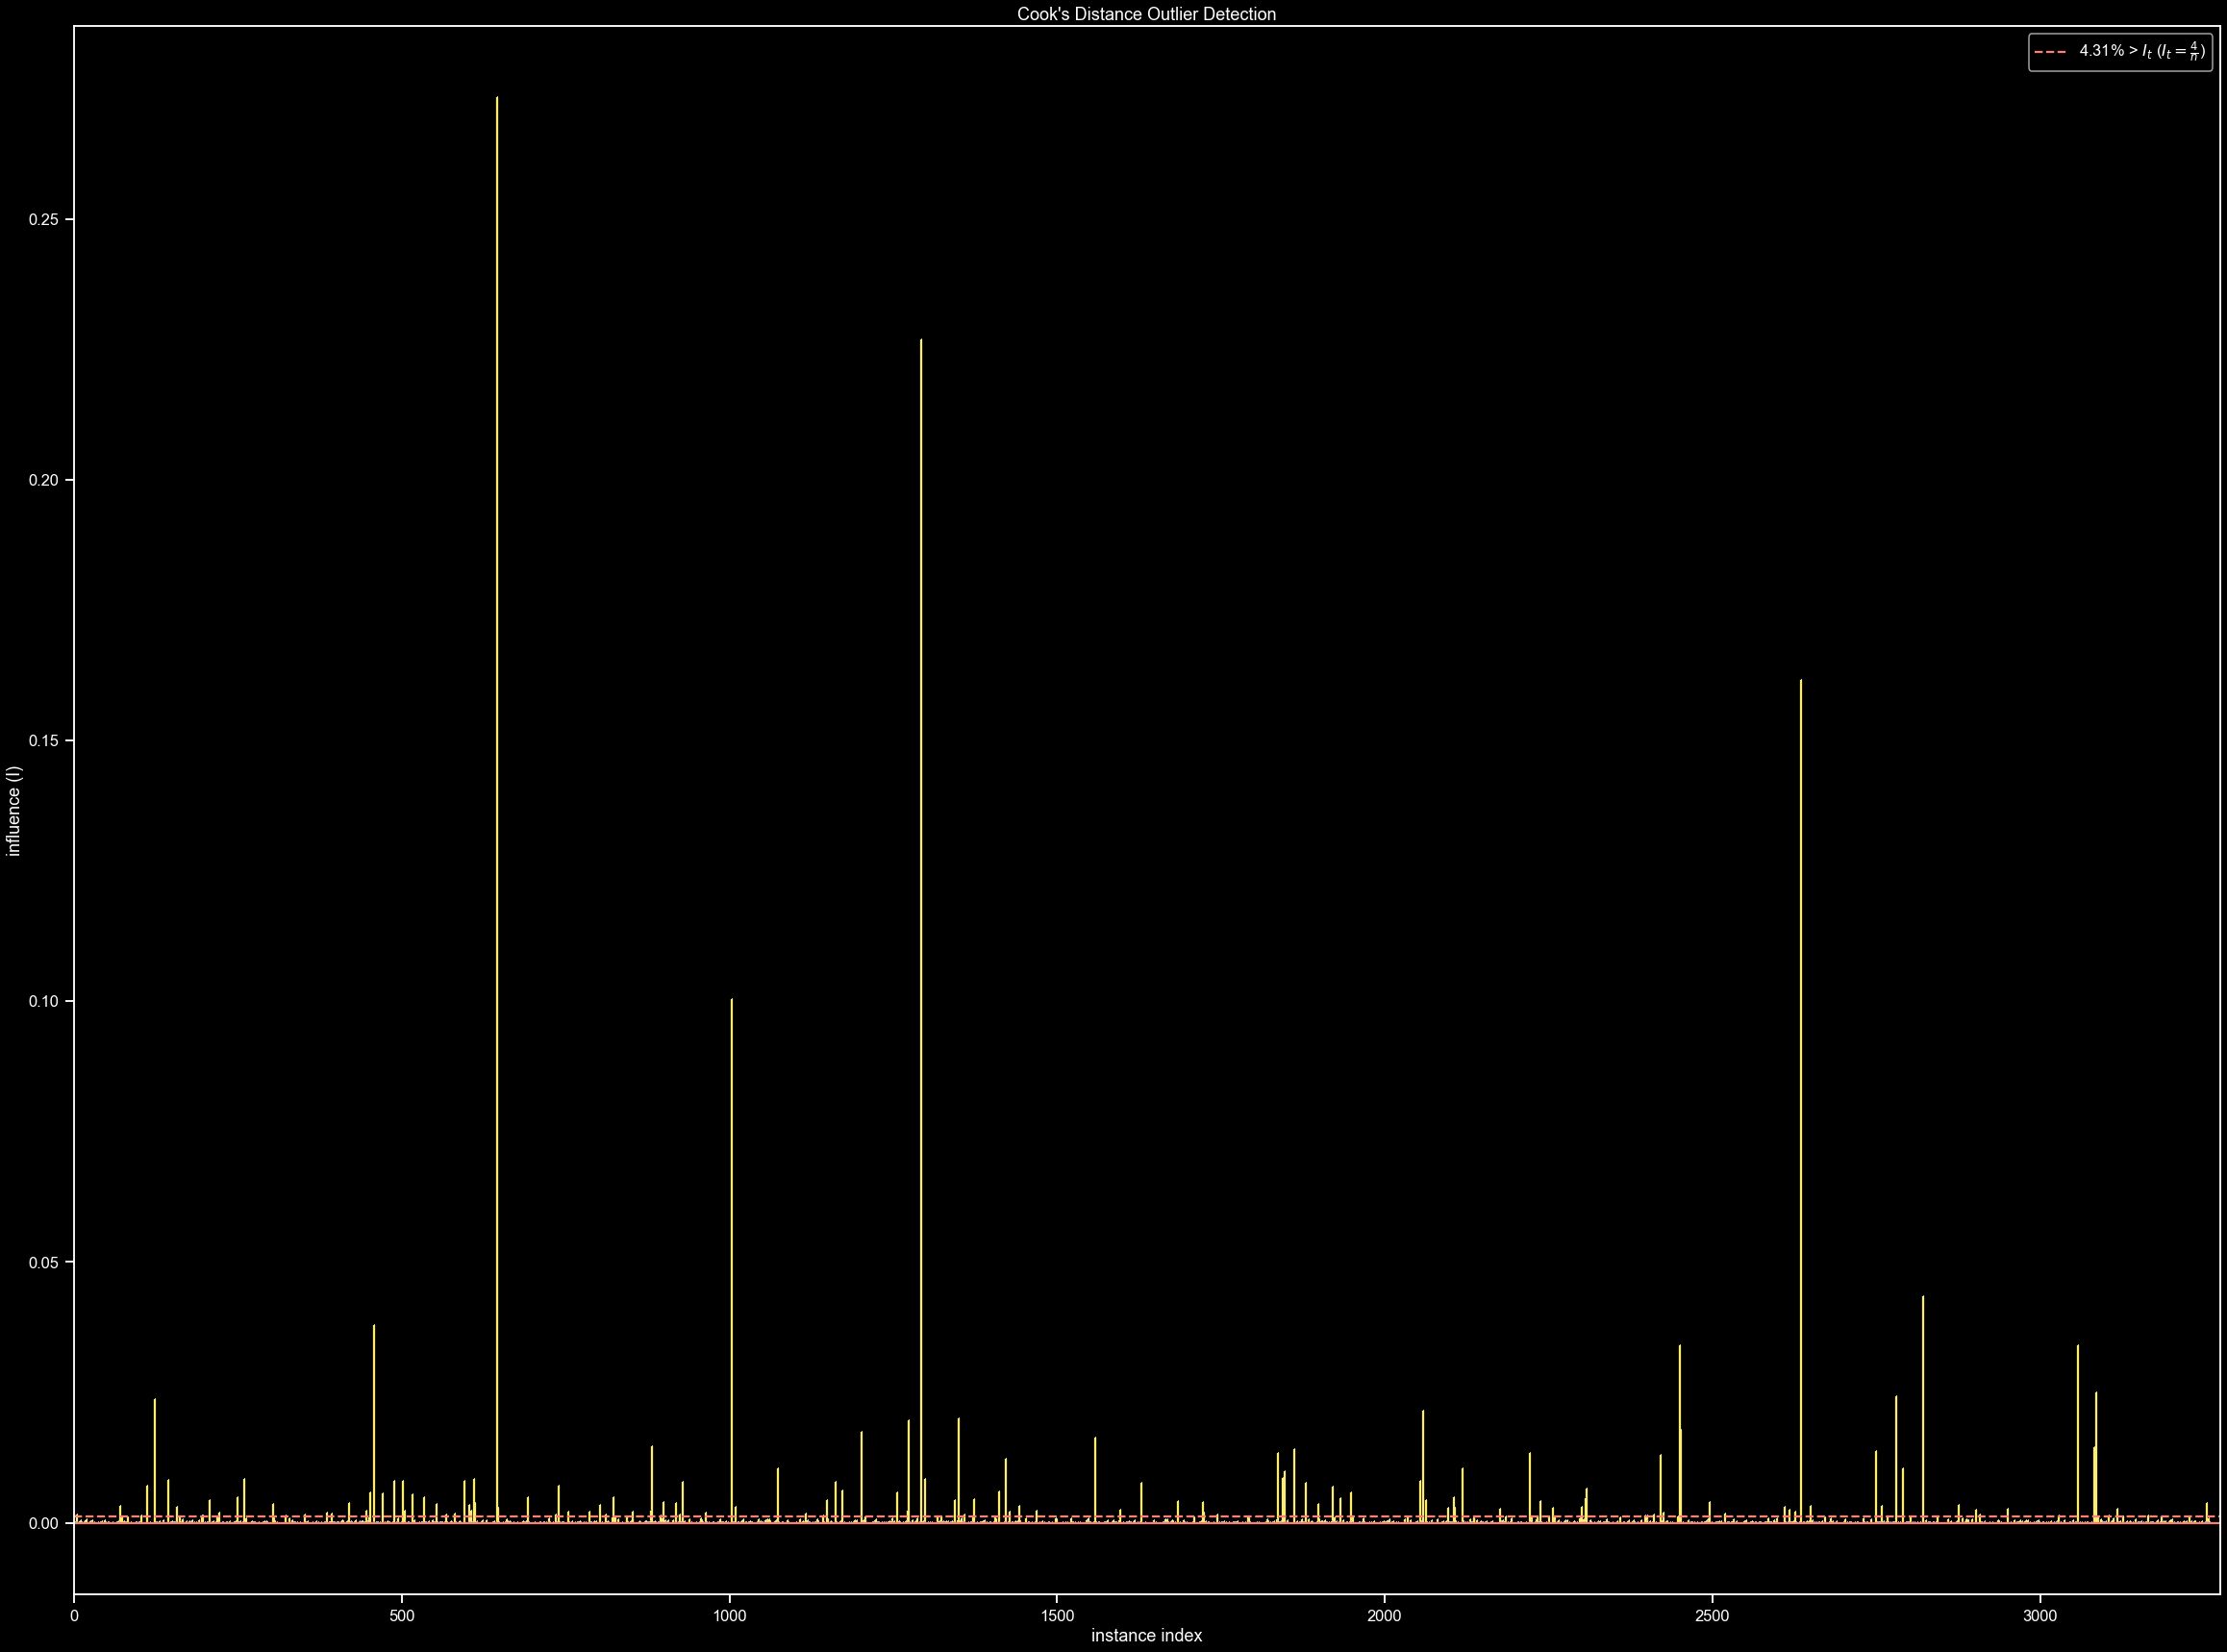

In [29]:
X = dataindependent.drop("Revenue", axis= 1)
Y = dataindependent["Revenue"]
plt.figure(figsize=(40, 30))
cooks_distance(
    X, Y,
    draw_threshold=True,
    linefmt="C9-", markerfmt=","
)
scaler = StandardScaler()
dataindependent2 = scaler.fit_transform(dataindependent)
dataindependentScaled = pd.DataFrame(dataindependent2, columns = dataindependent.columns.values)
X = dataindependentScaled.drop("Revenue", axis= 1)
Y = dataindependentScaled["Revenue"]
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)

### Linear model

In [30]:
def fit_predict_with_features(X_train,Y_train, X_test, selected_features):
    X_train_filtered = X_train[selected_features]
    X_test_filtered = X_test[selected_features]
    
    linear_regression_m = LinearRegression()
    linear_regression_m.fit(X_train_filtered,Y_train)
    y_pred = linear_regression_m.predict(X_test_filtered)
    
    return y_pred

In [31]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
pred_train_lr= lr.predict(Xtrain)
print("RMSE for train")
print(compute_rmse(pred_train_lr,Ytrain))
print("Idem verif")
print(np.sqrt(mean_squared_error(Ytrain,pred_train_lr)))
print("R-squared for train")
print(r2_score(Ytrain, pred_train_lr))

pred_test_lr= lr.predict(Xtest)
print("RMSE for test")
print(np.sqrt(mean_squared_error(Ytest,pred_test_lr))) 
print("R-squared for test")
print(r2_score(Ytest, pred_test_lr))

RMSE for train
0.6928211240734985
Idem verif
0.6928211240734986
R-squared for train
0.49911902868268554
RMSE for test
0.7566328699800361
R-squared for test
0.5069421636374948


### Ridge

In [32]:
from pylab import *
from patsy import dmatrices

dataindependent2= dataindependent.drop("Revenue", axis=1)

vif=pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(dataindependent2.values,i) for i in range(dataindependent2.shape[1])]
vif["features"]=dataindependent2.columns
vif

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


VIF Factor         features
0     1.105090       Unnamed: 0
1     1.366438          ratings
2     1.286844          n_votes
3          inf  production_year
4     1.604161          runtime
5          inf     release_year
6          inf             Time
7     1.417148        Adventure
8     1.736453           Comedy
9     2.002196            Drama
10    1.148506           Family
11    1.038952            Sport
12    1.110310        Biography
13    1.272146            Crime
14    1.397388           Action
15    1.231243         Thriller
16    1.223171          Romance
17    1.133093          Fantasy
18    2.191978      Documentary
19    1.080692            Music
20    1.263633        Animation
21    1.129257           Sci-Fi
22    1.203209           Horror
23    1.024935          Musical
24    1.119215          Mystery
25    1.094423          History
26    1.063871              War
27    1.196963          Western
28    1.141076            Short
29    1.153311        Game-Show
30    1.158906       Reality-TV
31    1.043079        Film-Noir
32         inf            Small
33         inf           Middle
34         inf           Leader
35         inf      Independent

Text(0.5, 1.0, 'Ridge Coefficients vs Regularization Parameters')

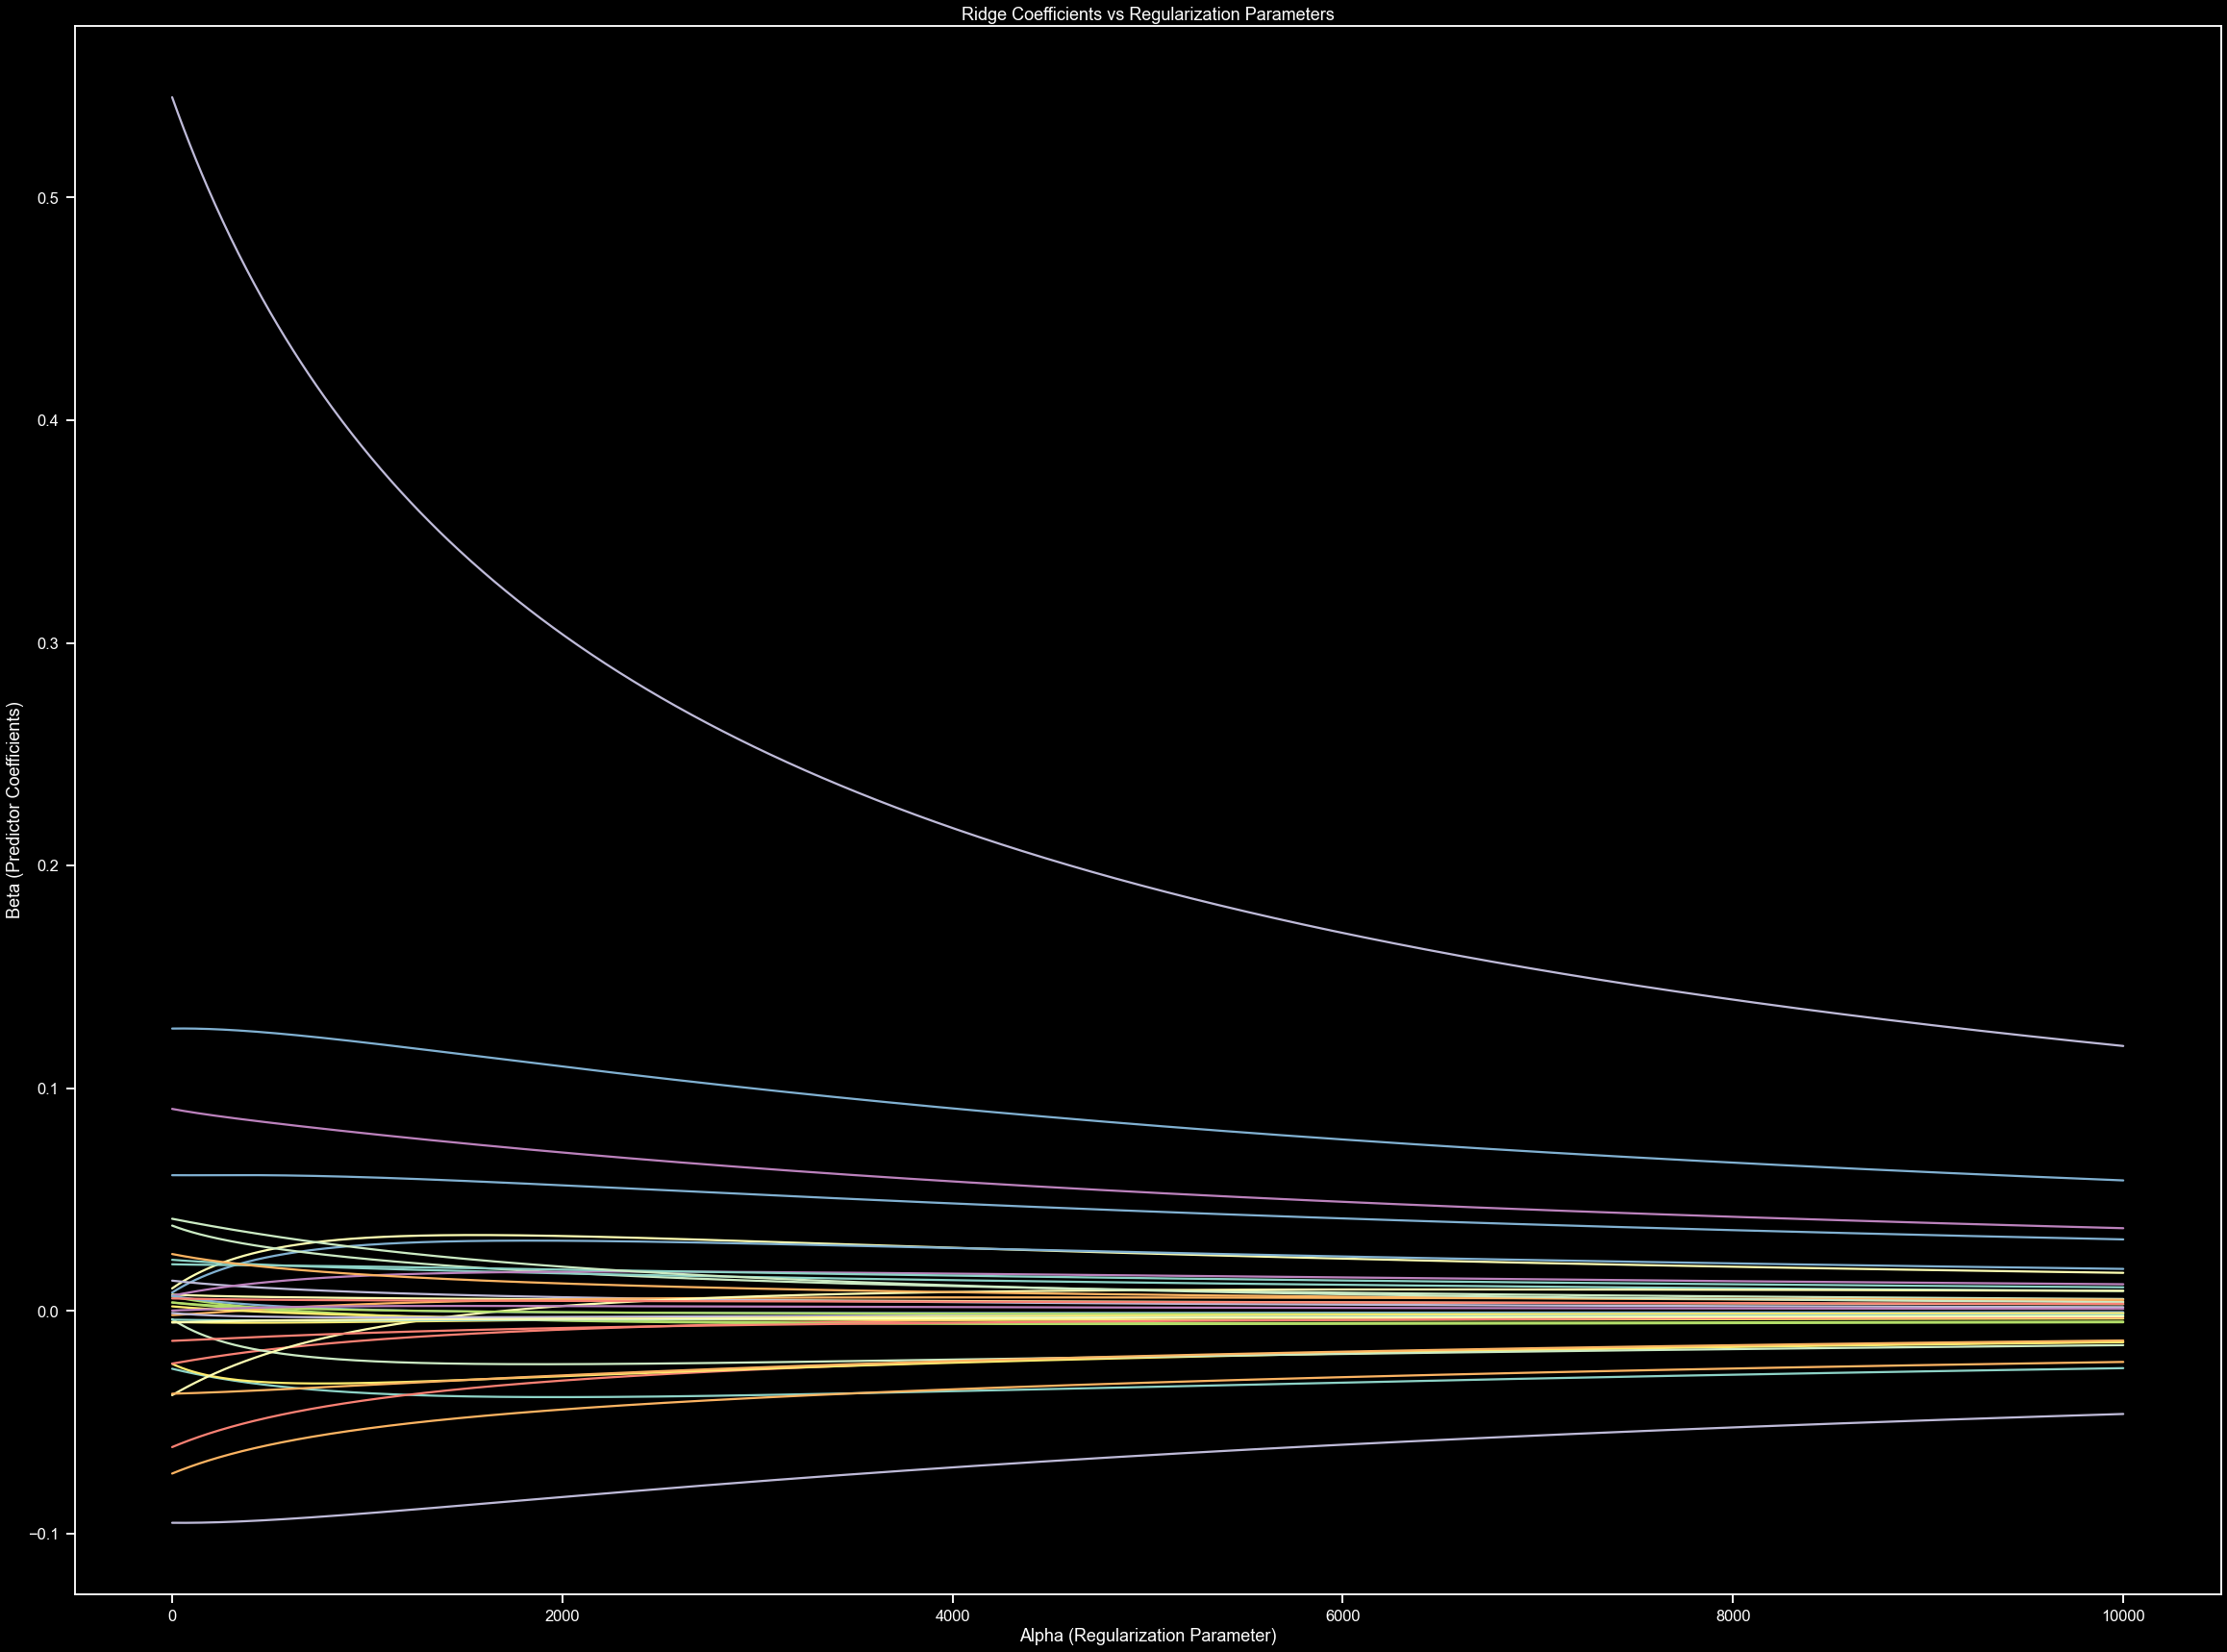

In [33]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
coef=[]
alphas = np.linspace(0.001,10000,1000)

for a in alphas:
  ridgereg=Ridge(alpha=a)
  ridgereg.fit(Xtrain,Ytrain)
  coef.append(ridgereg.coef_)
###Make plot of Beta as a function of Alpha
fig=plt.figure(figsize=(40, 30))
ax=fig.add_subplot(111)
ax.plot(alphas,coef)
ax.set_xlabel('Alpha (Regularization Parameter)')
ax.set_ylabel('Beta (Predictor Coefficients)')
ax.set_title('Ridge Coefficients vs Regularization Parameters')

In [34]:
from statsmodels.tools.tools import pinv_extended
import statsmodels.api as sm
import sklearn, statsmodels

def regression_analysis(X, y, model):
    
    is_statsmodels = False
    is_sklearn = False
    
    # check for accepted linear models
    if type(model) in [sklearn.linear_model._base.LinearRegression,
                       sklearn.linear_model._ridge.Ridge,
                       sklearn.linear_model._ridge.RidgeCV,
                       sklearn.linear_model._coordinate_descent.Lasso,
                       sklearn.linear_model._coordinate_descent.LassoCV,
                       sklearn.linear_model._coordinate_descent.ElasticNet,
                       sklearn.linear_model._coordinate_descent.ElasticNetCV,
                      ]:
        is_sklearn = True
    elif type(model) in [statsmodels.regression.linear_model.OLS, 
                         statsmodels.base.elastic_net.RegularizedResults,
                        ]:
        is_statsmodels = True
    else:
        print("Only linear models are supported!")
        return None
    
    
    
    has_intercept = False
    
    if is_statsmodels and all(np.array(X)[:,0]==1):
        # statsmodels add_constant has been used already
        has_intercept = True  
    elif is_sklearn and model.intercept_:
        has_intercept = True
        

    
    if is_statsmodels:
        # add_constant has been used already
        x = X
        model_params = model.params
    else: # sklearn model
        if has_intercept:
            x = sm.add_constant(X)
            model_params = np.hstack([np.array([model.intercept_]), model.coef_])
        else:
            x = X
            model_params = model.coef_
        
    #y = np.array(y).ravel()
    
    # define the OLS model
    olsModel = sm.OLS(y, x)
    
    pinv_wexog,_ = pinv_extended(x)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    
    
    return sm.regression.linear_model.OLSResults(olsModel, model_params, normalized_cov_params)
    

In [35]:
Rid = Ridge(alpha=0.01, max_iter=100000, tol=1e-8, fit_intercept=True, normalize=True)
Rid.fit(Xtrain, Ytrain)
Rid.get_params(deep=True)
result = regression_analysis(Xtrain, Ytrain, Rid)
result.summary()

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Revenue   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     75.80
Date:                Sun, 04 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:53:46   Log-Likelihood:                -2755.8
No. Observations:                2620   AIC:                             5582.
Df Residuals:                    2585   BIC:                             5787.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0108      0.014     -0.789      0.430      -0.038       0.016
Unnamed: 0         -0.0265      0.014     -1.846      0.065      -0.055       0.002
ratings             0.0118      0.016      0.742      0.458      -0.019       0.043
n_votes             0.5384      0.015     35.484      0.000       0.509       0.568
production_year    -0.0597      0.009     -6.556      0.000      -0.078      -0.042
runtime             0.0097      0.017      0.580      0.562      -0.023       0.043
release_year       -0.0724      0.011     -6.318      0.000      -0.095      -0.050
Time                0.0040      0.011      0.375      0.707      -0.017       0.025
Adventure           0.0904      0.017      5.415      0.000       0.058       0.123
Comedy              0.0375      0.018      2.088      0.037       0.002       0.073
Drama              -0.0248      0.019     -1.284      0.199      -0.063       0.013
Family              0.0228      0.015      1.528      0.127      -0.006       0.052
Sport               0.0073      0.014      0.518      0.605      -0.020       0.035
Biography           0.0134      0.014      0.940      0.347      -0.015       0.041
Crime              -0.0232      0.015     -1.508      0.132      -0.053       0.007
Action              0.0610      0.016      3.798      0.000       0.029       0.092
Thriller           -0.0017      0.015     -0.112      0.911      -0.031       0.028
Romance             0.0060      0.015      0.397      0.691      -0.024       0.036
Fantasy             0.0073      0.014      0.514      0.607      -0.021       0.035
Documentary        -0.0051      0.020     -0.256      0.798      -0.044       0.034
Music               0.0019      0.014      0.136      0.892      -0.025       0.029
Animation           0.0209      0.016      1.342      0.180      -0.010       0.051
Sci-Fi             -0.0365      0.015     -2.486      0.013      -0.065      -0.008
Horror             -0.0011      0.015     -0.072      0.943      -0.031       0.029
Musical            -0.0133      0.014     -0.961      0.337      -0.040       0.014
Mystery             0.0064      0.014      0.457      0.648      -0.021       0.034
History             0.0251      0.014      1.822      0.069      -0.002       0.052
War                 0.0036      0.014      0.261      0.794      -0.024       0.031
Western             0.0003      0.016      0.018      0.986      -0.032       0.032
Short               0.0410      0.014      2.917      0.004       0.013       0.068
Game-Show          -0.0049      0.013     -0.368      0.713      -0.031       0.021
Reality-TV         -0.0039      0.016     -0.254      0.800      -0.034       0.027
Film-Noir          -0.0051      0.012     -0.408      0.683      -0.030       0.019
Small              -0.0947      0.009    -10.779      0.000

In [36]:
print(result.aic)

5581.6031922785605


### LASSO

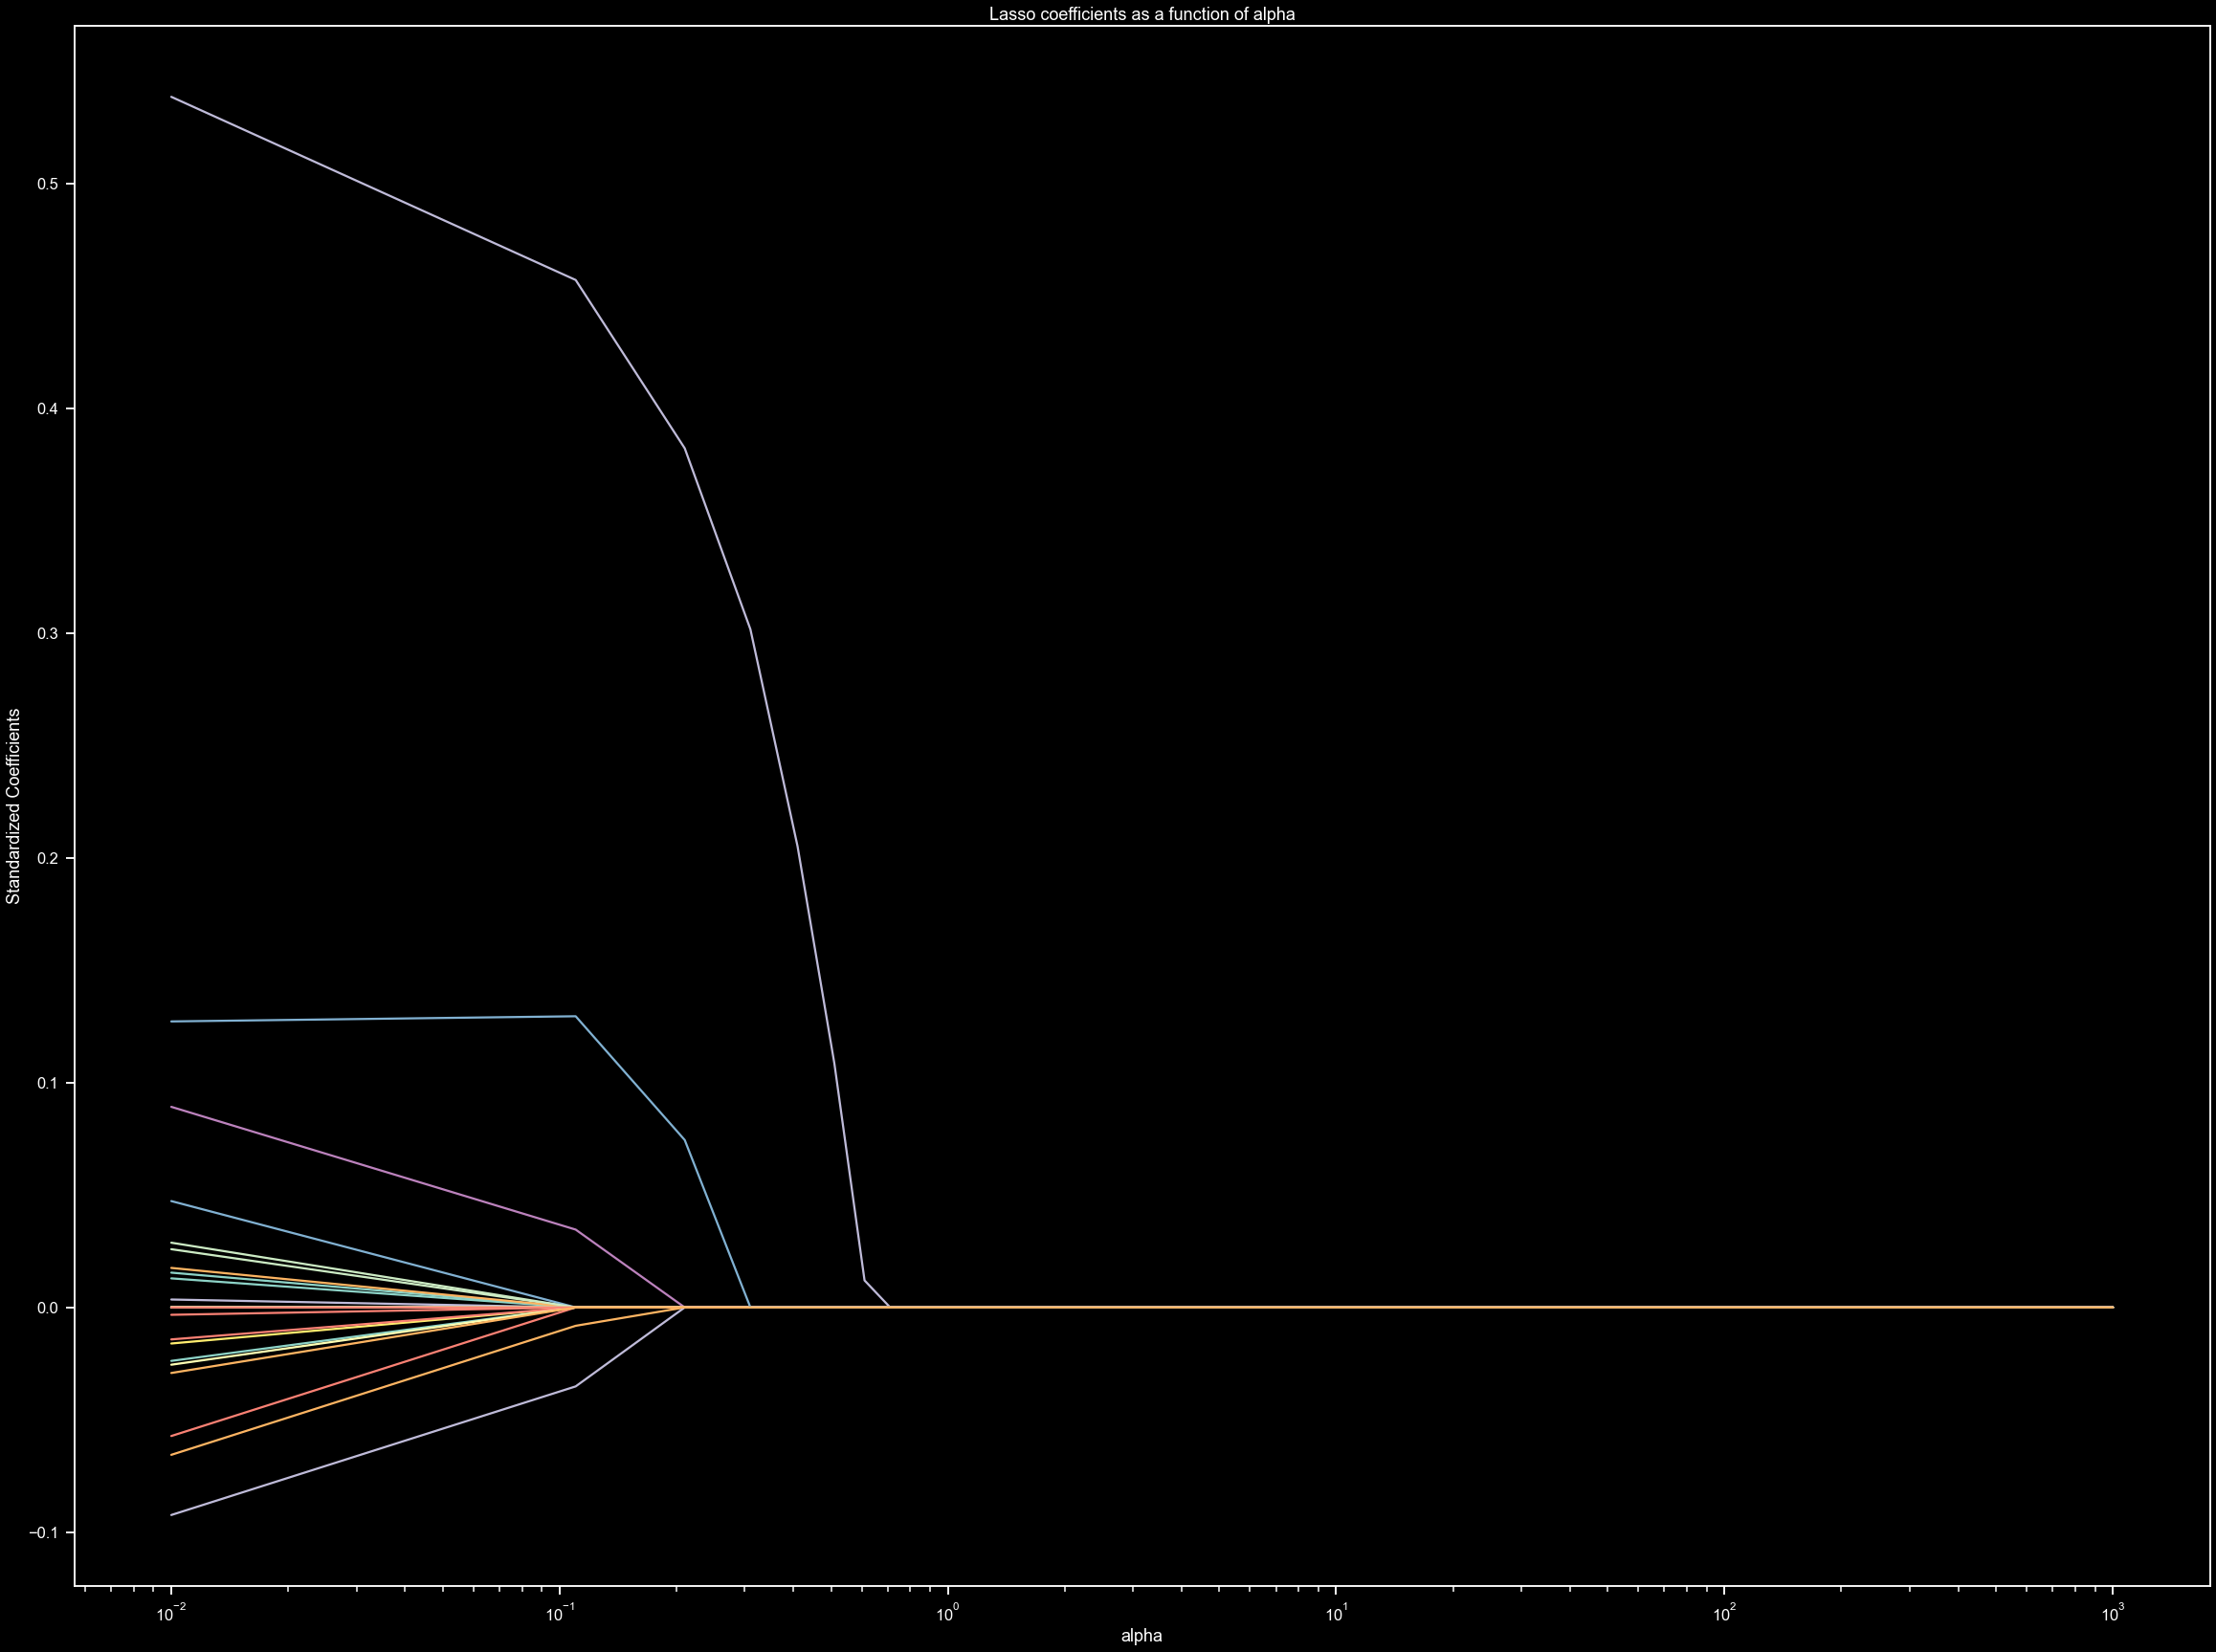

In [37]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold

alphas = np.linspace(0.01,1000,10000)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xtrain, Ytrain)
    coefs.append(lasso.coef_)
fig=plt.figure(figsize=(40, 30))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

In [38]:

# define model
model = LassoCV(cv=20, max_iter=10000, random_state=0)
# fit model
model.fit(Xtrain, Ytrain)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)

alpha: 0.010145


In [39]:


LAS = Lasso(alpha=0.01)
LAS.fit(Xtrain, Ytrain)
print('R squared training set', round(LAS.score(Xtrain, Ytrain)*100, 2))
print('R squared test set', round(LAS.score(Xtest, Ytest)*100, 2))

R squared training set 49.73
R squared test set 50.31


In [40]:
from sklearn.metrics import mean_squared_error

# Training data
pred_train = LAS.predict(Xtrain)
mse_train = mean_squared_error(Ytrain, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data
pred = LAS.predict(Xtest)
mse_test =mean_squared_error(Ytest, pred)
print('MSE test set', round(mse_test, 2))

MSE training set 0.48
MSE test set 0.58


In [41]:
print(pd.DataFrame(list(zip(LAS.coef_, X))))

           0                1
0  -0.023799       Unnamed: 0
1   0.000000          ratings
2   0.538687          n_votes
3  -0.057227  production_year
4   0.000000          runtime
5  -0.065599     release_year
6   0.000000             Time
7   0.089253        Adventure
8   0.025903           Comedy
9  -0.016061            Drama
10  0.015473           Family
11  0.000000            Sport
12  0.003516        Biography
13 -0.014239            Crime
14  0.047318           Action
15 -0.000000         Thriller
16  0.000000          Romance
17  0.000000          Fantasy
18 -0.000000      Documentary
19  0.000000            Music
20  0.012925        Animation
21 -0.025497           Sci-Fi
22 -0.000000           Horror
23 -0.003290          Musical
24  0.000000          Mystery
25  0.017575          History
26  0.000000              War
27  0.000000          Western
28  0.028799            Short
29 -0.000000        Game-Show
30 -0.000000       Reality-TV
31 -0.000000        Film-Noir
32 -0.0923

(0.000433075848213867,
 0.8640999194643113,
 0.07128344870588874,
 2.1765333175301205)

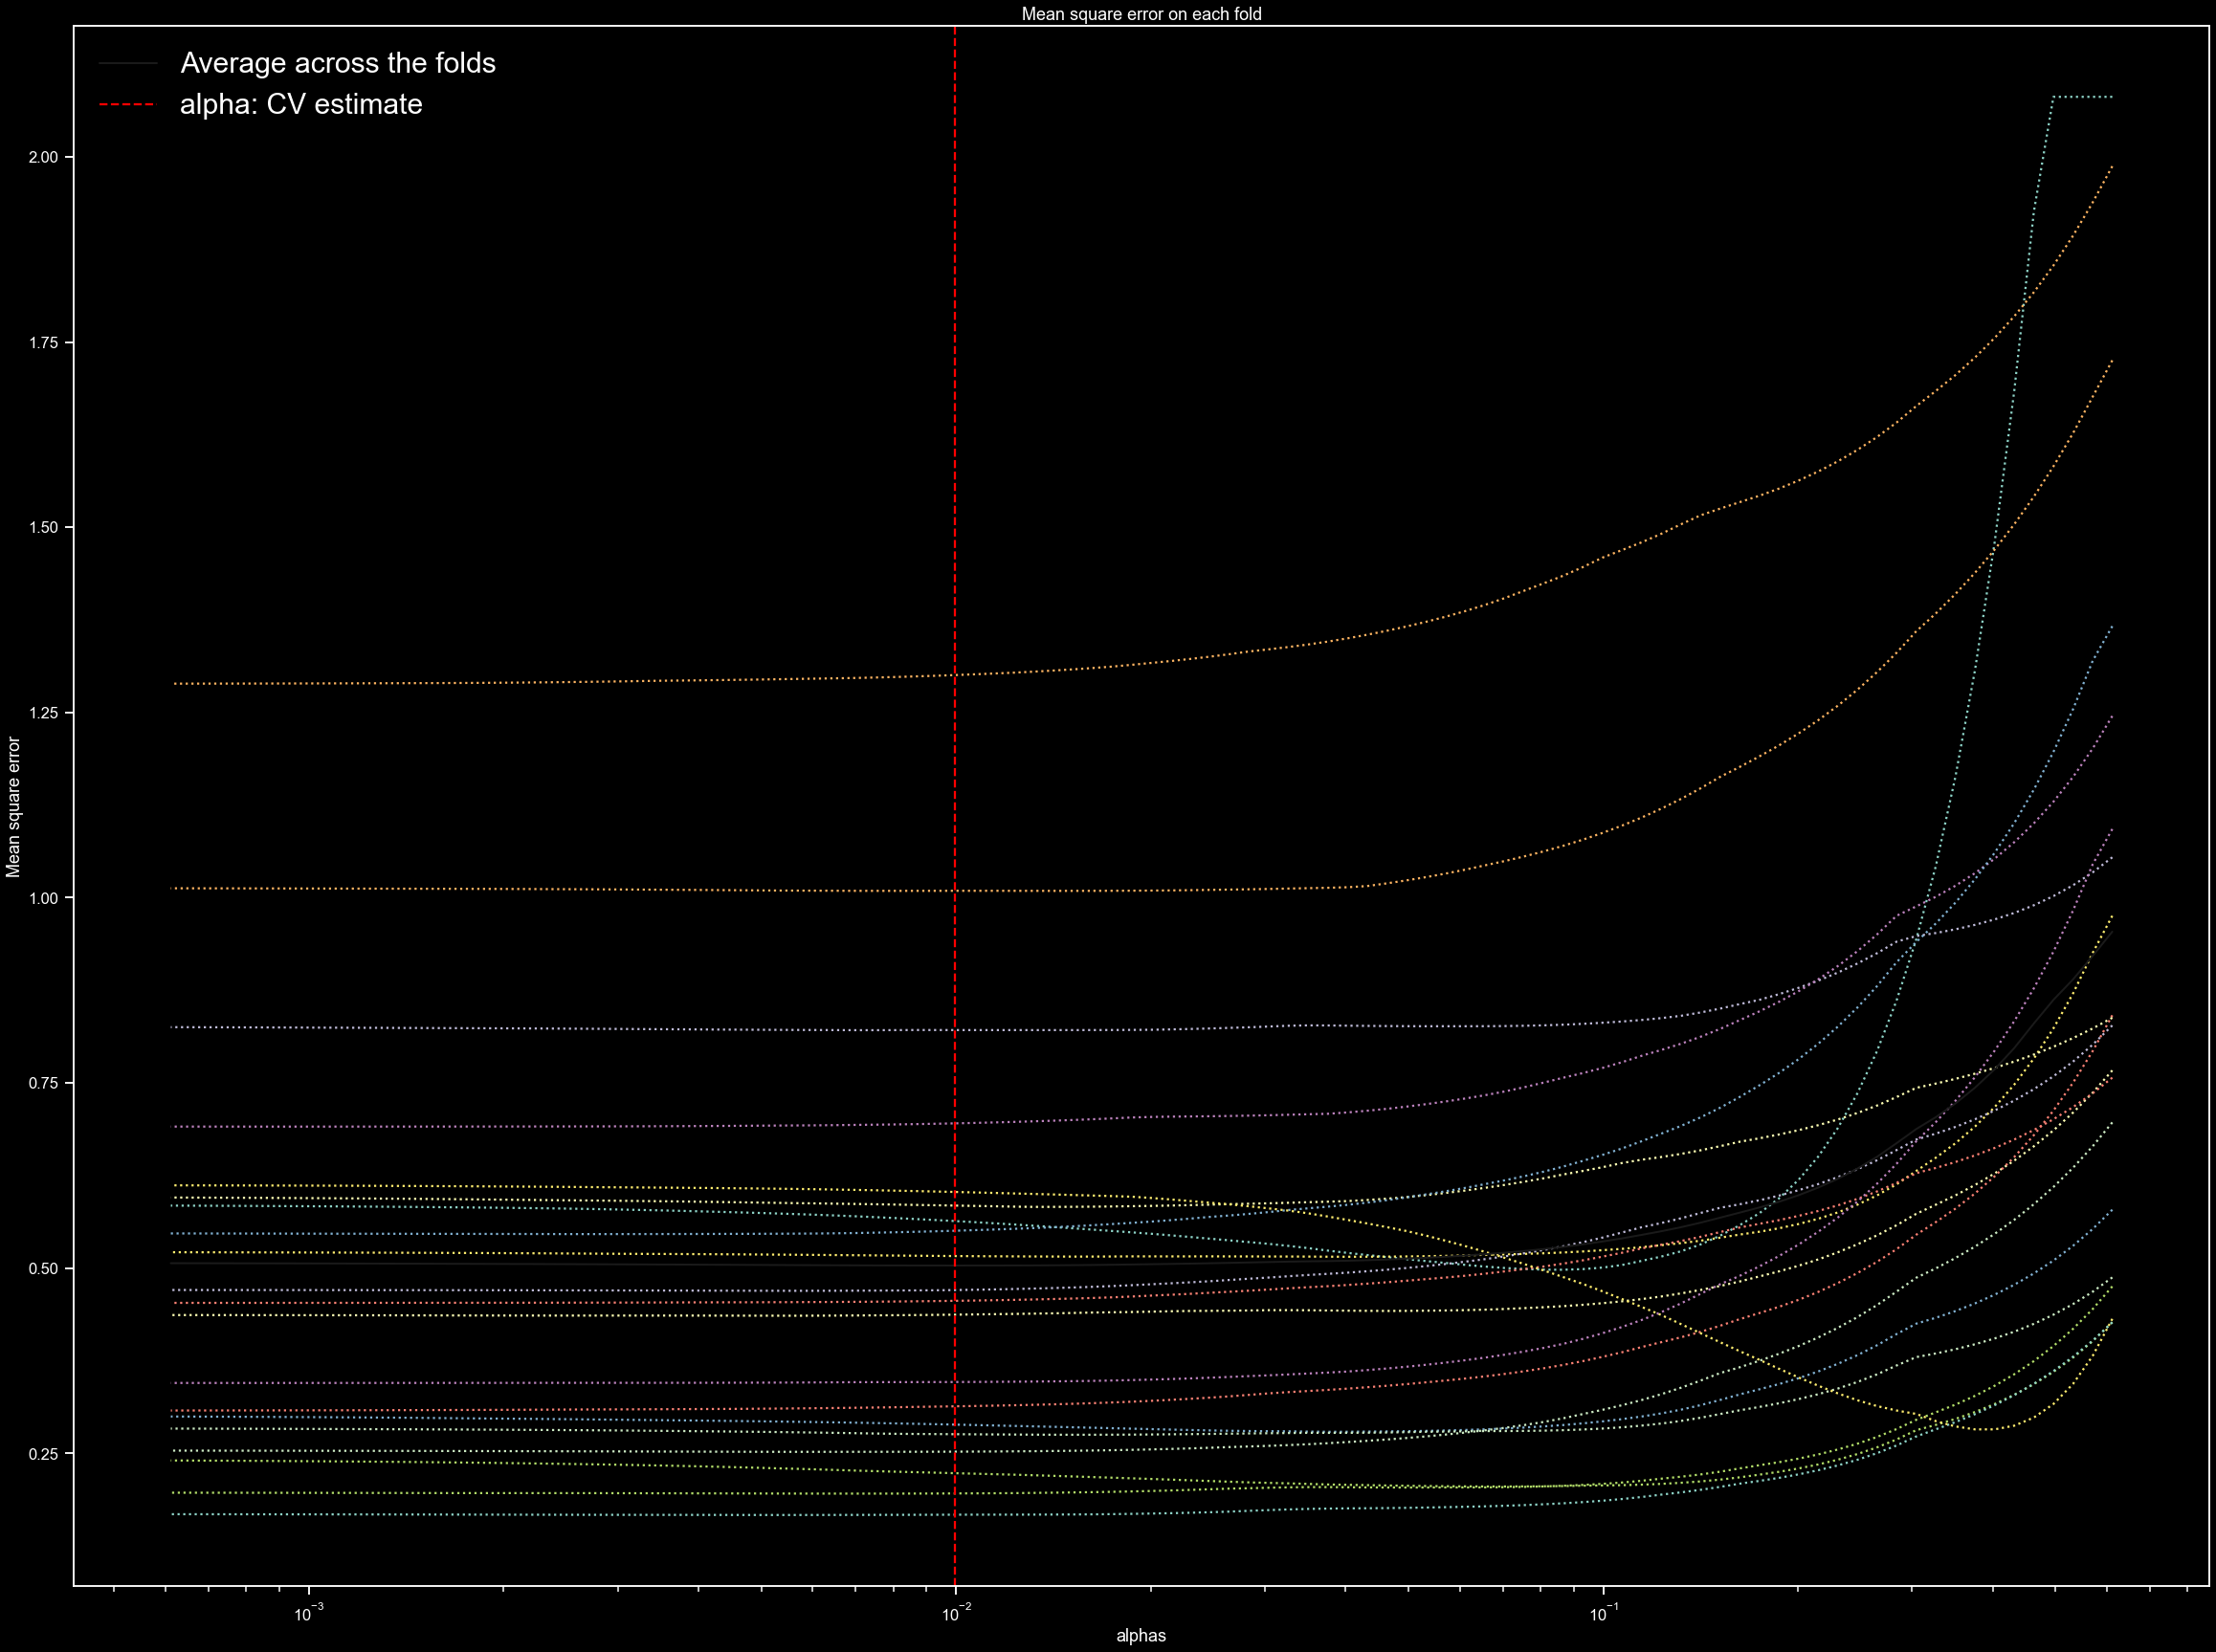

In [42]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), LassoCV(cv=20)).fit(Xtrain, Ytrain)

lasso = model[-1]
fig=plt.figure(figsize=(40, 30))
plt.semilogx(lasso.alphas_, lasso.mse_path_, ":")
plt.plot(
    lasso.alphas_ ,
    lasso.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2
)
plt.axvline(
    lasso.alpha_, linestyle="--", color="Red", label="alpha: CV estimate"
)
plt.legend(fontsize=30)
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

### Elastic Net

In [43]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Elastic = ElasticNet(random_state=0)
model = ElasticNet()
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1, 0.01)
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
results = search.fit(Xtrain, Ytrain)

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.993e+02, tolerance: 1.775e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.147e+02, tolerance: 2.079e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.767e+02, tolerance: 2.196e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.415e+02, tolerance: 2.010e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.407e+02, tolerance: 2.196e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.212e+02, tolerance: 2.067e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.371e+02, tolerance: 2.069e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.352e+02, tolerance: 1.973e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.214e+02, tolerance: 1.775e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.793e+02, tolerance: 2.010e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e+02, tolerance: 2.010e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.422e+01, tolerance: 2.011e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.741e+01, tolerance: 2.196e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.422e+01, tolerance: 2.057e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.973e+01, tolerance: 2.057e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.233e+01, tolerance: 2.196e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.485e+01, tolerance: 1.973e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.211e+01, tolerance: 2.069e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.994e+01, tolerance: 2.010e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.733e+01, tolerance: 1.775e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.320e+01, tolerance: 1.977e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.744e+01, tolerance: 1.947e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.032e+01, tolerance: 1.973e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.394e+01, tolerance: 1.946e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.204e+01, tolerance: 1.946e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.742e+01, tolerance: 2.011e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.519e+01, tolerance: 2.067e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.978e+01, tolerance: 2.057e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.880e+01, tolerance: 1.977e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.851e+01, tolerance: 2.165e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.701e+01, tolerance: 2.079e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.868e+01, tolerance: 1.946e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.933e+01, tolerance: 1.998e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.647e+01, tolerance: 2.079e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.468e+01, tolerance: 2.010e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.701e+01, tolerance: 2.057e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.581e+01, tolerance: 2.079e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.861e+01, tolerance: 2.069e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.311e+01, tolerance: 2.011e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.581e+01, tolerance: 1.946e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.522e+01, tolerance: 1.946e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.501e+01, tolerance: 1.973e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.605e+01, tolerance: 1.775e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.536e+01, tolerance: 2.057e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.580e+01, tolerance: 2.196e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.342e+01, tolerance: 2.010e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.582e+01, tolerance: 1.998e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.435e+01, tolerance: 2.079e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.403e+01, tolerance: 2.165e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.458e+01, tolerance: 1.977e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.970e+01, tolerance: 1.858e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.327e+01, tolerance: 1.946e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.142e+01, tolerance: 2.067e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.106e+01, tolerance: 1.947e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.417e+01, tolerance: 1.775e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.371e+01, tolerance: 2.057e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.919e+01, tolerance: 1.858e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.487e+01, tolerance: 2.069e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.315e+01, tolerance: 1.973e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.904e+01, tolerance: 1.858e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.192e+01, tolerance: 1.946e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.302e+01, tolerance: 1.973e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.171e+01, tolerance: 1.946e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.426e+01, tolerance: 2.069e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.037e+01, tolerance: 1.947e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.077e+01, tolerance: 2.067e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.275e+01, tolerance: 2.057e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.069e+01, tolerance: 2.067e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.316e+01, tolerance: 2.196e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.254e+01, tolerance: 1.973e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.214e+01, tolerance: 2.165e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.009e+01, tolerance: 1.947e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.300e+01, tolerance: 1.998e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.260e+01, tolerance: 1.775e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.996e+01, tolerance: 1.947e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.226e+01, tolerance: 1.973e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.216e+01, tolerance: 1.973e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e+01, tolerance: 1.858e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.980e+01, tolerance: 1.947e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.203e+01, tolerance: 2.057e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.161e+01, tolerance: 2.165e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.973e+01, tolerance: 1.947e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.281e+01, tolerance: 2.069e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.211e+01, tolerance: 1.775e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.967e+01, tolerance: 1.947e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.152e+01, tolerance: 2.165e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.177e+01, tolerance: 2.057e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.142e+01, tolerance: 2.010e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.139e+01, tolerance: 2.010e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.986e+01, tolerance: 1.946e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.956e+01, tolerance: 1.947e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.136e+01, tolerance: 2.165e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.131e+01, tolerance: 2.165e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.953e+01, tolerance: 1.947e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.126e+01, tolerance: 2.165e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.217e+01, tolerance: 2.079e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.761e+01, tolerance: 1.858e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.995e+01, tolerance: 2.067e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+01, tolerance: 2.069e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.190e+01, tolerance: 2.196e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.125e+01, tolerance: 2.010e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.185e+01, tolerance: 2.196e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.123e+01, tolerance: 2.010e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.879e+01, tolerance: 2.011e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.750e+01, tolerance: 1.858e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.993e+02, tolerance: 1.775e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coor

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.669e+02, tolerance: 1.946e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.070e+02, tolerance: 2.069e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.448e+02, tolerance: 2.079e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.365e+02, tolerance: 1.775e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e+02, tolerance: 2.165e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.014e+02, tolerance: 1.977e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.178e+02, tolerance: 2.010e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.918e+01, tolerance: 1.977e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.160e+01, tolerance: 2.010e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.209e+01, tolerance: 1.858e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.831e+01, tolerance: 2.010e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.024e+01, tolerance: 2.079e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.437e+01, tolerance: 1.998e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.841e+01, tolerance: 1.973e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.604e+00, tolerance: 1.858e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.570e+01, tolerance: 2.011e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.900e+01, tolerance: 1.946e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.775e+01, tolerance: 2.196e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.284e+01, tolerance: 2.011e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.531e+01, tolerance: 1.977e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.708e+01, tolerance: 2.069e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.574e+01, tolerance: 1.946e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.114e+01, tolerance: 2.011e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.399e+01, tolerance: 1.977e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.429e+01, tolerance: 1.775e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.485e+00, tolerance: 1.858e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.489e+01, tolerance: 2.069e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.395e+01, tolerance: 1.775e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.320e+00, tolerance: 2.057e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.921e+01, tolerance: 1.947e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.979e+00, tolerance: 1.946e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.242e+00, tolerance: 2.057e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.733e+00, tolerance: 2.010e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.578e+00, tolerance: 2.196e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.688e+00, tolerance: 2.010e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.335e+00, tolerance: 2.067e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.271e+00, tolerance: 1.998e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.302e+00, tolerance: 2.067e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.979e+00, tolerance: 1.858e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.187e+00, tolerance: 1.973e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.795e+00, tolerance: 1.946e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.121e+00, tolerance: 2.079e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.758e+00, tolerance: 1.946e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.076e+00, tolerance: 1.775e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.881e+00, tolerance: 2.069e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.044e+00, tolerance: 2.079e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.308e+00, tolerance: 2.165e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.025e+00, tolerance: 1.775e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.987e+00, tolerance: 1.775e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.797e+00, tolerance: 1.858e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.958e+00, tolerance: 1.775e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.941e+00, tolerance: 2.011e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.908e+00, tolerance: 2.067e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.152e+00, tolerance: 2.010e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.709e+00, tolerance: 1.858e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+00, tolerance: 2.067e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.105e+01, tolerance: 2.069e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.256e+01, tolerance: 2.011e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.502e-01, tolerance: 2.057e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.749e-01, tolerance: 1.973e-01
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.983e+02, tolerance: 2.011e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.558e+02, tolerance: 2.196e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.138e+02, tolerance: 1.946e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.line

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.676e+02, tolerance: 1.947e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.807e+02, tolerance: 2.057e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.046e+02, tolerance: 1.998e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.056e+02, tolerance: 2.010e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.930e+02, tolerance: 2.069e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.676e+02, tolerance: 1.947e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.046e+02, tolerance: 1.998e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model =

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.949e+02, tolerance: 2.011e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.807e+02, tolerance: 2.057e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.274e+02, tolerance: 2.165e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.147e+02, tolerance: 2.079e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.422e+02, tolerance: 1.858e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.187e+02, tolerance: 1.973e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.046e+02, tolerance: 1.998e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.993e+02, tolerance: 1.775e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.line

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.949e+02, tolerance: 2.011e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.056e+02, tolerance: 2.010e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.949e+02, tolerance: 2.011e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.930e+02, tolerance: 2.069e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.046e+02, tolerance: 1.998e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advis

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.422e+02, tolerance: 1.858e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.930e+02, tolerance: 2.069e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.274e+02, tolerance: 2.165e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.147e+02, tolerance: 2.079e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.187e+02, tolerance: 1.973e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.274e+02, tolerance: 2.165e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.676e+02, tolerance: 1.947e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.610e+02, tolerance: 1.946e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.422e+02, tolerance: 1.858e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.187e+02, tolerance: 1.973e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.line

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.993e+02, tolerance: 1.775e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.line

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.610e+02, tolerance: 1.946e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.046e+02, tolerance: 1.998e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advis

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.046e+02, tolerance: 1.998e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.807e+02, tolerance: 2.057e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.676e+02, tolerance: 1.947e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.013e+02, tolerance: 2.067e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advis

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.274e+02, tolerance: 2.165e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.949e+02, tolerance: 2.011e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.046e+02, tolerance: 1.998e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.422e+02, tolerance: 1.858e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.274e+02, tolerance: 2.165e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.676e+02, tolerance: 1.947e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.181e+02, tolerance: 1.977e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.056e+02, tolerance: 2.010e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.807e+02, tolerance: 2.057e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.993e+02, tolerance: 1.775e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.line

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.930e+02, tolerance: 2.069e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.676e+02, tolerance: 1.947e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.line

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.147e+02, tolerance: 2.079e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.676e+02, tolerance: 1.947e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.147e+02, tolerance: 2.079e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.521e+02, tolerance: 2.196e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.187e+02, tolerance: 1.973e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.949e+02, tolerance: 2.011e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.274e+02, tolerance: 2.165e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.274e+02, tolerance: 2.165e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.521e+02, tolerance: 2.196e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.610e+02, tolerance: 1.946e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scal

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.949e+02, tolerance: 2.011e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.993e+02, tolerance: 1.775e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.422e+02, tolerance: 1.858e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.676e+02, tolerance: 1.947e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.610e+02, tolerance: 1.946e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.147e+02, tolerance: 2.079e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.676e+02, tolerance: 1.947e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.949e+02, tolerance: 2.011e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.930e+02, tolerance: 2.069e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.807e+02, tolerance: 2.057e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.993e+02, tolerance: 1.775e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.422e+02, tolerance: 1.858e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.676e+02, tolerance: 1.947e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.147e+02, tolerance: 2.079e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.676e+02, tolerance: 1.947e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.610e+02, tolerance: 1.946e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.line

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.993e+02, tolerance: 1.775e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.056e+02, tolerance: 2.010e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.676e+02, tolerance: 1.947e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advis

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.046e+02, tolerance: 1.998e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.056e+02, tolerance: 2.010e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.949e+02, tolerance: 2.011e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.610e+02, tolerance: 1.946e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.993e+02, tolerance: 1.775e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.056e+02, tolerance: 2.010e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.013e+02, tolerance: 2.067e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpec

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.610e+02, tolerance: 1.946e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.949e+02, tolerance: 2.011e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.594e+02, tolerance: 2.196e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.602e+02, tolerance: 1.775e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.386e+02, tolerance: 2.165e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.013e+02, tolerance: 2.067e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.554e+02, tolerance: 2.069e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.565e+02, tolerance: 1.858e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.025e+03, tolerance: 2.069e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.206e+02, tolerance: 1.858e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

In [44]:
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -0.337
Config: {'alpha': 0.1, 'l1_ratio': 0.31}


In [45]:
model = ElasticNet(alpha=0.1, l1_ratio=0.31)
model.fit(Xtrain, Ytrain)
print(model.coef_)
print(model.intercept_)

[-0.01953151  0.          0.48425044 -0.03878652  0.         -0.0495198
  0.          0.08375271  0.00339522 -0.00812852  0.0013613   0.
  0.         -0.          0.02968506 -0.         -0.          0.
 -0.         -0.          0.         -0.         -0.         -0.
 -0.          0.          0.          0.          0.00467445 -0.
 -0.         -0.         -0.07505175  0.          0.134776   -0.00738031]
-0.010603073922750044


In [46]:
model = ElasticNetCV(cv = 5).fit(Xtrain,Ytrain)
print(model.alpha_)
print(model.coef_)

0.02332875435634683
[-0.02392243  0.          0.53047055 -0.05484752  0.         -0.06394888
  0.          0.08880547  0.02349473 -0.01553437  0.01429828  0.
  0.00170723 -0.01197855  0.04569929 -0.          0.          0.
 -0.          0.          0.01177836 -0.02196476 -0.         -0.0015213
 -0.          0.01587529  0.          0.          0.02646058 -0.
 -0.         -0.         -0.09078666  0.          0.12821872 -0.02738972]


In [47]:
Elasticfinal = ElasticNet(alpha = model.alpha_).fit(Xtrain,Ytrain)
Ypred = Elasticfinal.predict(Xtest)
mean_squared_error(Ytest,Ypred)
print('R squared training set', round(Elasticfinal.score(Xtrain, Ytrain)*100, 2))
print('R squared test set', round(Elasticfinal.score(Xtest, Ytest)*100, 2))

R squared training set 49.65
R squared test set 50.1


In [48]:
var = pd.DataFrame(list(zip(Elasticfinal.coef_, X)), columns = ["coef","name"])
var = var.loc[var['coef'] != 0]
var

coef             name
0  -0.023922       Unnamed: 0
2   0.530471          n_votes
3  -0.054848  production_year
5  -0.063949     release_year
7   0.088805        Adventure
8   0.023495           Comedy
9  -0.015534            Drama
10  0.014298           Family
12  0.001707        Biography
13 -0.011979            Crime
14  0.045699           Action
20  0.011778        Animation
21 -0.021965           Sci-Fi
23 -0.001521          Musical
25  0.015875          History
28  0.026461            Short
32 -0.090787            Small
34  0.128219           Leader
35 -0.027390      Independent

Alpha:0.0001, R2:0.50, MSE:0.50, RMSE:0.70
Alpha:0.0010, R2:0.50, MSE:0.50, RMSE:0.70
Alpha:0.0100, R2:0.50, MSE:0.50, RMSE:0.71
Alpha:0.1000, R2:0.48, MSE:0.52, RMSE:0.72
Alpha:0.3000, R2:0.40, MSE:0.60, RMSE:0.77
Alpha:0.5000, R2:0.31, MSE:0.69, RMSE:0.83
Alpha:0.7000, R2:0.21, MSE:0.79, RMSE:0.89
Alpha:1.0000, R2:0.10, MSE:0.90, RMSE:0.95
R2:0.501, MSE:0.58, RMSE:0.76


/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.263e+00, tolerance: 3.275e-01
  model = cd_fast.enet_coordinate_descent(


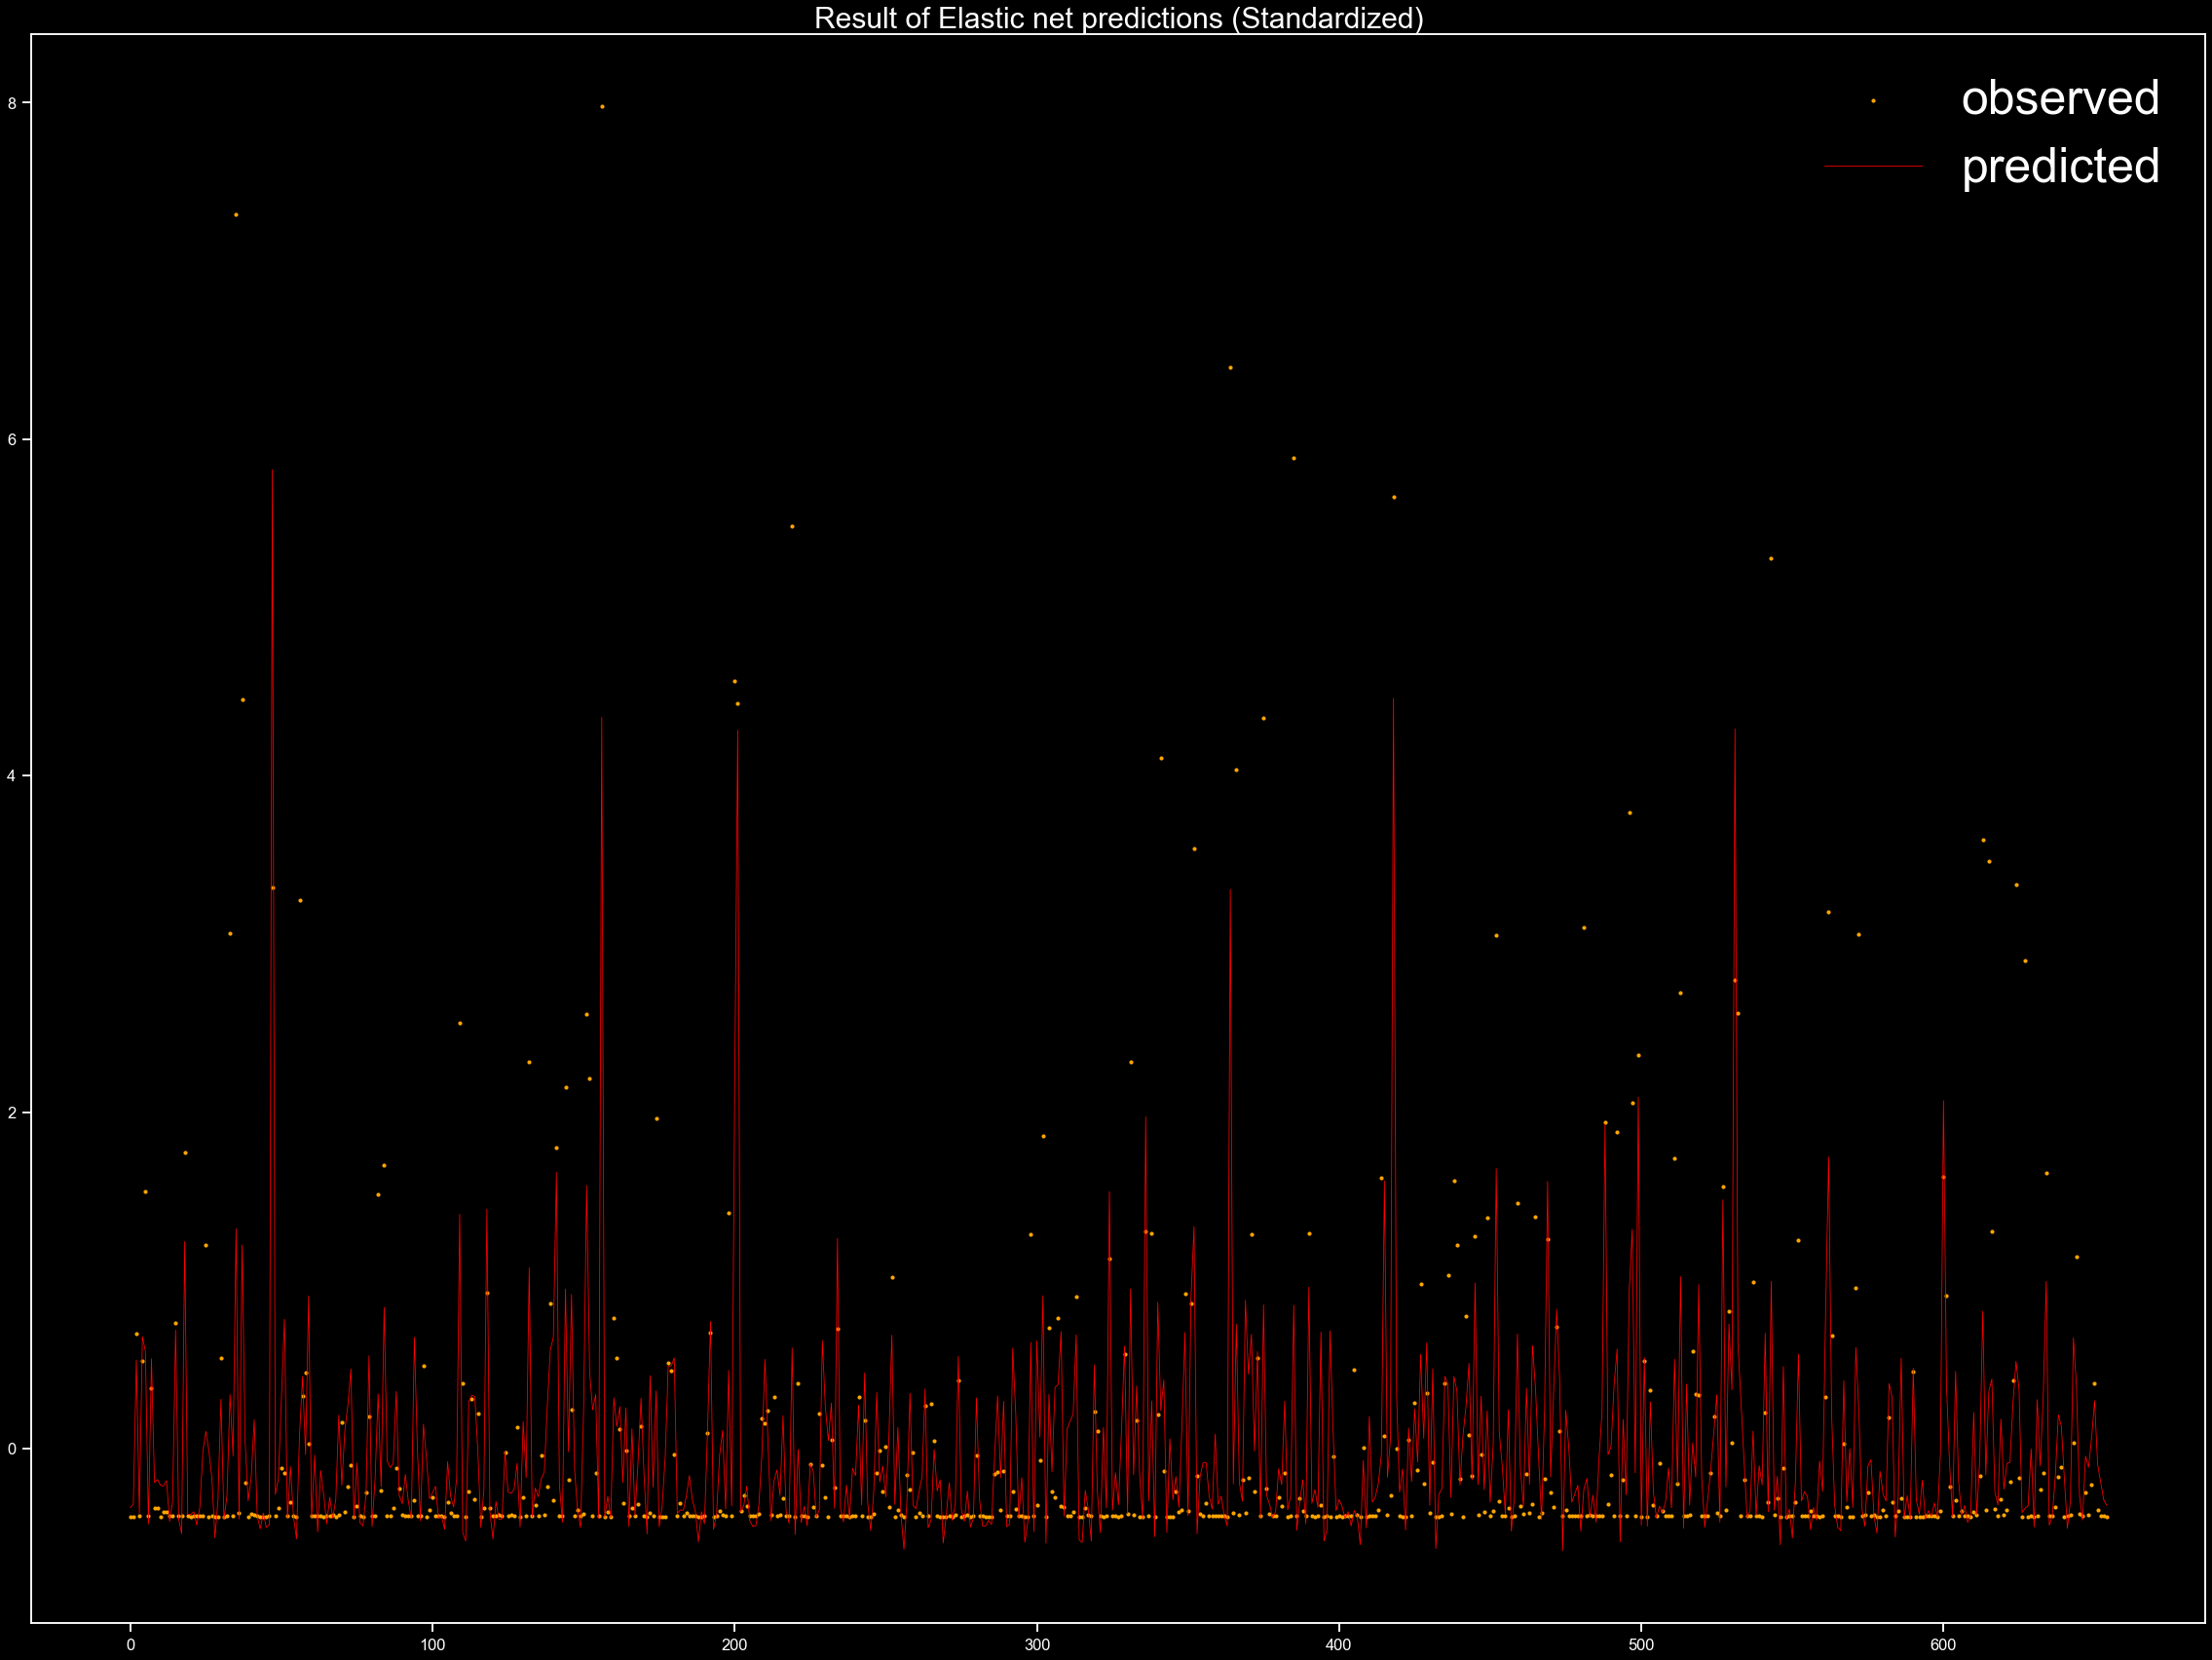

In [49]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

for a in alphas:
    model1 = ElasticNet(alpha=a).fit(X,Y)   
    score = model1.score(X, Y)
    pred_y = model1.predict(X)
    mse = mean_squared_error(Y, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}"
       .format(a, score, mse, np.sqrt(mse)))

elastic=ElasticNet(alpha=model.alpha_).fit(Xtrain, Ytrain)
ypred = elastic.predict(Xtest)
score = elastic.score(Xtest, Ytest)
mse = mean_squared_error(Ytest, ypred)
print("R2:{0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}"
      .format(score, mse, np.sqrt(mse)))
fig=plt.figure(figsize=(40, 30))
x_ax = range(len(Xtest))
plt.scatter(x_ax, Ytest, s=7, color="orange", label="observed")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.title('Result of Elastic net predictions (Standardized)',fontsize=30)
plt.legend(fontsize=50)
plt.show()


## Target feature transformation and glm

### Recode 'n_votes' with log

In [50]:
dataindependent2 = dataindependent
dataindependent2['Log_n_votes'] = [np.log(x) for x in dataindependent2['n_votes']]
dataindependent2['Log_Revenue'] = [np.log(x) for x in dataindependent2['Revenue']]
del dataindependent2["n_votes"]
del dataindependent2["Revenue"]
dataindependent2

Unnamed: 0  ratings  production_year  runtime  release_year  Time  \
0           2502      6.5             2010      105        2010.0   1.0   
1           1800      5.9             1978      127        1978.0   1.0   
2           2675      6.6             1994      105        1994.0   1.0   
3           3674      4.1             1982      108        1982.0   1.0   
4            365      7.8             1999      108        2000.0   2.0   
...          ...      ...              ...      ...           ...   ...   
3270        2787      6.3             1997       94        1999.0   3.0   
3271        2319      8.0             1961       25        2017.0  57.0   
3272        1856      7.6             2001       44        2000.0   0.0   
3273        1531      7.5             2006       98        2006.0   1.0   
3274        2919      4.1             2000       93        2000.0   1.0   

      Adventure  Comedy  Drama  Family  ...  Short  Game-Show  Reality-TV  \
0             1       1      1       0  ...      0          0           0   
1             0       0      1       1  ...      0          0           0   
2             0       0      1       0  ...      0          0           0   
3             0       0      1       0  ...      0          0           0   
4             0       0      0       0  ...      0          0           0   
...         ...     ...    ...     ...  ...    ...        ...         ...   
3270          0       1      0       0  ...      0          0           0   
3271          0       0      1       0  ...      0          0           0   
3272          0       0      1       0  ...      0          0           0   
3273          0       0      0       0  ...      0          0           0   
3274          0       1      0       1  ...      0          0           0   

      Film-Noir  Small  Middle  Leader  Independent  Log_n_votes  Log_Revenue  
0             0      1       0       0            0    11.439677    18.086400  
1             0      0       1       0            0     7.204149    17.270219  
2             0      0       1       0            0     8.486940    17.478610  
3             0      0       1       0            0     6.308098    16.087330  
4             0      1       0       0            0    12.338398    10.860813  
...         ...    ...     ...     ...          ...          ...          ...  
3270          0      1       0       0            0     6.880384    11.760437  
3271          0      1       0       0            0     7.691657    10.936826  
3272          0      1       0       0            0     3.526361    14.800223  
3273          0      0       1       0            0    10.217532    13.012752  
3274          0      0       0       0            1     7.738924    14.573933  

[3275 rows x 37 columns]

<AxesSubplot:xlabel='Log_n_votes', ylabel='Density'>

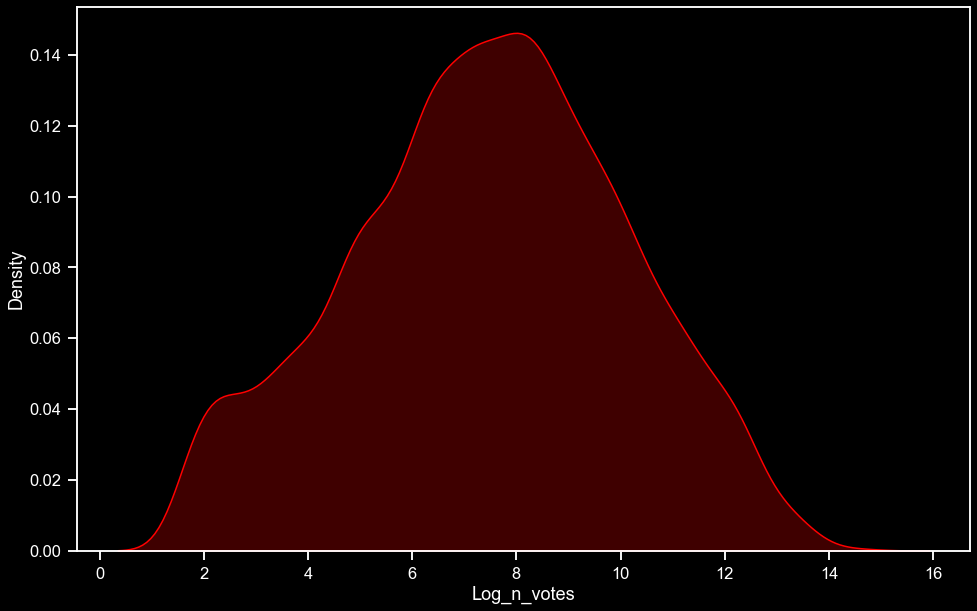

In [51]:
plt.figure(figsize=(16, 10))

sns.kdeplot(dataindependent2['Log_n_votes'], bw_adjust=0.8, color = 'Red', fill = True)

In [52]:
scaler = StandardScaler()
dataindependent3 = scaler.fit_transform(dataindependent2)
dataindependentScaled = pd.DataFrame(dataindependent3, columns = dataindependent.columns.values)
X = dataindependentScaled.drop("Log_Revenue", axis= 1)
Y = dataindependentScaled["Log_Revenue"]
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)

0.6160952352323561
0.6142996856208895
0.6288532505306801
0.6272236275025735


/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".g" (-> marker='.'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".g" (-> color='g'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


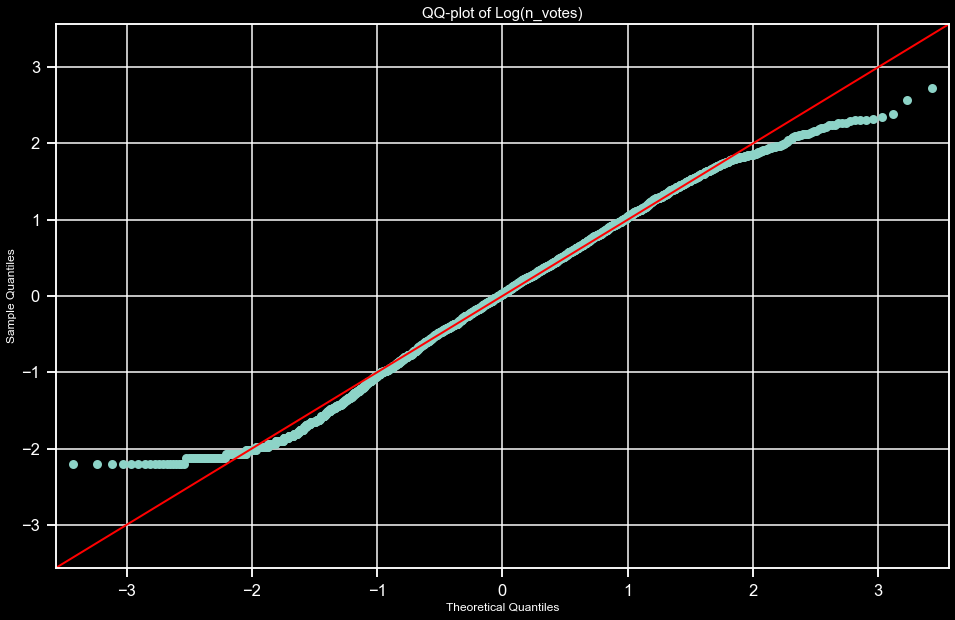

In [53]:
import scipy.stats as stats
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
pred_train_lr= lr.predict(Xtrain)
print(np.sqrt(mean_squared_error(Ytrain,pred_train_lr)))
print(r2_score(Ytrain, pred_train_lr))

pred_test_lr= lr.predict(Xtest)
print(np.sqrt(mean_squared_error(Ytest,pred_test_lr))) 
print(r2_score(Ytest, pred_test_lr))
fig, ax = plt.subplots(1, figsize=(16,10))

sm.qqplot(dataindependentScaled['Log_n_votes'],line='45',fit=True,dist=stats.norm, color='Orange',fmt='.g', ax=ax)

ax.grid()
ax.set_title('QQ-plot of Log(n_votes)',fontsize=15)
ax.xaxis.get_label().set_fontsize(12)
ax.yaxis.get_label().set_fontsize(12)
ax.get_lines()[1].set_color("red")
ax.get_lines()[1].set_linewidth("2")
plt.show()

/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".g" (-> marker='.'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


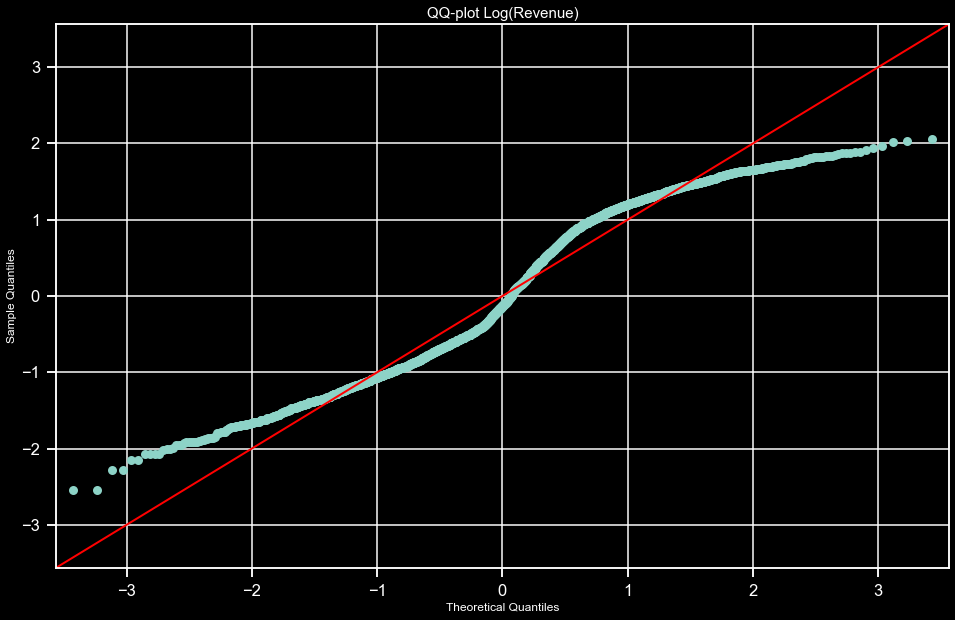

In [54]:
fig, ax = plt.subplots(1, figsize=(16,10))
sm.qqplot(dataindependentScaled['Log_Revenue'],line='45',fit=True,dist=stats.norm,fmt='.g', ax=ax)

ax.grid()
ax.set_title('QQ-plot Log(Revenue)',fontsize=15)
ax.xaxis.get_label().set_fontsize(12)
ax.yaxis.get_label().set_fontsize(12)
ax.get_lines()[1].set_color("red")
ax.get_lines()[1].set_linewidth("2")
plt.show()

In [55]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
pred_train_lr= lr.predict(Xtrain)
print(np.sqrt(mean_squared_error(Ytrain,pred_train_lr)))
print(r2_score(Ytrain, pred_train_lr))

pred_test_lr= lr.predict(Xtest)
print(np.sqrt(mean_squared_error(Ytest,pred_test_lr))) 
print(r2_score(Ytest, pred_test_lr))


0.6160952352323561
0.6142996856208895
0.6288532505306801
0.6272236275025735


In [56]:
model = ElasticNetCV(cv = 10).fit(Xtrain,Ytrain)
print(model.alpha_)

0.007961568145090246


In [57]:
Elasticfinal = ElasticNet(alpha = model.alpha_).fit(Xtrain,Ytrain)
Ypred = Elasticfinal.predict(Xtest)
mean_squared_error(Ytest,Ypred)
print('R squared training set', round(Elasticfinal.score(Xtrain, Ytrain)*100, 2))
print('R squared test set', round(Elasticfinal.score(Xtest, Ytest)*100, 2))

R squared training set 61.37
R squared test set 62.83


Alpha:0.0001, R2:0.62, MSE:0.38, RMSE:0.62
Alpha:0.0010, R2:0.62, MSE:0.38, RMSE:0.62
Alpha:0.0100, R2:0.62, MSE:0.38, RMSE:0.62
Alpha:0.1000, R2:0.58, MSE:0.42, RMSE:0.64
Alpha:0.3000, R2:0.49, MSE:0.51, RMSE:0.71
Alpha:0.5000, R2:0.38, MSE:0.62, RMSE:0.79
Alpha:0.7000, R2:0.23, MSE:0.77, RMSE:0.88
Alpha:1.0000, R2:0.05, MSE:0.95, RMSE:0.98
R2:0.628, MSE:0.39, RMSE:0.63


/Users/aymeric/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.864e+01, tolerance: 3.275e-01
  model = cd_fast.enet_coordinate_descent(


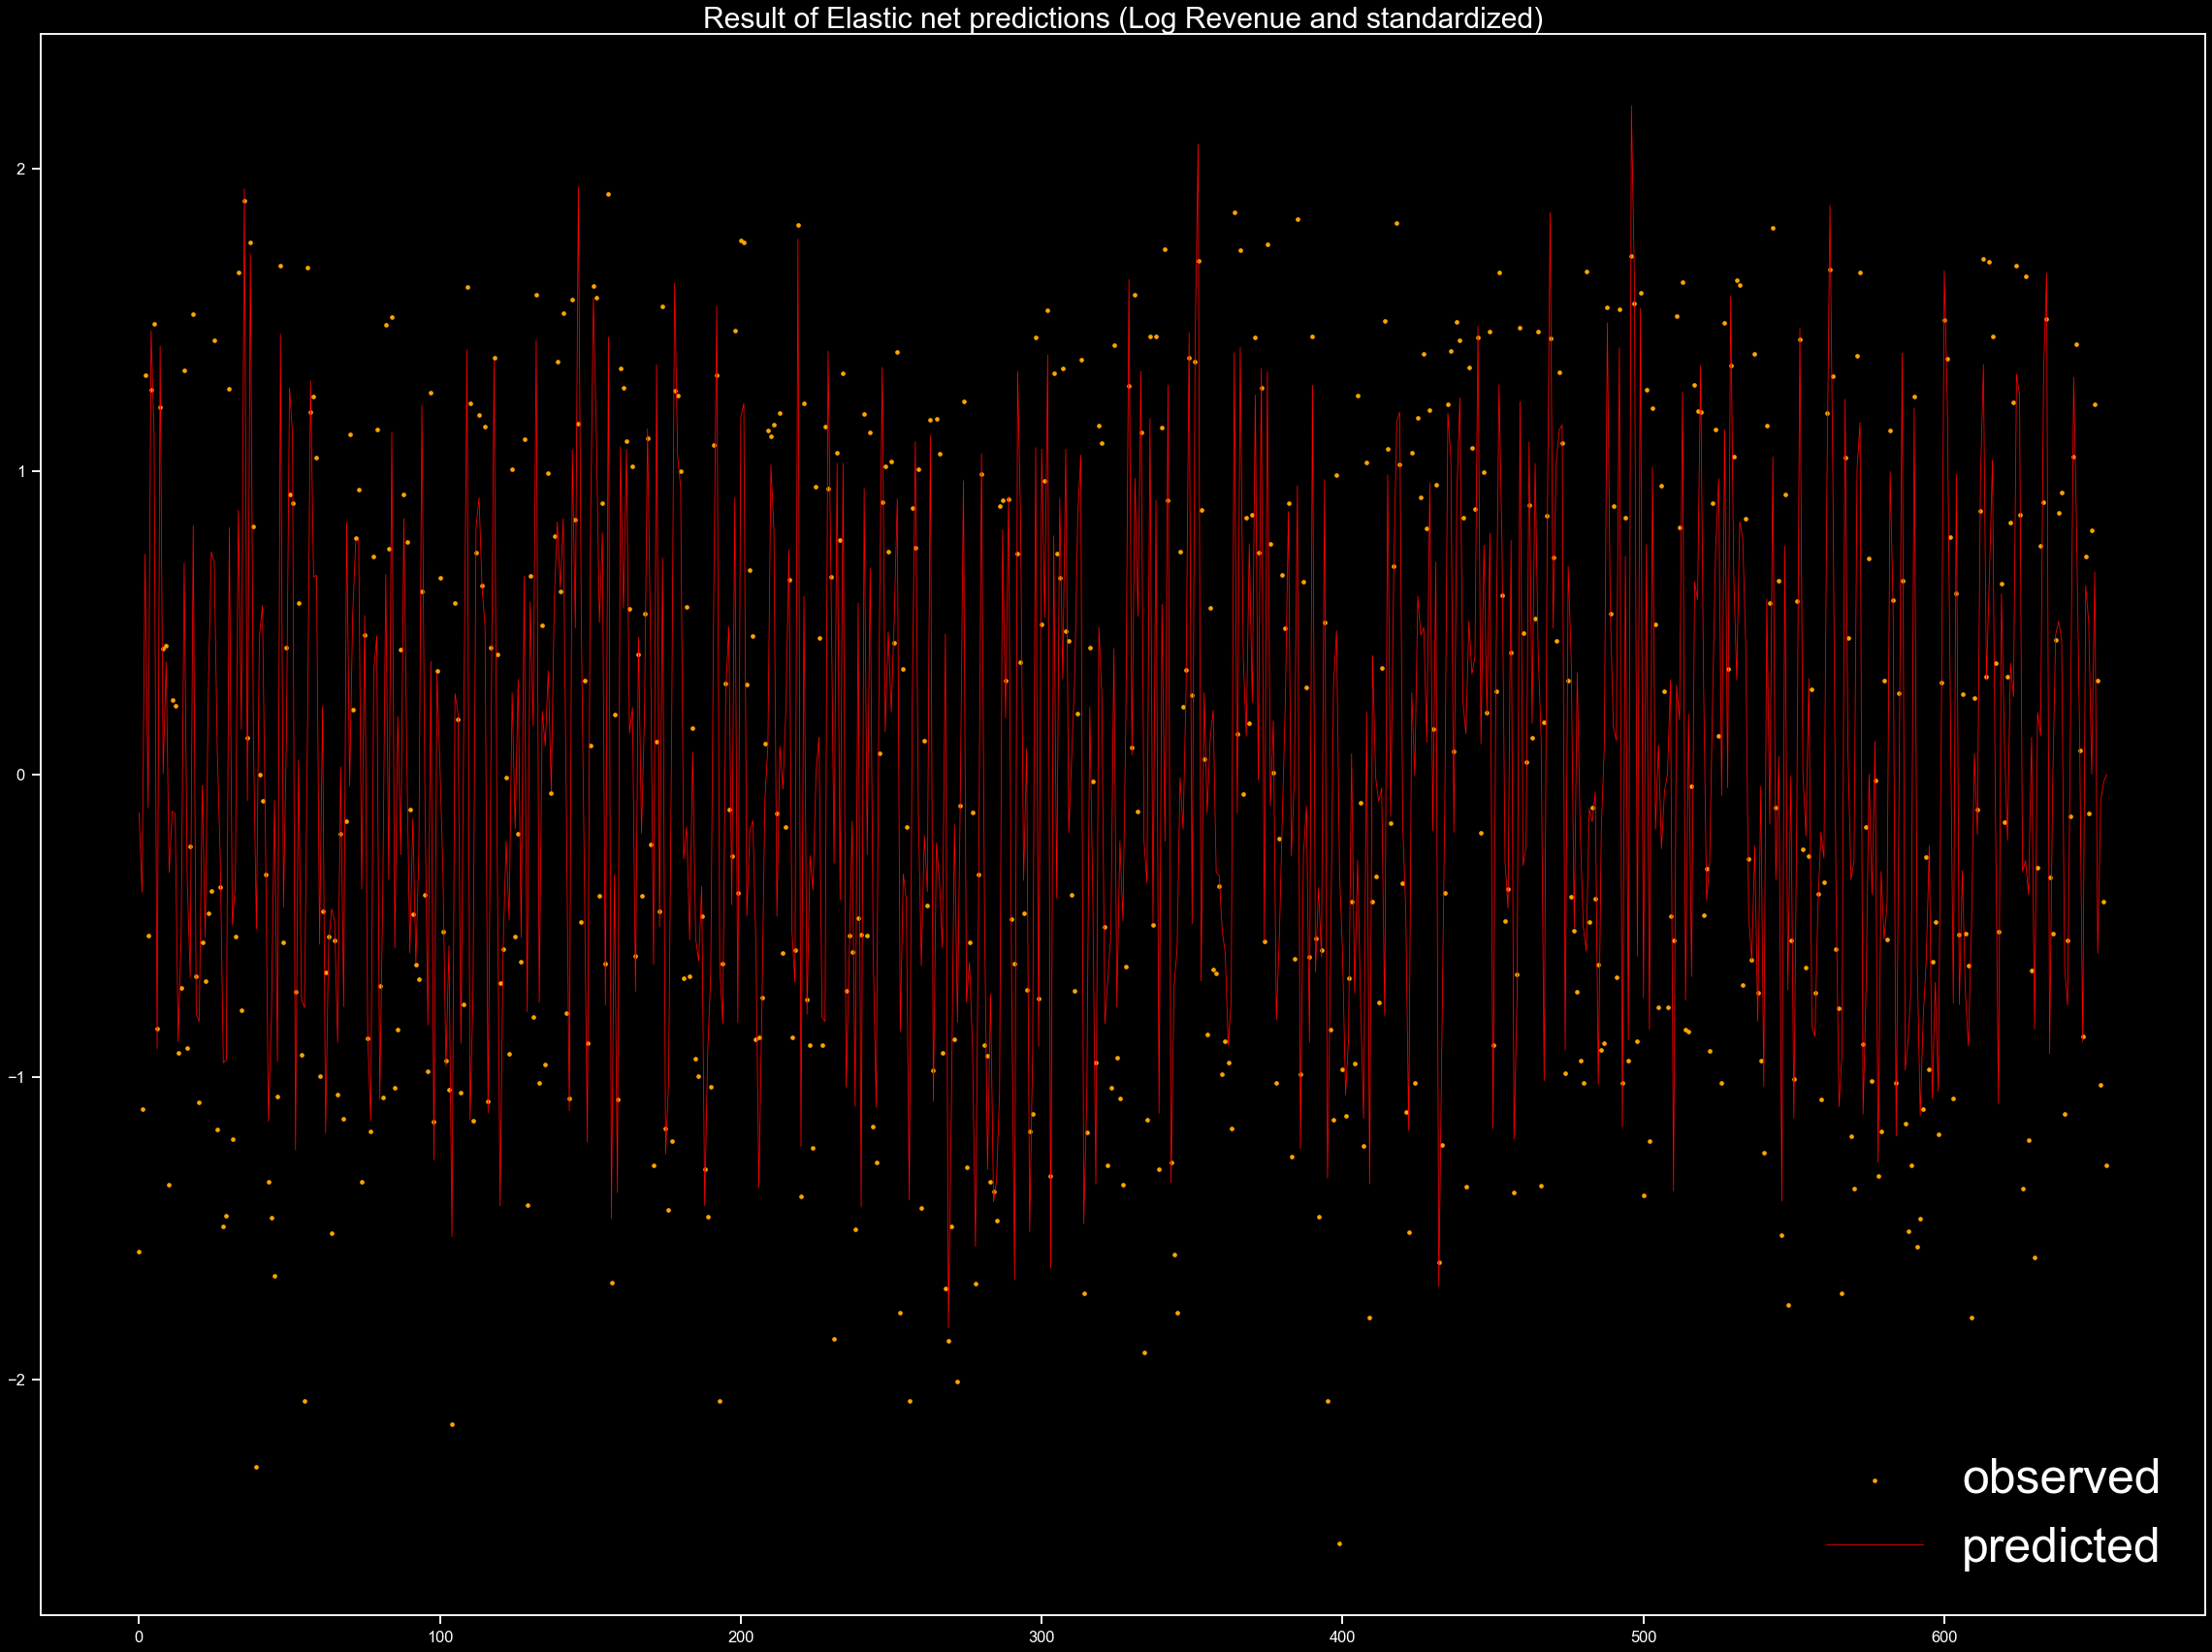

In [58]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

for a in alphas:
    model1 = ElasticNet(alpha=a).fit(X,Y)   
    score = model1.score(X, Y)
    pred_y = model1.predict(X)
    mse = mean_squared_error(Y, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}"
       .format(a, score, mse, np.sqrt(mse)))

elastic=ElasticNet(alpha=model.alpha_).fit(Xtrain, Ytrain)
ypred = elastic.predict(Xtest)
score = elastic.score(Xtest, Ytest)
mse = mean_squared_error(Ytest, ypred)
print("R2:{0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}"
      .format(score, mse, np.sqrt(mse)))
fig=plt.figure(figsize=(40, 30))
x_ax = range(len(Xtest))
plt.scatter(x_ax, Ytest, s=10, color="orange", label="observed")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.title('Result of Elastic net predictions (Log Revenue and standardized)',fontsize=30)
plt.legend(fontsize=50)
plt.show()

### Mixed GLM witht the studio feature that explain quantile bimodality

In [59]:
datamixed
del datamixed["Small"]

In [60]:
del datamixed["Middle"]
del datamixed["Leader"]
del datamixed["Independent"]

In [61]:
datamixed['Log_n_votes'] = [np.log(x) for x in datamixed['n_votes']]
datamixed['Log_Revenue'] = [np.log(x) for x in datamixed['Revenue']]

Text(0, 0.5, 'Log of the Revenue')

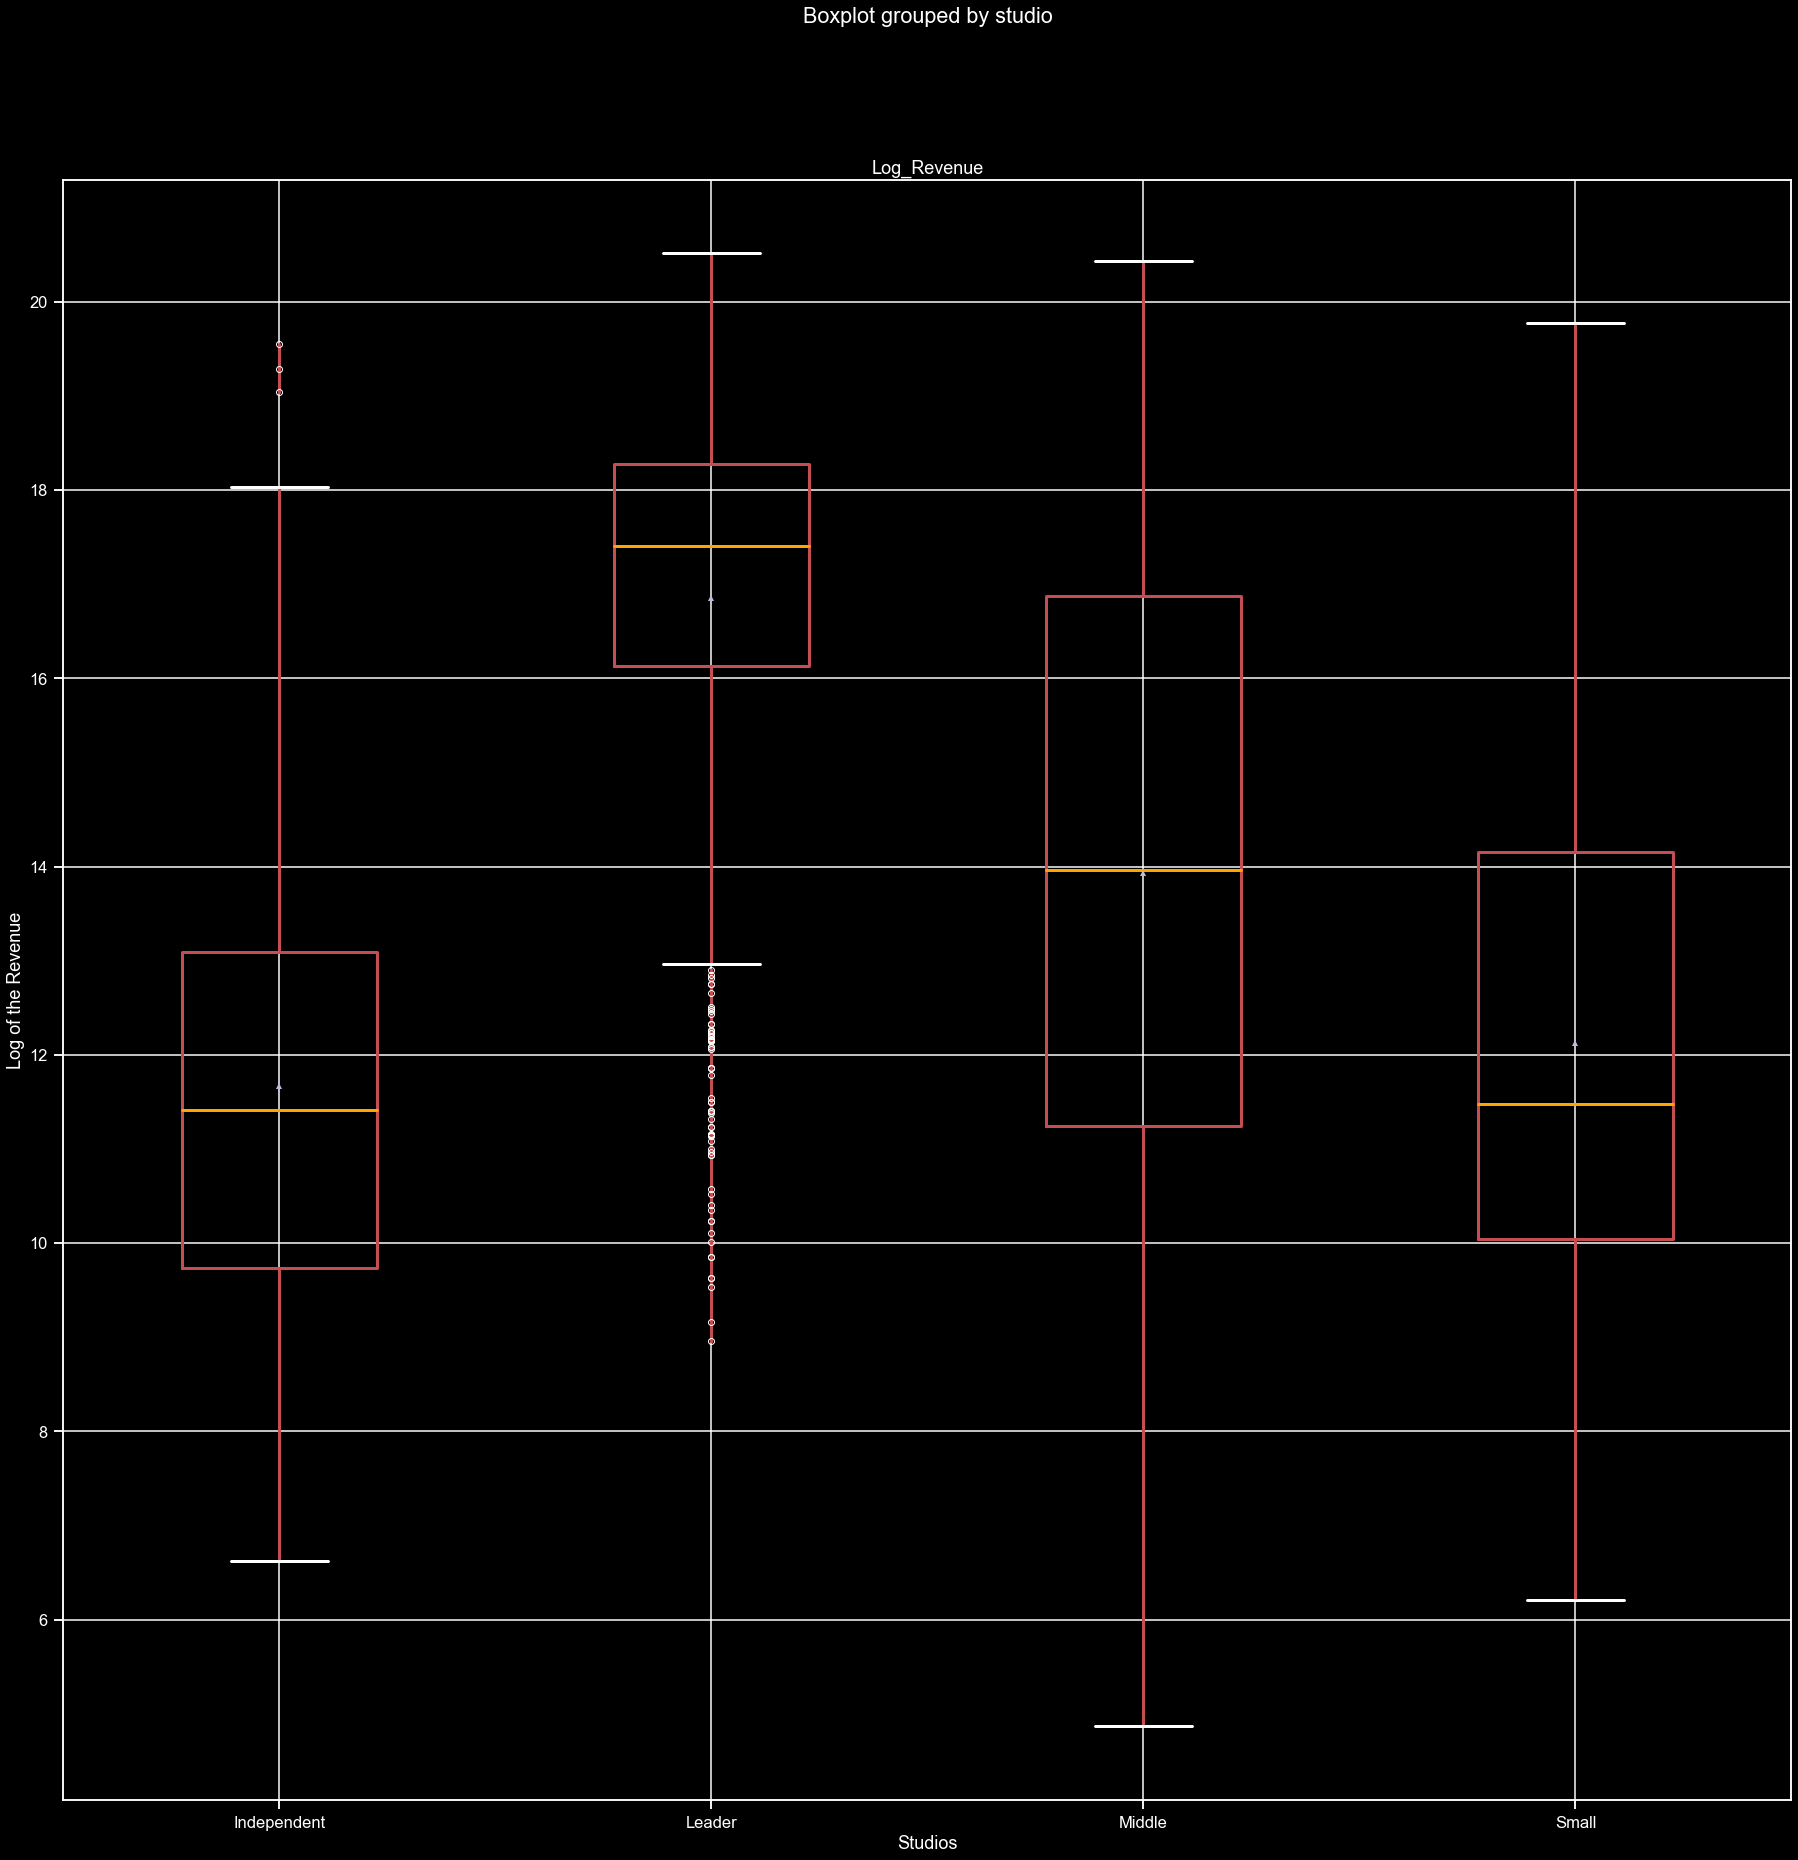

In [62]:
boxplot = datamixed.boxplot(["Log_Revenue"], by = ["studio"],
                                  boxprops=dict(linestyle='-', linewidth=3, color="r"),
                                  flierprops=dict(linestyle='-', linewidth=3,color="r"),
                                  medianprops=dict(linestyle='-', linewidth=3,color="orange"),
                                  whiskerprops=dict(linestyle='-', linewidth=3,color="r"),
                                  capprops=dict(linestyle='-', linewidth=3),
                     figsize = (30, 30),
                     showmeans = True,
                     notch = False)

boxplot.set_xlabel("Studios")
boxplot.set_ylabel("Log of the Revenue")

In [63]:
del datamixed["n_votes"]
del datamixed["Revenue"]

In [64]:
import statsmodels.formula.api as smf
model = smf.mixedlm("Log_Revenue ~ Unnamed: 0 + ratings + production_year + runtime + release_year + Log_n_votes + Adventure + Comedy + Drama + Family + Sport + Biography + Crime + Action +Thriller + Romance + Fantasy + Documentary +  Music + Animation +  Horror + Musical +  Mystery + History + War + Western + Short", datamixed, groups= "studio").fit() 
model.summary()    

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:              MixedLM  Dependent Variable:  Log_Revenue
No. Observations:   3275     Method:              REML       
No. Groups:         4        Scale:               5.0923     
Min. group size:    180      Log-Likelihood:      -7345.7087 
Max. group size:    1765     Converged:           Yes        
Mean group size:    818.8                                    
-------------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept       212.471    9.801 21.680 0.000 193.262 231.679
ratings           0.196    0.039  4.969 0.000   0.119   0.273
production_year  -0.045    0.005 -9.354 0.000  -0.054  -0.036
runtime          -0.008    0.002 -4.758 0.000  -0.011  -0.005
release_year     -0.057    0.006 -9.913 0.000  -0.068  -0.046
Log_n_votes       0.602    0.022 27.715 0.000   0.560   0.645
Adventure         0.411    0.147  2.790 0.005   0.122   0.699
Comedy            0.184    0.107  1.725 0.085  -0.025   0.393
Drama            -0.218    0.110 -1.983 0.047  -0.433  -0.002
Family            0.962    0.172  5.608 0.000   0.626   1.299
Sport             0.727    0.270  2.690 0.007   0.197   1.256
Biography         0.425    0.202  2.098 0.036   0.028   0.821
Crime             0.048    0.121  0.401 0.689  -0.188   0.285
Action            0.774    0.132  5.846 0.000   0.515   1.034
Thriller         -0.142    0.158 -0.896 0.370  -0.452   0.168
Romance           0.066    0.113  0.586 0.558  -0.155   0.287
Fantasy           0.370    0.188  1.969 0.049   0.002   0.737
Documentary      -0.382    0.186 -2.046 0.041  -0.747  -0.016
Music             0.290    0.203  1.429 0.153  -0.108   0.688
Animation        -0.032    0.225 -0.141 0.888  -0.474   0.410
Horror           -0.409    0.198 -2.067 0.039  -0.797  -0.021
Musical           0.541    0.347  1.560 0.119  -0.139   1.220
Mystery           0.063    0.178  0.356 0.722  -0.285   0.411
History           0.698    0.256  2.722 0.006   0.195   1.200
War              -0.368    0.277 -1.328 0.184  -0.911   0.175
Western          -0.007    0.347 -0.019 0.985  -0.687   0.674
Short             2.683    0.361  7.429 0.000   1.975   3.391
studio Var        1.595    0.582                             
=============================================================

"""

## KNN and Wrapper method 

Here we enter the enter in the world of the non parametric regression, as it's common to carry on the distribution of our target feature, we will pursue the previous analyzis done in the **description** section.  In fact as for the non parametric reggression, the target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set (i.e regression model with metaparameter $K$ that predicts the output of a sample as the mean of output of the $K$ nearest neighbours in the features space.
)

Therefore we will fix a number $k$ of observations which are the nearest to a given x:


$$\hat{m}_{NN}(x) = \sum_{i=1}^n \boldsymbol{W}_{ik}(x) Y_i $$

with 

$$\boldsymbol{W}_{ik}(x) = \frac{1}{k}\boldsymbol{I}(X_i \in J_k(x))$$

where $J_k(x)$ is the set of k observations nearest to x. In this case, the smoothing parameter is $k$ with conditions for consistency that $k = k_n \rightarrow \infty$ and that $\frac{k}{n} \rightarrow 0$ for $n \rightarrow \infty$. IN pratice, we can choose the right $k$ by choosing the bandwidth $h$ setting $k = nh$.


Moreover, this is a special case of the **GNN** where for the k-NN the kernel chosen is the following one:

$$K(u) = \frac{1}{2} \boldsymbol{I}(|u| \leq 1)$$

The **KNN** algorithm uses **feature similarity** to predict the values of any new data points. This means that the new point is assigned a value based on how closely it resembles the points in the training set. The algorithm works in 3 steps:

- First, the distance between the new point and each training point is calculated. **Euclidian** for continuous, **Manhattan** for real vectors and **Hamming** Distance for categorical.
- The closest $k$ data points are selected (based on the distance).
- The average of these data points is the final prediction for the new point.


We notice that based on the $k$ value, the final result tends to change. Then how can we figure out the optimum value of $k$? 

In [65]:
dataindependent

Unnamed: 0  ratings  production_year  runtime  release_year  Time  \
0           2502      6.5             2010      105        2010.0   1.0   
1           1800      5.9             1978      127        1978.0   1.0   
2           2675      6.6             1994      105        1994.0   1.0   
3           3674      4.1             1982      108        1982.0   1.0   
4            365      7.8             1999      108        2000.0   2.0   
...          ...      ...              ...      ...           ...   ...   
3270        2787      6.3             1997       94        1999.0   3.0   
3271        2319      8.0             1961       25        2017.0  57.0   
3272        1856      7.6             2001       44        2000.0   0.0   
3273        1531      7.5             2006       98        2006.0   1.0   
3274        2919      4.1             2000       93        2000.0   1.0   

      Adventure  Comedy  Drama  Family  ...  Short  Game-Show  Reality-TV  \
0             1       1      1       0  ...      0          0           0   
1             0       0      1       1  ...      0          0           0   
2             0       0      1       0  ...      0          0           0   
3             0       0      1       0  ...      0          0           0   
4             0       0      0       0  ...      0          0           0   
...         ...     ...    ...     ...  ...    ...        ...         ...   
3270          0       1      0       0  ...      0          0           0   
3271          0       0      1       0  ...      0          0           0   
3272          0       0      1       0  ...      0          0           0   
3273          0       0      0       0  ...      0          0           0   
3274          0       1      0       1  ...      0          0           0   

      Film-Noir  Small  Middle  Leader  Independent  Log_n_votes  Log_Revenue  
0             0      1       0       0            0    11.439677    18.086400  
1             0      0       1       0            0     7.204149    17.270219  
2             0      0       1       0            0     8.486940    17.478610  
3             0      0       1       0            0     6.308098    16.087330  
4             0      1       0       0            0    12.338398    10.860813  
...         ...    ...     ...     ...          ...          ...          ...  
3270          0      1       0       0            0     6.880384    11.760437  
3271          0      1       0       0            0     7.691657    10.936826  
3272          0      1       0       0            0     3.526361    14.800223  
3273          0      0       1       0            0    10.217532    13.012752  
3274          0      0       0       0            1     7.738924    14.573933  

[3275 rows x 37 columns]

In [66]:
X = dataindependent.drop("Log_Revenue", axis= 1)
Y = dataindependent["Log_Revenue"]
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)

In [67]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(Xtrain)
x_train = pd.DataFrame(x_train_scaled,columns = Xtrain.columns.values)
print(x_train)

x_test_scaled = scaler.fit_transform(Xtest)
x_test = pd.DataFrame(x_test_scaled, columns = Xtest.columns.values)

      Unnamed: 0   ratings  production_year   runtime  release_year      Time  \
0       0.354483  0.867470         0.533981  0.237589      0.402597  0.020833   
1       0.470460  0.614458         0.912621  0.156028      0.896104  0.010417   
2       0.535765  0.819277         0.805825  0.085106      0.740260  0.000000   
3       0.341924  0.710843         0.844660  0.203901      0.805195  0.010417   
4       0.658294  0.602410         0.893204  0.193262      0.870130  0.010417   
...          ...       ...              ...       ...           ...       ...   
2615    0.954461  0.602410         0.815534  0.170213      0.779221  0.020833   
2616    0.409414  0.530120         0.980583  0.156028      1.000000  0.020833   
2617    0.458447  0.698795         0.873786  0.136525      1.000000  0.135417   
2618    0.510429  0.662651         0.708738  0.154255      0.961039  0.281250   
2619    0.467839  0.831325         0.893204  0.143617      0.909091  0.041667   

      Adventure  Comedy  Dr

In [68]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
rmse_val = []
for K in range(100):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(x_train, Ytrain)
    pred=model.predict(x_test)
    error = sqrt(mean_squared_error(Ytest,pred))
    rmse_val.append(error)

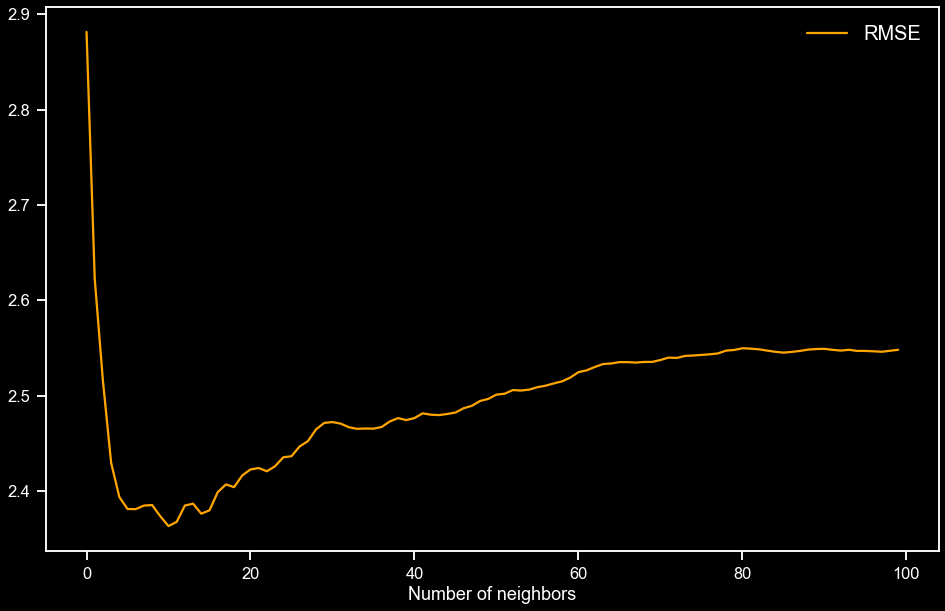

In [69]:
curve = pd.DataFrame(rmse_val)  
curve.plot(figsize=(16,10), color="orange", xlabel = "Number of neighbors")
plt.legend(['RMSE'],fontsize=20)

In [70]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(x_train,Ytrain)
model.best_params_

{'n_neighbors': 8}

In [71]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 8)
knn.fit(x_train, Ytrain)
pred=knn.predict(x_test)
estimation = pd.DataFrame({'pred':exp(pred), 'test':exp(Ytest)})
compute_rmse(pred, Ytest)

2.384722347161931

In [72]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

rmse_val = []
for k in range(30):
    k = k+1
    sfs1 = sfs(knn,
           k_features=k,
           forward=True,
           scoring="max_error",
           cv=10)
    sfs1 = sfs1.fit(x_train, Ytrain)
    feat_cols = list(sfs1.k_feature_idx_)
    knn.fit(x_train.iloc[:, feat_cols], Ytrain)
    pred=knn.predict(x_test.iloc[:, feat_cols])
    error = compute_rmse(pred, Ytest)
    rmse_val.append(error)
    print(k)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


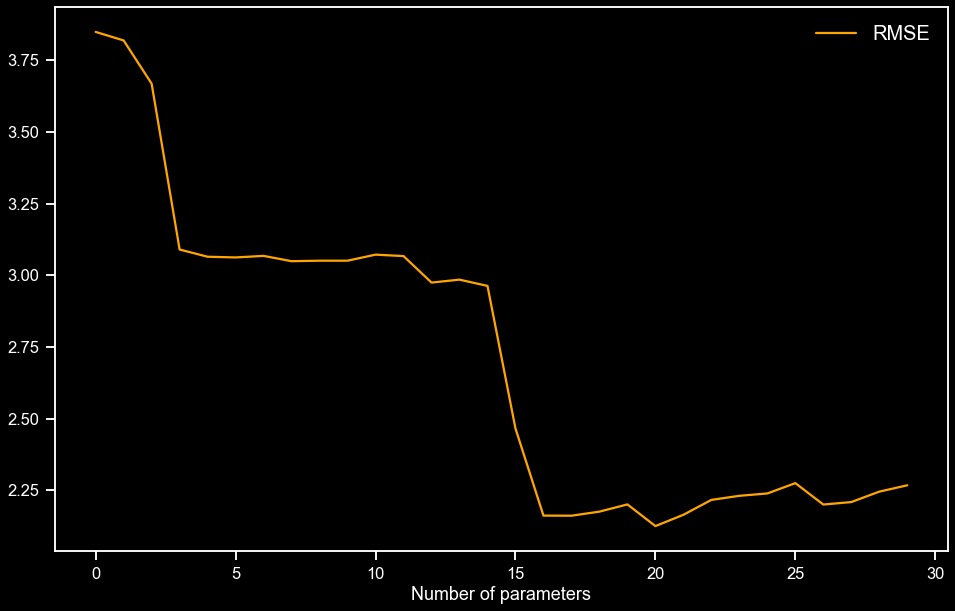

In [73]:
curve = pd.DataFrame(rmse_val)  
curve.plot(figsize=(16,10), color="orange", xlabel = "Number of parameters")
plt.legend(['RMSE'],fontsize=20)

# MLP processes

The reason why **ReLU** became more adopted is that it allows better optimization using Stochastic Gradient Descent, more efficient computation and is scale-invariant, meaning, its characteristics are not affected by the scale of the input. **BERT** is a method of pretraining language representations that was used to create models that **NLP** practicioners can then download and use for free. You can either use these models to extract high quality language features from your text data, or you can fine-tune these models on a specific task (classification, entity recognition, question answering, etc.) with your own data to produce state of the art predictions. These vectors are used as high-quality feature inputs to downstream models. **BERT** produces word representations that are dynamically informed by the words around them.

In [74]:
DATAMLP

Unnamed: 0                       title  \
0           2502           Letters to Juliet   
1           1800        International Velvet   
2           2675                   8 Seconds   
3           3674             Penitentiary II   
4            365         The Boondock Saints   
...          ...                         ...   
3270        2787            Stiff Upper Lips   
3271        2319                  Twenty Two   
3272        1856                   Girlfight   
3273        1531  This Film Is Not Yet Rated   
3274        2919  MVP: Most Valuable Primate   

                                                img_url  \
0     https://m.media-amazon.com/images/M/MV5BMjg0OT...   
1     https://m.media-amazon.com/images/M/MV5BOGVkYj...   
2     https://m.media-amazon.com/images/M/MV5BYjY4Nz...   
3     https://m.media-amazon.com/images/M/MV5BNjQyZW...   
4     https://m.media-amazon.com/images/M/MV5BNTliMT...   
...                                                 ...   
3270  https://m.media-amazon.com/images/M/MV5BNGRiMz...   
3271  https://m.media-amazon.com/images/M/MV5BMjMyMz...   
3272  https://m.media-amazon.com/images/M/MV5BMTMzMz...   
3273  https://m.media-amazon.com/images/M/MV5BMTk0ND...   
3274  https://m.media-amazon.com/images/M/MV5BMjMzOD...   

                                            description  ratings   n_votes  \
0     Letters to Juliet: Directed by Gary Winick. Wi...      6.5   92937.0   
1     International Velvet: Directed by Bryan Forbes...      5.9    1345.0   
2     8 Seconds: Directed by John G. Avildsen. With ...      6.6    4851.0   
3     Penitentiary II: Directed by Jamaa Fanaka. Wit...      4.1     549.0   
4     The Boondock Saints: Directed by Troy Duffy. W...      7.8  228296.0   
...                                                 ...      ...       ...   
3270  Stiff Upper Lips: Directed by Gary Sinyor. Wit...      6.3     973.0   
3271  Twenty Two: Directed by Jack Smight. With Barb...      8.0    2190.0   
3272  Girlfight: Directed by Lawrence Trilling. With...      7.6      34.0   
3273  This Film Is Not Yet Rated: Directed by Kirby ...      7.5   27379.0   
3274  MVP: Most Valuable Primate: Directed by Robert...      4.1    2296.0   

      production_year  runtime                      genres  release_year  ...  \
0                2010      105  [Adventure, Comedy, Drama]        2010.0  ...   
1                1978      127      [Drama, Family, Sport]        1978.0  ...   
2                1994      105   [Biography, Drama, Sport]        1994.0  ...   
3                1982      108       [Crime, Drama, Sport]        1982.0  ...   
4                1999      108   [Action, Crime, Thriller]        2000.0  ...   
...               ...      ...                         ...           ...  ...   
3270             1997       94                    [Comedy]        1999.0  ...   
3271             1961       25    [Drama, Fantasy, Horror]        2017.0  ...   
3272             2001       44            [Drama, Romance]        2000.0  ...   
3273             2006       98               [Documentary]        2006.0  ...   
3274             2000       93     [Comedy, Family, Sport]        2000.0  ...   

     Horror Musical Mystery  History  War  Western  Short  Game-Show  \
0         0       0       0        0    0        0      0          0   
1         0       0       0        0    0        0      0          0   
2         0       0       0        0    0        0      0          0   
3         0       0       0        0    0        0      0          0   
4         0       0       0        0    0        0      0          0   
...     ...     ...     ...      ...  ...      ...    ...        ...   
3270      0       0       0        0    0        0      0          0   
3271      1       0       0        0    0        0      0          0   
3272      0       0       0        0    0        0      0          0   
3273      0       0       0        0    0        0      0          0   
3274      0       